In [4]:
# Unzip data from Kaggle
!kaggle datasets download -d kazanova/sentiment140
!unzip -o sentiment140.zip

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [5]:
# Sentimental_Analysis_RNN
# load Libraries
#
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import re
import pickle as pic
import string

# tensorflow
import tensorflow as tf
import tensorflow_datasets as tfds

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

#nltk

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

!pip install wordcloud

#plotting
import seaborn as sns
from wordcloud import WordCloud

In [6]:
# 1. Load and Preprocess the Sentiment140 Dataset
file_path = '/content/training.1600000.processed.noemoticon.csv'
data = pd.read_csv(file_path, encoding = 'latin', names =['polarity', 'id', 'date', 'query', 'user', 'text'])

data = data.sample(frac=1)
# To limit resourses
data = data[:20000]

# print dataset shape
# print("Dataset shape is",data.shape)

# print top 5 rows
print(data.head(5))

data['polarity'].unique()

# data[polarity] -->0 = negative
# data[polarity] -->1 = positive

data['polarity'] = data['polarity'].replace(4,1)
# print(data.head())

print("*"*30)
print(data.describe())
print("*"*30)
print("\n")

         polarity          id                          date     query  \
1387099         4  2052900424  Sat Jun 06 02:28:14 PDT 2009  NO_QUERY   
609966          0  2223953551  Thu Jun 18 08:54:48 PDT 2009  NO_QUERY   
998075          4  1836189182  Mon May 18 07:32:35 PDT 2009  NO_QUERY   
1215183         4  1989516163  Mon Jun 01 01:50:11 PDT 2009  NO_QUERY   
607659          0  2223039862  Thu Jun 18 07:46:19 PDT 2009  NO_QUERY   

                  user                                               text  
1387099  lifesabeach27  @sarah_shi I stayed up till 4am watching somet...  
609966          Ell991  @dannii2eyes, Oh no  That was actually one of ...  
998075           j3nna  @DAChesterFrench &quot;Fingers&quot; make me s...  
1215183     ralpharama  @fiascowines your Monday must be about over no...  
607659     graggfamily  When it rains, it pours!  Nolan broke Zoe's gl...  
******************************
           polarity            id
count  20000.000000  2.000000e+04
mean  

In [7]:
# count of positive and negative reviews
postive = data[data['polarity'] == 1]
negative = data[data['polarity'] == 0]

# print("positive reviews",len(postive))
# print("negative reviews",len(negative))

def word_count(words):
    return len(words.split())

# plot word count distribution of positive and negative comments
data['word count'] = data['text'].apply(word_count)

# Filter positive and negative comments based on polarity
pos = data[data['polarity'] == 1]['word count']
neg = data[data['polarity'] == 0]['word count']

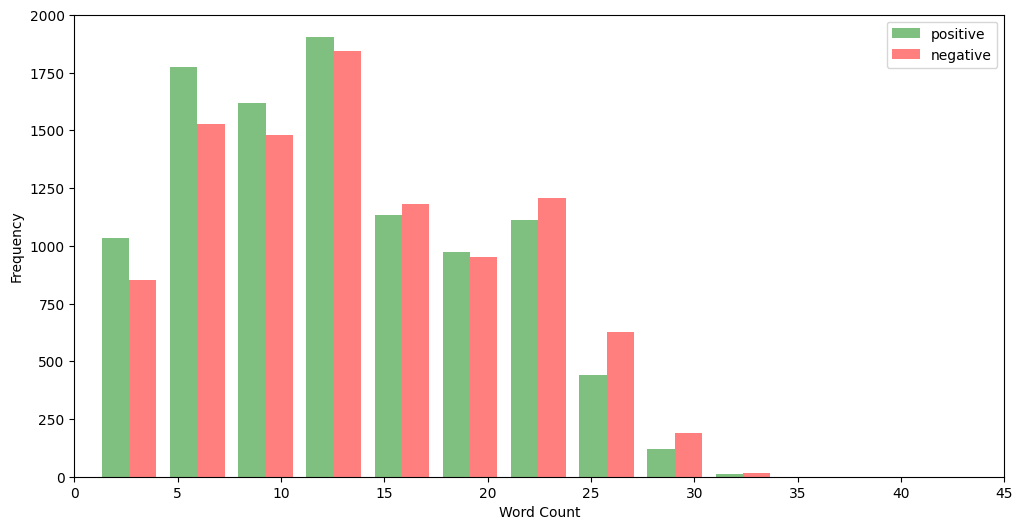

In [8]:
# Plot the histogram
plt.figure(figsize=(12, 6))
plt.xlim(0, 45)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.hist([pos, neg], color=['green', 'red'], alpha=0.5, label=['positive', 'negative'])
plt.legend(loc='upper right')
plt.show()

<Axes: ylabel='count'>

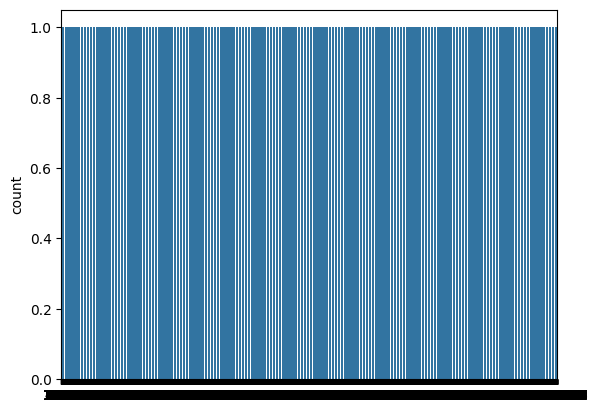

In [9]:
# get common words for training
'''
from collections import Counter
words = []
for l in list(data['text']):
    words = l.split()
    for word in words:
        if len(word) < 2:
            words.append(word.lower())

words_most = Counter(words).most_common(10)
print(words_most)
'''
# Data Preprocessing
import matplotlib.pyplot as plt
plt.ion()
sns.countplot(data['polarity'])

In [10]:
# remove unwanted attributes
data.drop(['id', 'date' ,'query' ,'user' ,'word count'], axis=1, inplace=True)

# check for null
# print(data.isnull().sum()/ len(data)*100)

# convert data[text] into str type
data['text'] = data['text'].astype(str)

nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
print(stopwords)

# nltk download punkt and wordnet
nltk.download('punkt')
nltk.download('wordnet')

urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'

def process_tweets(tweet):
  # Lower Casing
    tweet = tweet.lower()
    tweet=tweet[1:]
    # Removing all URls
    tweet = re.sub(urlPattern, '' ,tweet)
    # Removing all @username.
    tweet = re.sub(userPattern, '', tweet)
    #Remove punctuations
    tweet = tweet.translate(str.maketrans("" ,"" ,string.punctuation))
    #tokenizing words
    tokens = word_tokenize(tweet)
    #Removing Stop Words
    final_tokens = [w for w in tokens if w not in stopwords]
    #reducing a word to its word stem
    wordLemm = WordNetLemmatizer()
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        finalwords.append(word)
    return ' '.join(finalwords)


data['processed_tweets'] = data['text'].apply(lambda x: process_tweets(x))
# print('Text Preprocessing complete.')
# print(data.head(10))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...


{'than', 'with', 'have', 'weren', 'they', 'too', 'when', 'ma', 'yourselves', 'theirs', 'just', 'no', 'those', 'then', "doesn't", 'in', "couldn't", 'ours', 'and', 'up', 'from', 'are', 'him', "hasn't", 'himself', "don't", 'further', "haven't", 're', 'between', "won't", 'their', 'what', 'each', 'own', 'itself', 'doing', 'y', 'who', 'yourself', 'will', 'but', 'your', 'off', "she's", 'do', 'needn', 'mustn', 'she', 'on', "didn't", 'over', 'our', 'by', 'into', 'during', 'here', 'how', 'these', 'before', 'through', 'few', 'after', 'to', 'hadn', 'again', 'so', 'against', 'or', 'my', 'his', "you'll", 'were', 'above', 'once', 'll', 'that', "should've", 'herself', 'themselves', 'is', 'yours', 'was', 'all', "needn't", 'why', "wasn't", 'out', 'won', 'same', 'i', "isn't", 've', "you're", 'this', 'me', 'an', 'below', 'for', 'it', 'her', 'o', 'been', 'under', 'm', 'be', "shouldn't", 'did', 'being', 'down', 'whom', "mightn't", "wouldn't", 'at', "you'd", 'while', "that'll", 'd', 'more', "hadn't", 'he', '

[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [11]:
# Vectorizing the data

X = data['processed_tweets'].values
y = data['polarity'].values

print(f"X Spahe: {X.shape} \t Y Shape: {y.shape}")

X Spahe: (20000,) 	 Y Shape: (20000,)


In [12]:
# Convert collection of raw documents to a matrix of TF-IDF features.
vector = TfidfVectorizer(sublinear_tf=True)
X = vector.fit_transform(X)
print('Vector complete.')
print("No of feature_words",len(vector.get_feature_names_out()))

print(f"X Shape: {X.shape} \t Y Shape: {y.shape}")

Vector complete.
No of feature_words 30528
X Shape: (20000, 30528) 	 Y Shape: (20000,)


In [13]:
# Rnn Model Building
# Define the RNN model
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import re

# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

max_words = 5000
max_len = 200

In [14]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data.processed_tweets)
sequences = tokenizer.texts_to_sequences(data.processed_tweets)
tweets = pad_sequences(sequences, maxlen=max_len)
# print(tweets)

with open('tokenizer.pickle', 'wb') as handle:
    pic.dump(tokenizer, handle, protocol=pic.HIGHEST_PROTOCOL)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tweets, y, test_size=0.2, random_state=42)
# print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

model2 = Sequential()
model2.add(layers.Embedding(max_words, 128))
model2.add(layers.SimpleRNN(64,dropout=0.5))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(8, activation='relu'))
model2.add(layers.Dense(1,activation='sigmoid'))
model2.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

model2.summary()
checkpoint2 = ModelCheckpoint("rnn_model.keras", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', save_freq=1,save_weights_only=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         640000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 653537 (2.49 MB)
Trainable params: 653537 (2.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
history = model2.fit(X_train, y_train, epochs=10,validation_data=(X_test, y_test),callbacks=[checkpoint2])

# Evaluating the model
loss, accuracy = model2.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

model2.save('rnn_model.h5')

Epoch 1/10


  1/500 [..............................] - ETA: 11:32 - loss: 0.6825 - accuracy: 0.5938

  3/500 [..............................] - ETA: 21s - loss: 0.6924 - accuracy: 0.5312  

  5/500 [..............................] - ETA: 20s - loss: 0.6932 - accuracy: 0.5125

  7/500 [..............................] - ETA: 20s - loss: 0.6920 - accuracy: 0.5045

  9/500 [..............................] - ETA: 19s - loss: 0.6878 - accuracy: 0.5382

 11/500 [..............................] - ETA: 19s - loss: 0.6972 - accuracy: 0.5227

 13/500 [..............................] - ETA: 20s - loss: 0.6953 - accuracy: 0.5264

 15/500 [..............................] - ETA: 20s - loss: 0.6978 - accuracy: 0.5167

 17/500 [>.............................] - ETA: 20s - loss: 0.6952 - accuracy: 0.5239

 19/500 [>.............................] - ETA: 20s - loss: 0.6975 - accuracy: 0.5132

 21/500 [>.............................] - ETA: 20s - loss: 0.6972 - accuracy: 0.5179

 23/500 [>.............................] - ETA: 20s - loss: 0.6952 - accuracy: 0.5285

 25/500 [>.............................] - ETA: 20s - loss: 0.6949 - accuracy: 0.5238

 27/500 [>.............................] - ETA: 19s - loss: 0.6950 - accuracy: 0.5208

 29/500 [>.............................] - ETA: 19s - loss: 0.6942 - accuracy: 0.5226

 31/500 [>.............................] - ETA: 19s - loss: 0.6940 - accuracy: 0.5252

 33/500 [>.............................] - ETA: 19s - loss: 0.6940 - accuracy: 0.5246

 35/500 [=>............................] - ETA: 19s - loss: 0.6941 - accuracy: 0.5241

 37/500 [=>............................] - ETA: 19s - loss: 0.6944 - accuracy: 0.5228

 39/500 [=>............................] - ETA: 19s - loss: 0.6941 - accuracy: 0.5208

 41/500 [=>............................] - ETA: 19s - loss: 0.6941 - accuracy: 0.5191

 43/500 [=>............................] - ETA: 19s - loss: 0.6934 - accuracy: 0.5211

 45/500 [=>............................] - ETA: 18s - loss: 0.6938 - accuracy: 0.5201

 47/500 [=>............................] - ETA: 18s - loss: 0.6938 - accuracy: 0.5193

 49/500 [=>............................] - ETA: 18s - loss: 0.6939 - accuracy: 0.5185

 51/500 [==>...........................] - ETA: 18s - loss: 0.6941 - accuracy: 0.5165

 53/500 [==>...........................] - ETA: 18s - loss: 0.6943 - accuracy: 0.5147

 55/500 [==>...........................] - ETA: 18s - loss: 0.6946 - accuracy: 0.5125

 57/500 [==>...........................] - ETA: 18s - loss: 0.6949 - accuracy: 0.5088

 59/500 [==>...........................] - ETA: 18s - loss: 0.6954 - accuracy: 0.5042

 61/500 [==>...........................] - ETA: 18s - loss: 0.6953 - accuracy: 0.5041

 63/500 [==>...........................] - ETA: 18s - loss: 0.6952 - accuracy: 0.5060

 65/500 [==>...........................] - ETA: 17s - loss: 0.6950 - accuracy: 0.5077

 67/500 [===>..........................] - ETA: 17s - loss: 0.6952 - accuracy: 0.5047

 69/500 [===>..........................] - ETA: 17s - loss: 0.6953 - accuracy: 0.5041

 71/500 [===>..........................] - ETA: 17s - loss: 0.6953 - accuracy: 0.5018

 73/500 [===>..........................] - ETA: 17s - loss: 0.6952 - accuracy: 0.5030

 75/500 [===>..........................] - ETA: 17s - loss: 0.6952 - accuracy: 0.5038

 77/500 [===>..........................] - ETA: 17s - loss: 0.6951 - accuracy: 0.5053

 79/500 [===>..........................] - ETA: 17s - loss: 0.6951 - accuracy: 0.5055

 81/500 [===>..........................] - ETA: 17s - loss: 0.6953 - accuracy: 0.5046

 83/500 [===>..........................] - ETA: 17s - loss: 0.6951 - accuracy: 0.5060

 85/500 [====>.........................] - ETA: 16s - loss: 0.6950 - accuracy: 0.5051

 87/500 [====>.........................] - ETA: 16s - loss: 0.6950 - accuracy: 0.5047

 89/500 [====>.........................] - ETA: 16s - loss: 0.6949 - accuracy: 0.5063

 91/500 [====>.........................] - ETA: 16s - loss: 0.6949 - accuracy: 0.5065

 93/500 [====>.........................] - ETA: 16s - loss: 0.6949 - accuracy: 0.5071

 95/500 [====>.........................] - ETA: 16s - loss: 0.6950 - accuracy: 0.5059

 97/500 [====>.........................] - ETA: 16s - loss: 0.6948 - accuracy: 0.5097

 98/500 [====>.........................] - ETA: 16s - loss: 0.6948 - accuracy: 0.5083

100/500 [=====>........................] - ETA: 16s - loss: 0.6947 - accuracy: 0.5091

102/500 [=====>........................] - ETA: 16s - loss: 0.6946 - accuracy: 0.5101

104/500 [=====>........................] - ETA: 16s - loss: 0.6945 - accuracy: 0.5093

106/500 [=====>........................] - ETA: 16s - loss: 0.6946 - accuracy: 0.5085

108/500 [=====>........................] - ETA: 16s - loss: 0.6948 - accuracy: 0.5069

110/500 [=====>........................] - ETA: 16s - loss: 0.6948 - accuracy: 0.5060

112/500 [=====>........................] - ETA: 15s - loss: 0.6947 - accuracy: 0.5059

114/500 [=====>........................] - ETA: 15s - loss: 0.6947 - accuracy: 0.5052

116/500 [=====>........................] - ETA: 15s - loss: 0.6947 - accuracy: 0.5062

118/500 [======>.......................] - ETA: 15s - loss: 0.6947 - accuracy: 0.5066

120/500 [======>.......................] - ETA: 15s - loss: 0.6947 - accuracy: 0.5055

122/500 [======>.......................] - ETA: 15s - loss: 0.6948 - accuracy: 0.5049

124/500 [======>.......................] - ETA: 15s - loss: 0.6947 - accuracy: 0.5053

126/500 [======>.......................] - ETA: 15s - loss: 0.6948 - accuracy: 0.5050

128/500 [======>.......................] - ETA: 15s - loss: 0.6948 - accuracy: 0.5039

130/500 [======>.......................] - ETA: 15s - loss: 0.6947 - accuracy: 0.5041

132/500 [======>.......................] - ETA: 15s - loss: 0.6947 - accuracy: 0.5028

134/500 [=======>......................] - ETA: 15s - loss: 0.6947 - accuracy: 0.5026

136/500 [=======>......................] - ETA: 14s - loss: 0.6947 - accuracy: 0.5011

138/500 [=======>......................] - ETA: 14s - loss: 0.6946 - accuracy: 0.5014

140/500 [=======>......................] - ETA: 14s - loss: 0.6946 - accuracy: 0.5031

142/500 [=======>......................] - ETA: 14s - loss: 0.6945 - accuracy: 0.5031

144/500 [=======>......................] - ETA: 14s - loss: 0.6945 - accuracy: 0.5041

146/500 [=======>......................] - ETA: 14s - loss: 0.6945 - accuracy: 0.5041

148/500 [=======>......................] - ETA: 14s - loss: 0.6945 - accuracy: 0.5034

150/500 [========>.....................] - ETA: 14s - loss: 0.6945 - accuracy: 0.5029

152/500 [========>.....................] - ETA: 14s - loss: 0.6944 - accuracy: 0.5041

154/500 [========>.....................] - ETA: 14s - loss: 0.6944 - accuracy: 0.5043

156/500 [========>.....................] - ETA: 14s - loss: 0.6943 - accuracy: 0.5058

158/500 [========>.....................] - ETA: 14s - loss: 0.6943 - accuracy: 0.5059

160/500 [========>.....................] - ETA: 13s - loss: 0.6943 - accuracy: 0.5068

162/500 [========>.....................] - ETA: 13s - loss: 0.6943 - accuracy: 0.5064

164/500 [========>.....................] - ETA: 13s - loss: 0.6943 - accuracy: 0.5065

166/500 [========>.....................] - ETA: 13s - loss: 0.6942 - accuracy: 0.5077

168/500 [=========>....................] - ETA: 13s - loss: 0.6942 - accuracy: 0.5074

170/500 [=========>....................] - ETA: 13s - loss: 0.6942 - accuracy: 0.5074

172/500 [=========>....................] - ETA: 13s - loss: 0.6942 - accuracy: 0.5087

174/500 [=========>....................] - ETA: 13s - loss: 0.6941 - accuracy: 0.5092

176/500 [=========>....................] - ETA: 13s - loss: 0.6940 - accuracy: 0.5094

177/500 [=========>....................] - ETA: 13s - loss: 0.6940 - accuracy: 0.5092

179/500 [=========>....................] - ETA: 13s - loss: 0.6941 - accuracy: 0.5087

181/500 [=========>....................] - ETA: 13s - loss: 0.6942 - accuracy: 0.5074

183/500 [=========>....................] - ETA: 13s - loss: 0.6941 - accuracy: 0.5079

185/500 [==========>...................] - ETA: 13s - loss: 0.6941 - accuracy: 0.5078

187/500 [==========>...................] - ETA: 13s - loss: 0.6940 - accuracy: 0.5090

189/500 [==========>...................] - ETA: 12s - loss: 0.6940 - accuracy: 0.5094

191/500 [==========>...................] - ETA: 12s - loss: 0.6939 - accuracy: 0.5108

193/500 [==========>...................] - ETA: 12s - loss: 0.6938 - accuracy: 0.5118

195/500 [==========>...................] - ETA: 12s - loss: 0.6938 - accuracy: 0.5115

197/500 [==========>...................] - ETA: 12s - loss: 0.6937 - accuracy: 0.5116

199/500 [==========>...................] - ETA: 12s - loss: 0.6935 - accuracy: 0.5121

201/500 [===========>..................] - ETA: 12s - loss: 0.6937 - accuracy: 0.5115

203/500 [===========>..................] - ETA: 12s - loss: 0.6937 - accuracy: 0.5112

205/500 [===========>..................] - ETA: 12s - loss: 0.6937 - accuracy: 0.5108

207/500 [===========>..................] - ETA: 12s - loss: 0.6936 - accuracy: 0.5110

209/500 [===========>..................] - ETA: 12s - loss: 0.6936 - accuracy: 0.5112

211/500 [===========>..................] - ETA: 12s - loss: 0.6936 - accuracy: 0.5107

213/500 [===========>..................] - ETA: 12s - loss: 0.6936 - accuracy: 0.5117

215/500 [===========>..................] - ETA: 11s - loss: 0.6935 - accuracy: 0.5124

217/500 [============>.................] - ETA: 11s - loss: 0.6935 - accuracy: 0.5112

219/500 [============>.................] - ETA: 11s - loss: 0.6935 - accuracy: 0.5117

221/500 [============>.................] - ETA: 11s - loss: 0.6935 - accuracy: 0.5115

223/500 [============>.................] - ETA: 11s - loss: 0.6935 - accuracy: 0.5116

225/500 [============>.................] - ETA: 11s - loss: 0.6934 - accuracy: 0.5128

227/500 [============>.................] - ETA: 11s - loss: 0.6933 - accuracy: 0.5135

229/500 [============>.................] - ETA: 11s - loss: 0.6934 - accuracy: 0.5123

230/500 [============>.................] - ETA: 11s - loss: 0.6934 - accuracy: 0.5125

232/500 [============>.................] - ETA: 11s - loss: 0.6933 - accuracy: 0.5128

234/500 [=============>................] - ETA: 11s - loss: 0.6932 - accuracy: 0.5136

236/500 [=============>................] - ETA: 11s - loss: 0.6931 - accuracy: 0.5143

238/500 [=============>................] - ETA: 11s - loss: 0.6930 - accuracy: 0.5146

240/500 [=============>................] - ETA: 10s - loss: 0.6930 - accuracy: 0.5143

242/500 [=============>................] - ETA: 10s - loss: 0.6928 - accuracy: 0.5146

244/500 [=============>................] - ETA: 10s - loss: 0.6928 - accuracy: 0.5150

246/500 [=============>................] - ETA: 10s - loss: 0.6928 - accuracy: 0.5149

248/500 [=============>................] - ETA: 10s - loss: 0.6928 - accuracy: 0.5155

250/500 [==============>...............] - ETA: 10s - loss: 0.6926 - accuracy: 0.5164

252/500 [==============>...............] - ETA: 10s - loss: 0.6924 - accuracy: 0.5179

254/500 [==============>...............] - ETA: 10s - loss: 0.6923 - accuracy: 0.5188

256/500 [==============>...............] - ETA: 10s - loss: 0.6923 - accuracy: 0.5189

258/500 [==============>...............] - ETA: 10s - loss: 0.6921 - accuracy: 0.5197

260/500 [==============>...............] - ETA: 10s - loss: 0.6920 - accuracy: 0.5201

261/500 [==============>...............] - ETA: 10s - loss: 0.6918 - accuracy: 0.5208

263/500 [==============>...............] - ETA: 10s - loss: 0.6919 - accuracy: 0.5204

265/500 [==============>...............] - ETA: 9s - loss: 0.6917 - accuracy: 0.5212 

267/500 [===============>..............] - ETA: 9s - loss: 0.6916 - accuracy: 0.5218

269/500 [===============>..............] - ETA: 9s - loss: 0.6917 - accuracy: 0.5216

271/500 [===============>..............] - ETA: 9s - loss: 0.6915 - accuracy: 0.5229

273/500 [===============>..............] - ETA: 9s - loss: 0.6912 - accuracy: 0.5239

275/500 [===============>..............] - ETA: 9s - loss: 0.6911 - accuracy: 0.5239

277/500 [===============>..............] - ETA: 9s - loss: 0.6909 - accuracy: 0.5255

279/500 [===============>..............] - ETA: 9s - loss: 0.6906 - accuracy: 0.5267

281/500 [===============>..............] - ETA: 9s - loss: 0.6905 - accuracy: 0.5269

283/500 [===============>..............] - ETA: 9s - loss: 0.6902 - accuracy: 0.5282

285/500 [================>.............] - ETA: 9s - loss: 0.6899 - accuracy: 0.5294

287/500 [================>.............] - ETA: 8s - loss: 0.6898 - accuracy: 0.5301

289/500 [================>.............] - ETA: 8s - loss: 0.6895 - accuracy: 0.5308

291/500 [================>.............] - ETA: 8s - loss: 0.6894 - accuracy: 0.5308

293/500 [================>.............] - ETA: 8s - loss: 0.6891 - accuracy: 0.5316

295/500 [================>.............] - ETA: 8s - loss: 0.6890 - accuracy: 0.5320

297/500 [================>.............] - ETA: 8s - loss: 0.6888 - accuracy: 0.5325

299/500 [================>.............] - ETA: 8s - loss: 0.6887 - accuracy: 0.5329

301/500 [=================>............] - ETA: 8s - loss: 0.6886 - accuracy: 0.5334

303/500 [=================>............] - ETA: 8s - loss: 0.6883 - accuracy: 0.5342

305/500 [=================>............] - ETA: 8s - loss: 0.6880 - accuracy: 0.5349

307/500 [=================>............] - ETA: 8s - loss: 0.6880 - accuracy: 0.5349

309/500 [=================>............] - ETA: 8s - loss: 0.6879 - accuracy: 0.5350

311/500 [=================>............] - ETA: 7s - loss: 0.6875 - accuracy: 0.5363

313/500 [=================>............] - ETA: 7s - loss: 0.6871 - accuracy: 0.5373

315/500 [=================>............] - ETA: 7s - loss: 0.6869 - accuracy: 0.5375

317/500 [==================>...........] - ETA: 7s - loss: 0.6866 - accuracy: 0.5377

319/500 [==================>...........] - ETA: 7s - loss: 0.6861 - accuracy: 0.5388

321/500 [==================>...........] - ETA: 7s - loss: 0.6859 - accuracy: 0.5394

323/500 [==================>...........] - ETA: 7s - loss: 0.6854 - accuracy: 0.5405

325/500 [==================>...........] - ETA: 7s - loss: 0.6853 - accuracy: 0.5405

327/500 [==================>...........] - ETA: 7s - loss: 0.6852 - accuracy: 0.5406

329/500 [==================>...........] - ETA: 7s - loss: 0.6847 - accuracy: 0.5415

331/500 [==================>...........] - ETA: 7s - loss: 0.6839 - accuracy: 0.5427

333/500 [==================>...........] - ETA: 7s - loss: 0.6838 - accuracy: 0.5431

335/500 [===================>..........] - ETA: 6s - loss: 0.6838 - accuracy: 0.5432

337/500 [===================>..........] - ETA: 6s - loss: 0.6835 - accuracy: 0.5441

339/500 [===================>..........] - ETA: 6s - loss: 0.6834 - accuracy: 0.5446

341/500 [===================>..........] - ETA: 6s - loss: 0.6829 - accuracy: 0.5455

343/500 [===================>..........] - ETA: 6s - loss: 0.6826 - accuracy: 0.5462

345/500 [===================>..........] - ETA: 6s - loss: 0.6823 - accuracy: 0.5465

347/500 [===================>..........] - ETA: 6s - loss: 0.6820 - accuracy: 0.5472

349/500 [===================>..........] - ETA: 6s - loss: 0.6816 - accuracy: 0.5479

351/500 [====================>.........] - ETA: 6s - loss: 0.6814 - accuracy: 0.5484

353/500 [====================>.........] - ETA: 6s - loss: 0.6809 - accuracy: 0.5493

355/500 [====================>.........] - ETA: 6s - loss: 0.6807 - accuracy: 0.5497

357/500 [====================>.........] - ETA: 6s - loss: 0.6802 - accuracy: 0.5508

359/500 [====================>.........] - ETA: 5s - loss: 0.6800 - accuracy: 0.5509

361/500 [====================>.........] - ETA: 5s - loss: 0.6798 - accuracy: 0.5511

363/500 [====================>.........] - ETA: 5s - loss: 0.6795 - accuracy: 0.5517

365/500 [====================>.........] - ETA: 5s - loss: 0.6790 - accuracy: 0.5527

367/500 [=====================>........] - ETA: 5s - loss: 0.6790 - accuracy: 0.5527

369/500 [=====================>........] - ETA: 5s - loss: 0.6789 - accuracy: 0.5530

371/500 [=====================>........] - ETA: 5s - loss: 0.6785 - accuracy: 0.5537

373/500 [=====================>........] - ETA: 5s - loss: 0.6785 - accuracy: 0.5535

375/500 [=====================>........] - ETA: 5s - loss: 0.6785 - accuracy: 0.5536

377/500 [=====================>........] - ETA: 5s - loss: 0.6783 - accuracy: 0.5540

379/500 [=====================>........] - ETA: 5s - loss: 0.6781 - accuracy: 0.5544

381/500 [=====================>........] - ETA: 5s - loss: 0.6778 - accuracy: 0.5549

383/500 [=====================>........] - ETA: 4s - loss: 0.6778 - accuracy: 0.5548

385/500 [======================>.......] - ETA: 4s - loss: 0.6774 - accuracy: 0.5554

387/500 [======================>.......] - ETA: 4s - loss: 0.6772 - accuracy: 0.5556

389/500 [======================>.......] - ETA: 4s - loss: 0.6769 - accuracy: 0.5562

390/500 [======================>.......] - ETA: 4s - loss: 0.6770 - accuracy: 0.5561

392/500 [======================>.......] - ETA: 4s - loss: 0.6767 - accuracy: 0.5568

394/500 [======================>.......] - ETA: 4s - loss: 0.6764 - accuracy: 0.5575

396/500 [======================>.......] - ETA: 4s - loss: 0.6760 - accuracy: 0.5583

398/500 [======================>.......] - ETA: 4s - loss: 0.6759 - accuracy: 0.5589

400/500 [=======================>......] - ETA: 4s - loss: 0.6756 - accuracy: 0.5590

402/500 [=======================>......] - ETA: 4s - loss: 0.6752 - accuracy: 0.5599

404/500 [=======================>......] - ETA: 4s - loss: 0.6749 - accuracy: 0.5601

406/500 [=======================>......] - ETA: 3s - loss: 0.6741 - accuracy: 0.5612

408/500 [=======================>......] - ETA: 3s - loss: 0.6740 - accuracy: 0.5615

410/500 [=======================>......] - ETA: 3s - loss: 0.6735 - accuracy: 0.5623

411/500 [=======================>......] - ETA: 3s - loss: 0.6730 - accuracy: 0.5629

413/500 [=======================>......] - ETA: 3s - loss: 0.6725 - accuracy: 0.5635

415/500 [=======================>......] - ETA: 3s - loss: 0.6720 - accuracy: 0.5645

417/500 [========================>.....] - ETA: 3s - loss: 0.6719 - accuracy: 0.5648

419/500 [========================>.....] - ETA: 3s - loss: 0.6720 - accuracy: 0.5649

421/500 [========================>.....] - ETA: 3s - loss: 0.6714 - accuracy: 0.5657

423/500 [========================>.....] - ETA: 3s - loss: 0.6710 - accuracy: 0.5663

425/500 [========================>.....] - ETA: 3s - loss: 0.6705 - accuracy: 0.5667

427/500 [========================>.....] - ETA: 3s - loss: 0.6700 - accuracy: 0.5675

429/500 [========================>.....] - ETA: 3s - loss: 0.6697 - accuracy: 0.5680

431/500 [========================>.....] - ETA: 2s - loss: 0.6693 - accuracy: 0.5685

433/500 [========================>.....] - ETA: 2s - loss: 0.6690 - accuracy: 0.5689

435/500 [=========================>....] - ETA: 2s - loss: 0.6689 - accuracy: 0.5693

437/500 [=========================>....] - ETA: 2s - loss: 0.6686 - accuracy: 0.5698

439/500 [=========================>....] - ETA: 2s - loss: 0.6687 - accuracy: 0.5696

441/500 [=========================>....] - ETA: 2s - loss: 0.6681 - accuracy: 0.5704

443/500 [=========================>....] - ETA: 2s - loss: 0.6680 - accuracy: 0.5706

445/500 [=========================>....] - ETA: 2s - loss: 0.6677 - accuracy: 0.5713

447/500 [=========================>....] - ETA: 2s - loss: 0.6670 - accuracy: 0.5721

449/500 [=========================>....] - ETA: 2s - loss: 0.6664 - accuracy: 0.5729

451/500 [==========================>...] - ETA: 2s - loss: 0.6659 - accuracy: 0.5736

453/500 [==========================>...] - ETA: 1s - loss: 0.6656 - accuracy: 0.5740

455/500 [==========================>...] - ETA: 1s - loss: 0.6651 - accuracy: 0.5745

457/500 [==========================>...] - ETA: 1s - loss: 0.6646 - accuracy: 0.5752

459/500 [==========================>...] - ETA: 1s - loss: 0.6643 - accuracy: 0.5753

461/500 [==========================>...] - ETA: 1s - loss: 0.6642 - accuracy: 0.5754

463/500 [==========================>...] - ETA: 1s - loss: 0.6642 - accuracy: 0.5757

465/500 [==========================>...] - ETA: 1s - loss: 0.6635 - accuracy: 0.5764

467/500 [===========================>..] - ETA: 1s - loss: 0.6630 - accuracy: 0.5772

469/500 [===========================>..] - ETA: 1s - loss: 0.6623 - accuracy: 0.5780

471/500 [===========================>..] - ETA: 1s - loss: 0.6620 - accuracy: 0.5786

473/500 [===========================>..] - ETA: 1s - loss: 0.6620 - accuracy: 0.5789

475/500 [===========================>..] - ETA: 1s - loss: 0.6617 - accuracy: 0.5795

477/500 [===========================>..] - ETA: 0s - loss: 0.6610 - accuracy: 0.5804

478/500 [===========================>..] - ETA: 0s - loss: 0.6610 - accuracy: 0.5803

479/500 [===========================>..] - ETA: 0s - loss: 0.6607 - accuracy: 0.5806

481/500 [===========================>..] - ETA: 0s - loss: 0.6599 - accuracy: 0.5814

483/500 [===========================>..] - ETA: 0s - loss: 0.6595 - accuracy: 0.5818

485/500 [============================>.] - ETA: 0s - loss: 0.6586 - accuracy: 0.5829

487/500 [============================>.] - ETA: 0s - loss: 0.6581 - accuracy: 0.5835

489/500 [============================>.] - ETA: 0s - loss: 0.6578 - accuracy: 0.5838

491/500 [============================>.] - ETA: 0s - loss: 0.6570 - accuracy: 0.5848

493/500 [============================>.] - ETA: 0s - loss: 0.6568 - accuracy: 0.5852

495/500 [============================>.] - ETA: 0s - loss: 0.6564 - accuracy: 0.5858

497/500 [============================>.] - ETA: 0s - loss: 0.6563 - accuracy: 0.5860

498/500 [============================>.] - ETA: 0s - loss: 0.6561 - accuracy: 0.5862

500/500 [==============================] - 24s 46ms/step - loss: 0.6558 - accuracy: 0.5867 - val_loss: 0.5618 - val_accuracy: 0.7143
Epoch 2/10


  1/500 [..............................] - ETA: 20s - loss: 0.4955 - accuracy: 0.7812

  3/500 [..............................] - ETA: 19s - loss: 0.4906 - accuracy: 0.8021

  5/500 [..............................] - ETA: 20s - loss: 0.5210 - accuracy: 0.7625

  7/500 [..............................] - ETA: 20s - loss: 0.5273 - accuracy: 0.7545

  9/500 [..............................] - ETA: 20s - loss: 0.5081 - accuracy: 0.7639

 11/500 [..............................] - ETA: 20s - loss: 0.5165 - accuracy: 0.7528

 12/500 [..............................] - ETA: 20s - loss: 0.5059 - accuracy: 0.7604

 14/500 [..............................] - ETA: 20s - loss: 0.4872 - accuracy: 0.7746

 16/500 [..............................] - ETA: 20s - loss: 0.5001 - accuracy: 0.7637

 18/500 [>.............................] - ETA: 20s - loss: 0.4987 - accuracy: 0.7639

 20/500 [>.............................] - ETA: 20s - loss: 0.5138 - accuracy: 0.7469

 22/500 [>.............................] - ETA: 20s - loss: 0.5112 - accuracy: 0.7472

 24/500 [>.............................] - ETA: 20s - loss: 0.5176 - accuracy: 0.7435

 26/500 [>.............................] - ETA: 19s - loss: 0.5145 - accuracy: 0.7440

 28/500 [>.............................] - ETA: 19s - loss: 0.5113 - accuracy: 0.7467

 30/500 [>.............................] - ETA: 19s - loss: 0.5088 - accuracy: 0.7448

 32/500 [>.............................] - ETA: 19s - loss: 0.5057 - accuracy: 0.7490

 34/500 [=>............................] - ETA: 19s - loss: 0.5030 - accuracy: 0.7528

 36/500 [=>............................] - ETA: 19s - loss: 0.5000 - accuracy: 0.7561

 38/500 [=>............................] - ETA: 19s - loss: 0.4961 - accuracy: 0.7582

 40/500 [=>............................] - ETA: 19s - loss: 0.4978 - accuracy: 0.7563

 42/500 [=>............................] - ETA: 19s - loss: 0.5000 - accuracy: 0.7560

 44/500 [=>............................] - ETA: 19s - loss: 0.4988 - accuracy: 0.7578

 46/500 [=>............................] - ETA: 19s - loss: 0.4957 - accuracy: 0.7609

 47/500 [=>............................] - ETA: 19s - loss: 0.4910 - accuracy: 0.7640

 49/500 [=>............................] - ETA: 18s - loss: 0.4883 - accuracy: 0.7647

 51/500 [==>...........................] - ETA: 18s - loss: 0.4856 - accuracy: 0.7653

 53/500 [==>...........................] - ETA: 18s - loss: 0.4817 - accuracy: 0.7677

 55/500 [==>...........................] - ETA: 18s - loss: 0.4790 - accuracy: 0.7688

 57/500 [==>...........................] - ETA: 18s - loss: 0.4777 - accuracy: 0.7686

 59/500 [==>...........................] - ETA: 18s - loss: 0.4740 - accuracy: 0.7717

 61/500 [==>...........................] - ETA: 18s - loss: 0.4746 - accuracy: 0.7705

 63/500 [==>...........................] - ETA: 18s - loss: 0.4749 - accuracy: 0.7713

 65/500 [==>...........................] - ETA: 18s - loss: 0.4762 - accuracy: 0.7692

 67/500 [===>..........................] - ETA: 18s - loss: 0.4776 - accuracy: 0.7687

 69/500 [===>..........................] - ETA: 18s - loss: 0.4791 - accuracy: 0.7686

 71/500 [===>..........................] - ETA: 18s - loss: 0.4766 - accuracy: 0.7698

 73/500 [===>..........................] - ETA: 18s - loss: 0.4754 - accuracy: 0.7705

 75/500 [===>..........................] - ETA: 18s - loss: 0.4749 - accuracy: 0.7713

 77/500 [===>..........................] - ETA: 18s - loss: 0.4769 - accuracy: 0.7703

 79/500 [===>..........................] - ETA: 18s - loss: 0.4772 - accuracy: 0.7702

 81/500 [===>..........................] - ETA: 17s - loss: 0.4787 - accuracy: 0.7697

 83/500 [===>..........................] - ETA: 17s - loss: 0.4783 - accuracy: 0.7700

 85/500 [====>.........................] - ETA: 17s - loss: 0.4791 - accuracy: 0.7699

 87/500 [====>.........................] - ETA: 17s - loss: 0.4791 - accuracy: 0.7694

 89/500 [====>.........................] - ETA: 17s - loss: 0.4806 - accuracy: 0.7686

 91/500 [====>.........................] - ETA: 17s - loss: 0.4806 - accuracy: 0.7682

 93/500 [====>.........................] - ETA: 17s - loss: 0.4799 - accuracy: 0.7688

 95/500 [====>.........................] - ETA: 17s - loss: 0.4818 - accuracy: 0.7688

 97/500 [====>.........................] - ETA: 17s - loss: 0.4788 - accuracy: 0.7709

 99/500 [====>.........................] - ETA: 17s - loss: 0.4795 - accuracy: 0.7708

101/500 [=====>........................] - ETA: 17s - loss: 0.4795 - accuracy: 0.7710

102/500 [=====>........................] - ETA: 17s - loss: 0.4783 - accuracy: 0.7718

103/500 [=====>........................] - ETA: 17s - loss: 0.4785 - accuracy: 0.7718

105/500 [=====>........................] - ETA: 17s - loss: 0.4776 - accuracy: 0.7726

107/500 [=====>........................] - ETA: 16s - loss: 0.4750 - accuracy: 0.7737

109/500 [=====>........................] - ETA: 16s - loss: 0.4756 - accuracy: 0.7735

111/500 [=====>........................] - ETA: 16s - loss: 0.4747 - accuracy: 0.7739

113/500 [=====>........................] - ETA: 16s - loss: 0.4750 - accuracy: 0.7730

115/500 [=====>........................] - ETA: 16s - loss: 0.4748 - accuracy: 0.7731

117/500 [======>.......................] - ETA: 16s - loss: 0.4744 - accuracy: 0.7727

119/500 [======>.......................] - ETA: 16s - loss: 0.4754 - accuracy: 0.7718

121/500 [======>.......................] - ETA: 16s - loss: 0.4768 - accuracy: 0.7709

123/500 [======>.......................] - ETA: 16s - loss: 0.4775 - accuracy: 0.7706

125/500 [======>.......................] - ETA: 16s - loss: 0.4785 - accuracy: 0.7703

127/500 [======>.......................] - ETA: 15s - loss: 0.4782 - accuracy: 0.7712

129/500 [======>.......................] - ETA: 15s - loss: 0.4769 - accuracy: 0.7725

131/500 [======>.......................] - ETA: 15s - loss: 0.4759 - accuracy: 0.7736

133/500 [======>.......................] - ETA: 15s - loss: 0.4762 - accuracy: 0.7735

135/500 [=======>......................] - ETA: 15s - loss: 0.4758 - accuracy: 0.7741

137/500 [=======>......................] - ETA: 15s - loss: 0.4748 - accuracy: 0.7753

139/500 [=======>......................] - ETA: 15s - loss: 0.4743 - accuracy: 0.7754

141/500 [=======>......................] - ETA: 15s - loss: 0.4738 - accuracy: 0.7764

143/500 [=======>......................] - ETA: 15s - loss: 0.4729 - accuracy: 0.7769

145/500 [=======>......................] - ETA: 15s - loss: 0.4729 - accuracy: 0.7763

147/500 [=======>......................] - ETA: 15s - loss: 0.4727 - accuracy: 0.7764

149/500 [=======>......................] - ETA: 14s - loss: 0.4711 - accuracy: 0.7773

151/500 [========>.....................] - ETA: 14s - loss: 0.4701 - accuracy: 0.7786

153/500 [========>.....................] - ETA: 14s - loss: 0.4690 - accuracy: 0.7792

155/500 [========>.....................] - ETA: 14s - loss: 0.4687 - accuracy: 0.7790

157/500 [========>.....................] - ETA: 14s - loss: 0.4676 - accuracy: 0.7795

159/500 [========>.....................] - ETA: 14s - loss: 0.4677 - accuracy: 0.7795

161/500 [========>.....................] - ETA: 14s - loss: 0.4695 - accuracy: 0.7787

163/500 [========>.....................] - ETA: 14s - loss: 0.4699 - accuracy: 0.7784

165/500 [========>.....................] - ETA: 14s - loss: 0.4701 - accuracy: 0.7782

167/500 [=========>....................] - ETA: 14s - loss: 0.4694 - accuracy: 0.7788

169/500 [=========>....................] - ETA: 14s - loss: 0.4701 - accuracy: 0.7785

171/500 [=========>....................] - ETA: 13s - loss: 0.4703 - accuracy: 0.7781

173/500 [=========>....................] - ETA: 13s - loss: 0.4697 - accuracy: 0.7785

174/500 [=========>....................] - ETA: 13s - loss: 0.4716 - accuracy: 0.7768

176/500 [=========>....................] - ETA: 13s - loss: 0.4721 - accuracy: 0.7765

178/500 [=========>....................] - ETA: 13s - loss: 0.4716 - accuracy: 0.7767

180/500 [=========>....................] - ETA: 13s - loss: 0.4716 - accuracy: 0.7764

182/500 [=========>....................] - ETA: 13s - loss: 0.4713 - accuracy: 0.7766

183/500 [=========>....................] - ETA: 13s - loss: 0.4717 - accuracy: 0.7763

185/500 [==========>...................] - ETA: 13s - loss: 0.4711 - accuracy: 0.7762

187/500 [==========>...................] - ETA: 13s - loss: 0.4712 - accuracy: 0.7764

189/500 [==========>...................] - ETA: 13s - loss: 0.4718 - accuracy: 0.7763

191/500 [==========>...................] - ETA: 13s - loss: 0.4724 - accuracy: 0.7755

193/500 [==========>...................] - ETA: 13s - loss: 0.4717 - accuracy: 0.7761

195/500 [==========>...................] - ETA: 12s - loss: 0.4715 - accuracy: 0.7768

197/500 [==========>...................] - ETA: 12s - loss: 0.4718 - accuracy: 0.7766

199/500 [==========>...................] - ETA: 12s - loss: 0.4718 - accuracy: 0.7767

201/500 [===========>..................] - ETA: 12s - loss: 0.4709 - accuracy: 0.7772

203/500 [===========>..................] - ETA: 12s - loss: 0.4712 - accuracy: 0.7769

205/500 [===========>..................] - ETA: 12s - loss: 0.4712 - accuracy: 0.7771

207/500 [===========>..................] - ETA: 12s - loss: 0.4715 - accuracy: 0.7769

209/500 [===========>..................] - ETA: 12s - loss: 0.4717 - accuracy: 0.7766

211/500 [===========>..................] - ETA: 12s - loss: 0.4716 - accuracy: 0.7765

213/500 [===========>..................] - ETA: 12s - loss: 0.4708 - accuracy: 0.7776

215/500 [===========>..................] - ETA: 12s - loss: 0.4716 - accuracy: 0.7778

217/500 [============>.................] - ETA: 12s - loss: 0.4713 - accuracy: 0.7776

219/500 [============>.................] - ETA: 11s - loss: 0.4715 - accuracy: 0.7778

221/500 [============>.................] - ETA: 11s - loss: 0.4714 - accuracy: 0.7780

223/500 [============>.................] - ETA: 11s - loss: 0.4708 - accuracy: 0.7783

225/500 [============>.................] - ETA: 11s - loss: 0.4707 - accuracy: 0.7785

227/500 [============>.................] - ETA: 11s - loss: 0.4701 - accuracy: 0.7793

229/500 [============>.................] - ETA: 11s - loss: 0.4701 - accuracy: 0.7793

231/500 [============>.................] - ETA: 11s - loss: 0.4706 - accuracy: 0.7787

233/500 [============>.................] - ETA: 11s - loss: 0.4704 - accuracy: 0.7790

235/500 [=============>................] - ETA: 11s - loss: 0.4710 - accuracy: 0.7787

237/500 [=============>................] - ETA: 11s - loss: 0.4710 - accuracy: 0.7789

239/500 [=============>................] - ETA: 11s - loss: 0.4700 - accuracy: 0.7799

241/500 [=============>................] - ETA: 11s - loss: 0.4693 - accuracy: 0.7801

243/500 [=============>................] - ETA: 10s - loss: 0.4691 - accuracy: 0.7802

244/500 [=============>................] - ETA: 10s - loss: 0.4689 - accuracy: 0.7800

246/500 [=============>................] - ETA: 10s - loss: 0.4695 - accuracy: 0.7799

248/500 [=============>................] - ETA: 10s - loss: 0.4695 - accuracy: 0.7799

250/500 [==============>...............] - ETA: 10s - loss: 0.4700 - accuracy: 0.7795

252/500 [==============>...............] - ETA: 10s - loss: 0.4703 - accuracy: 0.7793

254/500 [==============>...............] - ETA: 10s - loss: 0.4703 - accuracy: 0.7789

256/500 [==============>...............] - ETA: 10s - loss: 0.4707 - accuracy: 0.7783

258/500 [==============>...............] - ETA: 10s - loss: 0.4714 - accuracy: 0.7776

260/500 [==============>...............] - ETA: 10s - loss: 0.4707 - accuracy: 0.7778

261/500 [==============>...............] - ETA: 10s - loss: 0.4708 - accuracy: 0.7777

263/500 [==============>...............] - ETA: 10s - loss: 0.4706 - accuracy: 0.7777

265/500 [==============>...............] - ETA: 10s - loss: 0.4710 - accuracy: 0.7777

267/500 [===============>..............] - ETA: 9s - loss: 0.4702 - accuracy: 0.7784 

269/500 [===============>..............] - ETA: 9s - loss: 0.4703 - accuracy: 0.7787

271/500 [===============>..............] - ETA: 9s - loss: 0.4704 - accuracy: 0.7786

273/500 [===============>..............] - ETA: 9s - loss: 0.4700 - accuracy: 0.7790

275/500 [===============>..............] - ETA: 9s - loss: 0.4701 - accuracy: 0.7791

277/500 [===============>..............] - ETA: 9s - loss: 0.4702 - accuracy: 0.7790

278/500 [===============>..............] - ETA: 9s - loss: 0.4710 - accuracy: 0.7789

280/500 [===============>..............] - ETA: 9s - loss: 0.4716 - accuracy: 0.7785

282/500 [===============>..............] - ETA: 9s - loss: 0.4717 - accuracy: 0.7779

284/500 [================>.............] - ETA: 9s - loss: 0.4722 - accuracy: 0.7781

286/500 [================>.............] - ETA: 9s - loss: 0.4723 - accuracy: 0.7781

288/500 [================>.............] - ETA: 9s - loss: 0.4721 - accuracy: 0.7785

290/500 [================>.............] - ETA: 9s - loss: 0.4718 - accuracy: 0.7788

292/500 [================>.............] - ETA: 8s - loss: 0.4716 - accuracy: 0.7787

294/500 [================>.............] - ETA: 8s - loss: 0.4713 - accuracy: 0.7789

296/500 [================>.............] - ETA: 8s - loss: 0.4719 - accuracy: 0.7784

298/500 [================>.............] - ETA: 8s - loss: 0.4721 - accuracy: 0.7782

300/500 [=================>............] - ETA: 8s - loss: 0.4728 - accuracy: 0.7778

302/500 [=================>............] - ETA: 8s - loss: 0.4731 - accuracy: 0.7773

304/500 [=================>............] - ETA: 8s - loss: 0.4731 - accuracy: 0.7771

306/500 [=================>............] - ETA: 8s - loss: 0.4734 - accuracy: 0.7772

308/500 [=================>............] - ETA: 8s - loss: 0.4730 - accuracy: 0.7774

310/500 [=================>............] - ETA: 8s - loss: 0.4726 - accuracy: 0.7777

312/500 [=================>............] - ETA: 8s - loss: 0.4729 - accuracy: 0.7777

314/500 [=================>............] - ETA: 7s - loss: 0.4740 - accuracy: 0.7775

316/500 [=================>............] - ETA: 7s - loss: 0.4742 - accuracy: 0.7776

318/500 [==================>...........] - ETA: 7s - loss: 0.4739 - accuracy: 0.7778

320/500 [==================>...........] - ETA: 7s - loss: 0.4740 - accuracy: 0.7778

322/500 [==================>...........] - ETA: 7s - loss: 0.4746 - accuracy: 0.7771

324/500 [==================>...........] - ETA: 7s - loss: 0.4753 - accuracy: 0.7764

326/500 [==================>...........] - ETA: 7s - loss: 0.4756 - accuracy: 0.7760

328/500 [==================>...........] - ETA: 7s - loss: 0.4755 - accuracy: 0.7761

330/500 [==================>...........] - ETA: 7s - loss: 0.4758 - accuracy: 0.7759

332/500 [==================>...........] - ETA: 7s - loss: 0.4766 - accuracy: 0.7750

333/500 [==================>...........] - ETA: 7s - loss: 0.4767 - accuracy: 0.7750

335/500 [===================>..........] - ETA: 7s - loss: 0.4762 - accuracy: 0.7754

337/500 [===================>..........] - ETA: 7s - loss: 0.4761 - accuracy: 0.7753

339/500 [===================>..........] - ETA: 6s - loss: 0.4759 - accuracy: 0.7754

341/500 [===================>..........] - ETA: 6s - loss: 0.4763 - accuracy: 0.7751

343/500 [===================>..........] - ETA: 6s - loss: 0.4769 - accuracy: 0.7750

345/500 [===================>..........] - ETA: 6s - loss: 0.4769 - accuracy: 0.7748

346/500 [===================>..........] - ETA: 6s - loss: 0.4767 - accuracy: 0.7750

348/500 [===================>..........] - ETA: 6s - loss: 0.4771 - accuracy: 0.7751

349/500 [===================>..........] - ETA: 6s - loss: 0.4776 - accuracy: 0.7749

350/500 [====================>.........] - ETA: 6s - loss: 0.4776 - accuracy: 0.7750

352/500 [====================>.........] - ETA: 6s - loss: 0.4771 - accuracy: 0.7752

354/500 [====================>.........] - ETA: 6s - loss: 0.4772 - accuracy: 0.7755

356/500 [====================>.........] - ETA: 6s - loss: 0.4769 - accuracy: 0.7755

357/500 [====================>.........] - ETA: 6s - loss: 0.4770 - accuracy: 0.7754

359/500 [====================>.........] - ETA: 6s - loss: 0.4769 - accuracy: 0.7753

360/500 [====================>.........] - ETA: 6s - loss: 0.4767 - accuracy: 0.7753

362/500 [====================>.........] - ETA: 5s - loss: 0.4772 - accuracy: 0.7747

364/500 [====================>.........] - ETA: 5s - loss: 0.4770 - accuracy: 0.7747

366/500 [====================>.........] - ETA: 5s - loss: 0.4771 - accuracy: 0.7747

368/500 [=====================>........] - ETA: 5s - loss: 0.4772 - accuracy: 0.7748

370/500 [=====================>........] - ETA: 5s - loss: 0.4778 - accuracy: 0.7744

372/500 [=====================>........] - ETA: 5s - loss: 0.4786 - accuracy: 0.7739

374/500 [=====================>........] - ETA: 5s - loss: 0.4785 - accuracy: 0.7742

376/500 [=====================>........] - ETA: 5s - loss: 0.4784 - accuracy: 0.7744

378/500 [=====================>........] - ETA: 5s - loss: 0.4782 - accuracy: 0.7746

380/500 [=====================>........] - ETA: 5s - loss: 0.4779 - accuracy: 0.7748

382/500 [=====================>........] - ETA: 5s - loss: 0.4771 - accuracy: 0.7754

384/500 [======================>.......] - ETA: 4s - loss: 0.4771 - accuracy: 0.7754

386/500 [======================>.......] - ETA: 4s - loss: 0.4769 - accuracy: 0.7753

388/500 [======================>.......] - ETA: 4s - loss: 0.4770 - accuracy: 0.7750

390/500 [======================>.......] - ETA: 4s - loss: 0.4770 - accuracy: 0.7750

391/500 [======================>.......] - ETA: 4s - loss: 0.4765 - accuracy: 0.7753

393/500 [======================>.......] - ETA: 4s - loss: 0.4769 - accuracy: 0.7753

395/500 [======================>.......] - ETA: 4s - loss: 0.4770 - accuracy: 0.7751

396/500 [======================>.......] - ETA: 4s - loss: 0.4771 - accuracy: 0.7751

398/500 [======================>.......] - ETA: 4s - loss: 0.4777 - accuracy: 0.7747

399/500 [======================>.......] - ETA: 4s - loss: 0.4778 - accuracy: 0.7744

401/500 [=======================>......] - ETA: 4s - loss: 0.4779 - accuracy: 0.7745

403/500 [=======================>......] - ETA: 4s - loss: 0.4781 - accuracy: 0.7744

405/500 [=======================>......] - ETA: 4s - loss: 0.4780 - accuracy: 0.7744

407/500 [=======================>......] - ETA: 4s - loss: 0.4784 - accuracy: 0.7740

409/500 [=======================>......] - ETA: 3s - loss: 0.4786 - accuracy: 0.7738

410/500 [=======================>......] - ETA: 3s - loss: 0.4789 - accuracy: 0.7739

411/500 [=======================>......] - ETA: 3s - loss: 0.4788 - accuracy: 0.7740

413/500 [=======================>......] - ETA: 3s - loss: 0.4786 - accuracy: 0.7741

415/500 [=======================>......] - ETA: 3s - loss: 0.4782 - accuracy: 0.7743

417/500 [========================>.....] - ETA: 3s - loss: 0.4784 - accuracy: 0.7740

419/500 [========================>.....] - ETA: 3s - loss: 0.4785 - accuracy: 0.7739

421/500 [========================>.....] - ETA: 3s - loss: 0.4787 - accuracy: 0.7735

423/500 [========================>.....] - ETA: 3s - loss: 0.4784 - accuracy: 0.7738

425/500 [========================>.....] - ETA: 3s - loss: 0.4782 - accuracy: 0.7740

427/500 [========================>.....] - ETA: 3s - loss: 0.4787 - accuracy: 0.7736

429/500 [========================>.....] - ETA: 3s - loss: 0.4786 - accuracy: 0.7737

431/500 [========================>.....] - ETA: 2s - loss: 0.4783 - accuracy: 0.7739

433/500 [========================>.....] - ETA: 2s - loss: 0.4783 - accuracy: 0.7740

435/500 [=========================>....] - ETA: 2s - loss: 0.4787 - accuracy: 0.7735

437/500 [=========================>....] - ETA: 2s - loss: 0.4792 - accuracy: 0.7730

439/500 [=========================>....] - ETA: 2s - loss: 0.4791 - accuracy: 0.7730

441/500 [=========================>....] - ETA: 2s - loss: 0.4789 - accuracy: 0.7731

443/500 [=========================>....] - ETA: 2s - loss: 0.4786 - accuracy: 0.7733

445/500 [=========================>....] - ETA: 2s - loss: 0.4788 - accuracy: 0.7732

447/500 [=========================>....] - ETA: 2s - loss: 0.4793 - accuracy: 0.7731

449/500 [=========================>....] - ETA: 2s - loss: 0.4792 - accuracy: 0.7732

451/500 [==========================>...] - ETA: 2s - loss: 0.4789 - accuracy: 0.7735

453/500 [==========================>...] - ETA: 2s - loss: 0.4793 - accuracy: 0.7732

455/500 [==========================>...] - ETA: 1s - loss: 0.4792 - accuracy: 0.7731

457/500 [==========================>...] - ETA: 1s - loss: 0.4793 - accuracy: 0.7730

459/500 [==========================>...] - ETA: 1s - loss: 0.4793 - accuracy: 0.7729

461/500 [==========================>...] - ETA: 1s - loss: 0.4792 - accuracy: 0.7730

463/500 [==========================>...] - ETA: 1s - loss: 0.4792 - accuracy: 0.7729

465/500 [==========================>...] - ETA: 1s - loss: 0.4794 - accuracy: 0.7724

467/500 [===========================>..] - ETA: 1s - loss: 0.4792 - accuracy: 0.7724

469/500 [===========================>..] - ETA: 1s - loss: 0.4791 - accuracy: 0.7724

471/500 [===========================>..] - ETA: 1s - loss: 0.4799 - accuracy: 0.7721

473/500 [===========================>..] - ETA: 1s - loss: 0.4797 - accuracy: 0.7721

475/500 [===========================>..] - ETA: 1s - loss: 0.4799 - accuracy: 0.7720

477/500 [===========================>..] - ETA: 0s - loss: 0.4800 - accuracy: 0.7718

479/500 [===========================>..] - ETA: 0s - loss: 0.4804 - accuracy: 0.7717

481/500 [===========================>..] - ETA: 0s - loss: 0.4811 - accuracy: 0.7713

483/500 [===========================>..] - ETA: 0s - loss: 0.4811 - accuracy: 0.7712

484/500 [============================>.] - ETA: 0s - loss: 0.4812 - accuracy: 0.7710

486/500 [============================>.] - ETA: 0s - loss: 0.4817 - accuracy: 0.7710

488/500 [============================>.] - ETA: 0s - loss: 0.4821 - accuracy: 0.7707

490/500 [============================>.] - ETA: 0s - loss: 0.4821 - accuracy: 0.7708

491/500 [============================>.] - ETA: 0s - loss: 0.4819 - accuracy: 0.7709

493/500 [============================>.] - ETA: 0s - loss: 0.4822 - accuracy: 0.7709

495/500 [============================>.] - ETA: 0s - loss: 0.4818 - accuracy: 0.7711

497/500 [============================>.] - ETA: 0s - loss: 0.4819 - accuracy: 0.7710

499/500 [============================>.] - ETA: 0s - loss: 0.4819 - accuracy: 0.7710

500/500 [==============================] - 23s 46ms/step - loss: 0.4820 - accuracy: 0.7710 - val_loss: 0.5461 - val_accuracy: 0.7278
Epoch 3/10


  1/500 [..............................] - ETA: 23s - loss: 0.4306 - accuracy: 0.8438

  3/500 [..............................] - ETA: 22s - loss: 0.4229 - accuracy: 0.8333

  5/500 [..............................] - ETA: 22s - loss: 0.3785 - accuracy: 0.8562

  7/500 [..............................] - ETA: 22s - loss: 0.3740 - accuracy: 0.8527

  9/500 [..............................] - ETA: 22s - loss: 0.3786 - accuracy: 0.8438

 11/500 [..............................] - ETA: 21s - loss: 0.3618 - accuracy: 0.8608

 13/500 [..............................] - ETA: 21s - loss: 0.3697 - accuracy: 0.8558

 15/500 [..............................] - ETA: 21s - loss: 0.3708 - accuracy: 0.8562

 17/500 [>.............................] - ETA: 20s - loss: 0.3648 - accuracy: 0.8621

 19/500 [>.............................] - ETA: 21s - loss: 0.3577 - accuracy: 0.8651

 21/500 [>.............................] - ETA: 20s - loss: 0.3555 - accuracy: 0.8690

 23/500 [>.............................] - ETA: 20s - loss: 0.3509 - accuracy: 0.8736

 24/500 [>.............................] - ETA: 20s - loss: 0.3468 - accuracy: 0.8763

 26/500 [>.............................] - ETA: 20s - loss: 0.3414 - accuracy: 0.8762

 28/500 [>.............................] - ETA: 20s - loss: 0.3399 - accuracy: 0.8772

 30/500 [>.............................] - ETA: 20s - loss: 0.3366 - accuracy: 0.8771

 32/500 [>.............................] - ETA: 20s - loss: 0.3372 - accuracy: 0.8750

 34/500 [=>............................] - ETA: 20s - loss: 0.3414 - accuracy: 0.8704

 36/500 [=>............................] - ETA: 19s - loss: 0.3392 - accuracy: 0.8707

 38/500 [=>............................] - ETA: 19s - loss: 0.3390 - accuracy: 0.8684

 40/500 [=>............................] - ETA: 19s - loss: 0.3359 - accuracy: 0.8711

 42/500 [=>............................] - ETA: 19s - loss: 0.3335 - accuracy: 0.8713

 44/500 [=>............................] - ETA: 19s - loss: 0.3362 - accuracy: 0.8672

 45/500 [=>............................] - ETA: 19s - loss: 0.3347 - accuracy: 0.8687

 47/500 [=>............................] - ETA: 19s - loss: 0.3304 - accuracy: 0.8697

 49/500 [=>............................] - ETA: 19s - loss: 0.3266 - accuracy: 0.8699

 51/500 [==>...........................] - ETA: 19s - loss: 0.3288 - accuracy: 0.8701

 52/500 [==>...........................] - ETA: 19s - loss: 0.3254 - accuracy: 0.8720

 54/500 [==>...........................] - ETA: 19s - loss: 0.3267 - accuracy: 0.8727

 56/500 [==>...........................] - ETA: 19s - loss: 0.3264 - accuracy: 0.8711

 58/500 [==>...........................] - ETA: 19s - loss: 0.3248 - accuracy: 0.8718

 60/500 [==>...........................] - ETA: 19s - loss: 0.3244 - accuracy: 0.8729

 62/500 [==>...........................] - ETA: 19s - loss: 0.3209 - accuracy: 0.8750

 64/500 [==>...........................] - ETA: 19s - loss: 0.3215 - accuracy: 0.8745

 66/500 [==>...........................] - ETA: 18s - loss: 0.3194 - accuracy: 0.8750

 68/500 [===>..........................] - ETA: 18s - loss: 0.3210 - accuracy: 0.8741

 69/500 [===>..........................] - ETA: 18s - loss: 0.3210 - accuracy: 0.8741

 71/500 [===>..........................] - ETA: 18s - loss: 0.3194 - accuracy: 0.8746

 72/500 [===>..........................] - ETA: 18s - loss: 0.3199 - accuracy: 0.8746

 74/500 [===>..........................] - ETA: 18s - loss: 0.3218 - accuracy: 0.8737

 76/500 [===>..........................] - ETA: 18s - loss: 0.3211 - accuracy: 0.8742

 78/500 [===>..........................] - ETA: 18s - loss: 0.3201 - accuracy: 0.8746

 79/500 [===>..........................] - ETA: 18s - loss: 0.3205 - accuracy: 0.8742

 81/500 [===>..........................] - ETA: 18s - loss: 0.3205 - accuracy: 0.8738

 82/500 [===>..........................] - ETA: 18s - loss: 0.3207 - accuracy: 0.8742

 84/500 [====>.........................] - ETA: 18s - loss: 0.3201 - accuracy: 0.8743

 86/500 [====>.........................] - ETA: 18s - loss: 0.3193 - accuracy: 0.8754

 88/500 [====>.........................] - ETA: 18s - loss: 0.3199 - accuracy: 0.8754

 90/500 [====>.........................] - ETA: 18s - loss: 0.3177 - accuracy: 0.8760

 92/500 [====>.........................] - ETA: 17s - loss: 0.3201 - accuracy: 0.8730

 94/500 [====>.........................] - ETA: 17s - loss: 0.3227 - accuracy: 0.8717

 96/500 [====>.........................] - ETA: 17s - loss: 0.3232 - accuracy: 0.8714

 98/500 [====>.........................] - ETA: 17s - loss: 0.3217 - accuracy: 0.8718

100/500 [=====>........................] - ETA: 17s - loss: 0.3230 - accuracy: 0.8703

102/500 [=====>........................] - ETA: 17s - loss: 0.3207 - accuracy: 0.8710

103/500 [=====>........................] - ETA: 17s - loss: 0.3211 - accuracy: 0.8708

105/500 [=====>........................] - ETA: 17s - loss: 0.3207 - accuracy: 0.8708

107/500 [=====>........................] - ETA: 17s - loss: 0.3194 - accuracy: 0.8712

109/500 [=====>........................] - ETA: 17s - loss: 0.3187 - accuracy: 0.8716

111/500 [=====>........................] - ETA: 17s - loss: 0.3174 - accuracy: 0.8719

113/500 [=====>........................] - ETA: 17s - loss: 0.3164 - accuracy: 0.8725

115/500 [=====>........................] - ETA: 16s - loss: 0.3180 - accuracy: 0.8717

117/500 [======>.......................] - ETA: 16s - loss: 0.3164 - accuracy: 0.8729

119/500 [======>.......................] - ETA: 16s - loss: 0.3184 - accuracy: 0.8713

121/500 [======>.......................] - ETA: 16s - loss: 0.3208 - accuracy: 0.8693

123/500 [======>.......................] - ETA: 16s - loss: 0.3210 - accuracy: 0.8689

124/500 [======>.......................] - ETA: 16s - loss: 0.3211 - accuracy: 0.8687

126/500 [======>.......................] - ETA: 16s - loss: 0.3227 - accuracy: 0.8676

128/500 [======>.......................] - ETA: 16s - loss: 0.3240 - accuracy: 0.8665

130/500 [======>.......................] - ETA: 16s - loss: 0.3256 - accuracy: 0.8647

132/500 [======>.......................] - ETA: 16s - loss: 0.3242 - accuracy: 0.8653

134/500 [=======>......................] - ETA: 16s - loss: 0.3226 - accuracy: 0.8666

136/500 [=======>......................] - ETA: 16s - loss: 0.3246 - accuracy: 0.8656

137/500 [=======>......................] - ETA: 16s - loss: 0.3254 - accuracy: 0.8652

138/500 [=======>......................] - ETA: 16s - loss: 0.3267 - accuracy: 0.8646

139/500 [=======>......................] - ETA: 16s - loss: 0.3257 - accuracy: 0.8651

140/500 [=======>......................] - ETA: 16s - loss: 0.3256 - accuracy: 0.8650

142/500 [=======>......................] - ETA: 15s - loss: 0.3269 - accuracy: 0.8642

144/500 [=======>......................] - ETA: 15s - loss: 0.3275 - accuracy: 0.8641

145/500 [=======>......................] - ETA: 15s - loss: 0.3276 - accuracy: 0.8640

147/500 [=======>......................] - ETA: 15s - loss: 0.3275 - accuracy: 0.8639

149/500 [=======>......................] - ETA: 15s - loss: 0.3280 - accuracy: 0.8633

151/500 [========>.....................] - ETA: 15s - loss: 0.3269 - accuracy: 0.8638

152/500 [========>.....................] - ETA: 15s - loss: 0.3263 - accuracy: 0.8641

154/500 [========>.....................] - ETA: 15s - loss: 0.3279 - accuracy: 0.8626

156/500 [========>.....................] - ETA: 15s - loss: 0.3279 - accuracy: 0.8622

158/500 [========>.....................] - ETA: 15s - loss: 0.3295 - accuracy: 0.8614

160/500 [========>.....................] - ETA: 15s - loss: 0.3289 - accuracy: 0.8617

162/500 [========>.....................] - ETA: 15s - loss: 0.3286 - accuracy: 0.8617

163/500 [========>.....................] - ETA: 15s - loss: 0.3275 - accuracy: 0.8623

164/500 [========>.....................] - ETA: 15s - loss: 0.3279 - accuracy: 0.8620

166/500 [========>.....................] - ETA: 15s - loss: 0.3283 - accuracy: 0.8618

168/500 [=========>....................] - ETA: 14s - loss: 0.3282 - accuracy: 0.8616

170/500 [=========>....................] - ETA: 14s - loss: 0.3282 - accuracy: 0.8618

172/500 [=========>....................] - ETA: 14s - loss: 0.3302 - accuracy: 0.8610

174/500 [=========>....................] - ETA: 14s - loss: 0.3303 - accuracy: 0.8606

176/500 [=========>....................] - ETA: 14s - loss: 0.3292 - accuracy: 0.8613

177/500 [=========>....................] - ETA: 14s - loss: 0.3289 - accuracy: 0.8616

178/500 [=========>....................] - ETA: 14s - loss: 0.3283 - accuracy: 0.8618

180/500 [=========>....................] - ETA: 14s - loss: 0.3276 - accuracy: 0.8623

182/500 [=========>....................] - ETA: 14s - loss: 0.3278 - accuracy: 0.8626

183/500 [=========>....................] - ETA: 14s - loss: 0.3278 - accuracy: 0.8627

185/500 [==========>...................] - ETA: 14s - loss: 0.3278 - accuracy: 0.8628

187/500 [==========>...................] - ETA: 14s - loss: 0.3270 - accuracy: 0.8628

189/500 [==========>...................] - ETA: 13s - loss: 0.3270 - accuracy: 0.8626

191/500 [==========>...................] - ETA: 13s - loss: 0.3279 - accuracy: 0.8622

193/500 [==========>...................] - ETA: 13s - loss: 0.3270 - accuracy: 0.8627

195/500 [==========>...................] - ETA: 13s - loss: 0.3261 - accuracy: 0.8631

197/500 [==========>...................] - ETA: 13s - loss: 0.3269 - accuracy: 0.8626

198/500 [==========>...................] - ETA: 13s - loss: 0.3280 - accuracy: 0.8622

199/500 [==========>...................] - ETA: 13s - loss: 0.3296 - accuracy: 0.8618

200/500 [===========>..................] - ETA: 13s - loss: 0.3299 - accuracy: 0.8614

202/500 [===========>..................] - ETA: 13s - loss: 0.3305 - accuracy: 0.8605

204/500 [===========>..................] - ETA: 13s - loss: 0.3312 - accuracy: 0.8601

206/500 [===========>..................] - ETA: 13s - loss: 0.3318 - accuracy: 0.8598

208/500 [===========>..................] - ETA: 13s - loss: 0.3316 - accuracy: 0.8600

210/500 [===========>..................] - ETA: 13s - loss: 0.3332 - accuracy: 0.8591

212/500 [===========>..................] - ETA: 12s - loss: 0.3329 - accuracy: 0.8592

214/500 [===========>..................] - ETA: 12s - loss: 0.3331 - accuracy: 0.8589

216/500 [===========>..................] - ETA: 12s - loss: 0.3336 - accuracy: 0.8587

218/500 [============>.................] - ETA: 12s - loss: 0.3343 - accuracy: 0.8581

220/500 [============>.................] - ETA: 12s - loss: 0.3335 - accuracy: 0.8582

222/500 [============>.................] - ETA: 12s - loss: 0.3342 - accuracy: 0.8580

224/500 [============>.................] - ETA: 12s - loss: 0.3361 - accuracy: 0.8564

226/500 [============>.................] - ETA: 12s - loss: 0.3373 - accuracy: 0.8556

228/500 [============>.................] - ETA: 12s - loss: 0.3368 - accuracy: 0.8559

230/500 [============>.................] - ETA: 12s - loss: 0.3372 - accuracy: 0.8554

232/500 [============>.................] - ETA: 11s - loss: 0.3374 - accuracy: 0.8555

234/500 [=============>................] - ETA: 11s - loss: 0.3377 - accuracy: 0.8550

236/500 [=============>................] - ETA: 11s - loss: 0.3371 - accuracy: 0.8553

238/500 [=============>................] - ETA: 11s - loss: 0.3364 - accuracy: 0.8558

240/500 [=============>................] - ETA: 11s - loss: 0.3367 - accuracy: 0.8555

242/500 [=============>................] - ETA: 11s - loss: 0.3365 - accuracy: 0.8558

244/500 [=============>................] - ETA: 11s - loss: 0.3366 - accuracy: 0.8558

246/500 [=============>................] - ETA: 11s - loss: 0.3363 - accuracy: 0.8558

248/500 [=============>................] - ETA: 11s - loss: 0.3367 - accuracy: 0.8550

250/500 [==============>...............] - ETA: 11s - loss: 0.3366 - accuracy: 0.8547

252/500 [==============>...............] - ETA: 10s - loss: 0.3368 - accuracy: 0.8548

254/500 [==============>...............] - ETA: 10s - loss: 0.3369 - accuracy: 0.8546

256/500 [==============>...............] - ETA: 10s - loss: 0.3370 - accuracy: 0.8542

258/500 [==============>...............] - ETA: 10s - loss: 0.3371 - accuracy: 0.8545

260/500 [==============>...............] - ETA: 10s - loss: 0.3371 - accuracy: 0.8547

262/500 [==============>...............] - ETA: 10s - loss: 0.3375 - accuracy: 0.8545

264/500 [==============>...............] - ETA: 10s - loss: 0.3378 - accuracy: 0.8542

266/500 [==============>...............] - ETA: 10s - loss: 0.3377 - accuracy: 0.8542

268/500 [===============>..............] - ETA: 10s - loss: 0.3384 - accuracy: 0.8540

270/500 [===============>..............] - ETA: 10s - loss: 0.3399 - accuracy: 0.8531

272/500 [===============>..............] - ETA: 10s - loss: 0.3395 - accuracy: 0.8536

274/500 [===============>..............] - ETA: 9s - loss: 0.3389 - accuracy: 0.8540 

276/500 [===============>..............] - ETA: 9s - loss: 0.3389 - accuracy: 0.8542

278/500 [===============>..............] - ETA: 9s - loss: 0.3395 - accuracy: 0.8535

280/500 [===============>..............] - ETA: 9s - loss: 0.3391 - accuracy: 0.8538

282/500 [===============>..............] - ETA: 9s - loss: 0.3404 - accuracy: 0.8532

284/500 [================>.............] - ETA: 9s - loss: 0.3400 - accuracy: 0.8534

286/500 [================>.............] - ETA: 9s - loss: 0.3405 - accuracy: 0.8530

288/500 [================>.............] - ETA: 9s - loss: 0.3411 - accuracy: 0.8528

290/500 [================>.............] - ETA: 9s - loss: 0.3418 - accuracy: 0.8520

292/500 [================>.............] - ETA: 9s - loss: 0.3419 - accuracy: 0.8519

294/500 [================>.............] - ETA: 9s - loss: 0.3418 - accuracy: 0.8520

296/500 [================>.............] - ETA: 8s - loss: 0.3428 - accuracy: 0.8516

298/500 [================>.............] - ETA: 8s - loss: 0.3438 - accuracy: 0.8509

300/500 [=================>............] - ETA: 8s - loss: 0.3431 - accuracy: 0.8514

302/500 [=================>............] - ETA: 8s - loss: 0.3434 - accuracy: 0.8513

304/500 [=================>............] - ETA: 8s - loss: 0.3432 - accuracy: 0.8515

306/500 [=================>............] - ETA: 8s - loss: 0.3426 - accuracy: 0.8517

308/500 [=================>............] - ETA: 8s - loss: 0.3429 - accuracy: 0.8517

310/500 [=================>............] - ETA: 8s - loss: 0.3436 - accuracy: 0.8512

312/500 [=================>............] - ETA: 8s - loss: 0.3432 - accuracy: 0.8515

314/500 [=================>............] - ETA: 8s - loss: 0.3441 - accuracy: 0.8509

316/500 [=================>............] - ETA: 8s - loss: 0.3442 - accuracy: 0.8507

318/500 [==================>...........] - ETA: 7s - loss: 0.3440 - accuracy: 0.8510

320/500 [==================>...........] - ETA: 7s - loss: 0.3450 - accuracy: 0.8502

322/500 [==================>...........] - ETA: 7s - loss: 0.3447 - accuracy: 0.8503

324/500 [==================>...........] - ETA: 7s - loss: 0.3443 - accuracy: 0.8504

326/500 [==================>...........] - ETA: 7s - loss: 0.3438 - accuracy: 0.8509

328/500 [==================>...........] - ETA: 7s - loss: 0.3431 - accuracy: 0.8513

330/500 [==================>...........] - ETA: 7s - loss: 0.3434 - accuracy: 0.8510

332/500 [==================>...........] - ETA: 7s - loss: 0.3435 - accuracy: 0.8509

334/500 [===================>..........] - ETA: 7s - loss: 0.3433 - accuracy: 0.8510

336/500 [===================>..........] - ETA: 7s - loss: 0.3433 - accuracy: 0.8511

338/500 [===================>..........] - ETA: 7s - loss: 0.3433 - accuracy: 0.8511

340/500 [===================>..........] - ETA: 7s - loss: 0.3438 - accuracy: 0.8509

342/500 [===================>..........] - ETA: 6s - loss: 0.3436 - accuracy: 0.8509

343/500 [===================>..........] - ETA: 6s - loss: 0.3444 - accuracy: 0.8506

344/500 [===================>..........] - ETA: 6s - loss: 0.3446 - accuracy: 0.8506

346/500 [===================>..........] - ETA: 6s - loss: 0.3446 - accuracy: 0.8503

347/500 [===================>..........] - ETA: 6s - loss: 0.3443 - accuracy: 0.8504

349/500 [===================>..........] - ETA: 6s - loss: 0.3452 - accuracy: 0.8499

351/500 [====================>.........] - ETA: 6s - loss: 0.3446 - accuracy: 0.8503

353/500 [====================>.........] - ETA: 6s - loss: 0.3445 - accuracy: 0.8504

355/500 [====================>.........] - ETA: 6s - loss: 0.3449 - accuracy: 0.8501

357/500 [====================>.........] - ETA: 6s - loss: 0.3451 - accuracy: 0.8500

359/500 [====================>.........] - ETA: 6s - loss: 0.3462 - accuracy: 0.8496

361/500 [====================>.........] - ETA: 6s - loss: 0.3470 - accuracy: 0.8491

363/500 [====================>.........] - ETA: 6s - loss: 0.3469 - accuracy: 0.8492

365/500 [====================>.........] - ETA: 5s - loss: 0.3473 - accuracy: 0.8492

367/500 [=====================>........] - ETA: 5s - loss: 0.3478 - accuracy: 0.8492

369/500 [=====================>........] - ETA: 5s - loss: 0.3481 - accuracy: 0.8488

371/500 [=====================>........] - ETA: 5s - loss: 0.3487 - accuracy: 0.8485

373/500 [=====================>........] - ETA: 5s - loss: 0.3488 - accuracy: 0.8485

375/500 [=====================>........] - ETA: 5s - loss: 0.3485 - accuracy: 0.8487

377/500 [=====================>........] - ETA: 5s - loss: 0.3489 - accuracy: 0.8487

378/500 [=====================>........] - ETA: 5s - loss: 0.3490 - accuracy: 0.8487

380/500 [=====================>........] - ETA: 5s - loss: 0.3494 - accuracy: 0.8485

382/500 [=====================>........] - ETA: 5s - loss: 0.3497 - accuracy: 0.8483

384/500 [======================>.......] - ETA: 5s - loss: 0.3499 - accuracy: 0.8485

386/500 [======================>.......] - ETA: 4s - loss: 0.3501 - accuracy: 0.8483

388/500 [======================>.......] - ETA: 4s - loss: 0.3503 - accuracy: 0.8481

389/500 [======================>.......] - ETA: 4s - loss: 0.3510 - accuracy: 0.8477

391/500 [======================>.......] - ETA: 4s - loss: 0.3511 - accuracy: 0.8479

393/500 [======================>.......] - ETA: 4s - loss: 0.3509 - accuracy: 0.8479

395/500 [======================>.......] - ETA: 4s - loss: 0.3506 - accuracy: 0.8482

397/500 [======================>.......] - ETA: 4s - loss: 0.3509 - accuracy: 0.8481

399/500 [======================>.......] - ETA: 4s - loss: 0.3508 - accuracy: 0.8481

401/500 [=======================>......] - ETA: 4s - loss: 0.3510 - accuracy: 0.8480

403/500 [=======================>......] - ETA: 4s - loss: 0.3516 - accuracy: 0.8476

405/500 [=======================>......] - ETA: 4s - loss: 0.3519 - accuracy: 0.8473

407/500 [=======================>......] - ETA: 4s - loss: 0.3519 - accuracy: 0.8472

409/500 [=======================>......] - ETA: 3s - loss: 0.3517 - accuracy: 0.8473

411/500 [=======================>......] - ETA: 3s - loss: 0.3519 - accuracy: 0.8472

413/500 [=======================>......] - ETA: 3s - loss: 0.3517 - accuracy: 0.8473

415/500 [=======================>......] - ETA: 3s - loss: 0.3516 - accuracy: 0.8473

417/500 [========================>.....] - ETA: 3s - loss: 0.3516 - accuracy: 0.8472

419/500 [========================>.....] - ETA: 3s - loss: 0.3517 - accuracy: 0.8472

420/500 [========================>.....] - ETA: 3s - loss: 0.3519 - accuracy: 0.8469

422/500 [========================>.....] - ETA: 3s - loss: 0.3524 - accuracy: 0.8466

424/500 [========================>.....] - ETA: 3s - loss: 0.3527 - accuracy: 0.8463

426/500 [========================>.....] - ETA: 3s - loss: 0.3523 - accuracy: 0.8465

427/500 [========================>.....] - ETA: 3s - loss: 0.3524 - accuracy: 0.8465

428/500 [========================>.....] - ETA: 3s - loss: 0.3522 - accuracy: 0.8466

430/500 [========================>.....] - ETA: 3s - loss: 0.3522 - accuracy: 0.8465

431/500 [========================>.....] - ETA: 3s - loss: 0.3522 - accuracy: 0.8465

433/500 [========================>.....] - ETA: 2s - loss: 0.3528 - accuracy: 0.8460

435/500 [=========================>....] - ETA: 2s - loss: 0.3531 - accuracy: 0.8456

437/500 [=========================>....] - ETA: 2s - loss: 0.3535 - accuracy: 0.8455

439/500 [=========================>....] - ETA: 2s - loss: 0.3538 - accuracy: 0.8455

441/500 [=========================>....] - ETA: 2s - loss: 0.3540 - accuracy: 0.8454

443/500 [=========================>....] - ETA: 2s - loss: 0.3540 - accuracy: 0.8452

445/500 [=========================>....] - ETA: 2s - loss: 0.3542 - accuracy: 0.8450

447/500 [=========================>....] - ETA: 2s - loss: 0.3541 - accuracy: 0.8451

449/500 [=========================>....] - ETA: 2s - loss: 0.3546 - accuracy: 0.8450

451/500 [==========================>...] - ETA: 2s - loss: 0.3547 - accuracy: 0.8450

453/500 [==========================>...] - ETA: 2s - loss: 0.3545 - accuracy: 0.8450

455/500 [==========================>...] - ETA: 1s - loss: 0.3544 - accuracy: 0.8449

457/500 [==========================>...] - ETA: 1s - loss: 0.3547 - accuracy: 0.8447

459/500 [==========================>...] - ETA: 1s - loss: 0.3547 - accuracy: 0.8448

461/500 [==========================>...] - ETA: 1s - loss: 0.3548 - accuracy: 0.8447

463/500 [==========================>...] - ETA: 1s - loss: 0.3548 - accuracy: 0.8446

465/500 [==========================>...] - ETA: 1s - loss: 0.3546 - accuracy: 0.8447

467/500 [===========================>..] - ETA: 1s - loss: 0.3552 - accuracy: 0.8443

469/500 [===========================>..] - ETA: 1s - loss: 0.3552 - accuracy: 0.8441

471/500 [===========================>..] - ETA: 1s - loss: 0.3557 - accuracy: 0.8438

473/500 [===========================>..] - ETA: 1s - loss: 0.3556 - accuracy: 0.8438

475/500 [===========================>..] - ETA: 1s - loss: 0.3559 - accuracy: 0.8437

477/500 [===========================>..] - ETA: 1s - loss: 0.3558 - accuracy: 0.8439

479/500 [===========================>..] - ETA: 0s - loss: 0.3558 - accuracy: 0.8439

481/500 [===========================>..] - ETA: 0s - loss: 0.3559 - accuracy: 0.8437

483/500 [===========================>..] - ETA: 0s - loss: 0.3561 - accuracy: 0.8438

485/500 [============================>.] - ETA: 0s - loss: 0.3564 - accuracy: 0.8436

487/500 [============================>.] - ETA: 0s - loss: 0.3563 - accuracy: 0.8436

489/500 [============================>.] - ETA: 0s - loss: 0.3563 - accuracy: 0.8436

491/500 [============================>.] - ETA: 0s - loss: 0.3566 - accuracy: 0.8432

493/500 [============================>.] - ETA: 0s - loss: 0.3568 - accuracy: 0.8432

495/500 [============================>.] - ETA: 0s - loss: 0.3568 - accuracy: 0.8432

497/500 [============================>.] - ETA: 0s - loss: 0.3567 - accuracy: 0.8434

499/500 [============================>.] - ETA: 0s - loss: 0.3568 - accuracy: 0.8432

500/500 [==============================] - 23s 46ms/step - loss: 0.3567 - accuracy: 0.8434 - val_loss: 0.6357 - val_accuracy: 0.7143
Epoch 4/10


  1/500 [..............................] - ETA: 22s - loss: 0.3073 - accuracy: 0.8750

  3/500 [..............................] - ETA: 20s - loss: 0.2300 - accuracy: 0.8958

  5/500 [..............................] - ETA: 19s - loss: 0.2374 - accuracy: 0.9062

  7/500 [..............................] - ETA: 20s - loss: 0.2126 - accuracy: 0.9196

  9/500 [..............................] - ETA: 20s - loss: 0.2134 - accuracy: 0.9271

 11/500 [..............................] - ETA: 20s - loss: 0.2290 - accuracy: 0.9205

 13/500 [..............................] - ETA: 20s - loss: 0.2306 - accuracy: 0.9207

 15/500 [..............................] - ETA: 20s - loss: 0.2322 - accuracy: 0.9187

 17/500 [>.............................] - ETA: 20s - loss: 0.2349 - accuracy: 0.9154

 19/500 [>.............................] - ETA: 20s - loss: 0.2398 - accuracy: 0.9145

 21/500 [>.............................] - ETA: 20s - loss: 0.2375 - accuracy: 0.9152

 22/500 [>.............................] - ETA: 20s - loss: 0.2393 - accuracy: 0.9134

 24/500 [>.............................] - ETA: 20s - loss: 0.2372 - accuracy: 0.9154

 26/500 [>.............................] - ETA: 20s - loss: 0.2360 - accuracy: 0.9159

 28/500 [>.............................] - ETA: 20s - loss: 0.2385 - accuracy: 0.9129

 30/500 [>.............................] - ETA: 20s - loss: 0.2325 - accuracy: 0.9156

 32/500 [>.............................] - ETA: 20s - loss: 0.2341 - accuracy: 0.9141

 34/500 [=>............................] - ETA: 20s - loss: 0.2339 - accuracy: 0.9136

 36/500 [=>............................] - ETA: 20s - loss: 0.2363 - accuracy: 0.9097

 38/500 [=>............................] - ETA: 20s - loss: 0.2347 - accuracy: 0.9104

 40/500 [=>............................] - ETA: 20s - loss: 0.2393 - accuracy: 0.9086

 42/500 [=>............................] - ETA: 20s - loss: 0.2391 - accuracy: 0.9085

 44/500 [=>............................] - ETA: 19s - loss: 0.2377 - accuracy: 0.9091

 46/500 [=>............................] - ETA: 19s - loss: 0.2353 - accuracy: 0.9090

 48/500 [=>............................] - ETA: 19s - loss: 0.2347 - accuracy: 0.9102

 50/500 [==>...........................] - ETA: 19s - loss: 0.2353 - accuracy: 0.9094

 52/500 [==>...........................] - ETA: 19s - loss: 0.2414 - accuracy: 0.9062

 54/500 [==>...........................] - ETA: 19s - loss: 0.2418 - accuracy: 0.9057

 56/500 [==>...........................] - ETA: 19s - loss: 0.2390 - accuracy: 0.9062

 58/500 [==>...........................] - ETA: 19s - loss: 0.2384 - accuracy: 0.9068

 60/500 [==>...........................] - ETA: 19s - loss: 0.2385 - accuracy: 0.9073

 62/500 [==>...........................] - ETA: 19s - loss: 0.2385 - accuracy: 0.9068

 64/500 [==>...........................] - ETA: 19s - loss: 0.2373 - accuracy: 0.9062

 66/500 [==>...........................] - ETA: 19s - loss: 0.2420 - accuracy: 0.9044

 68/500 [===>..........................] - ETA: 19s - loss: 0.2440 - accuracy: 0.9040

 70/500 [===>..........................] - ETA: 18s - loss: 0.2439 - accuracy: 0.9045

 72/500 [===>..........................] - ETA: 18s - loss: 0.2432 - accuracy: 0.9045

 74/500 [===>..........................] - ETA: 18s - loss: 0.2427 - accuracy: 0.9041

 76/500 [===>..........................] - ETA: 18s - loss: 0.2425 - accuracy: 0.9046

 78/500 [===>..........................] - ETA: 18s - loss: 0.2409 - accuracy: 0.9062

 80/500 [===>..........................] - ETA: 18s - loss: 0.2399 - accuracy: 0.9074

 82/500 [===>..........................] - ETA: 18s - loss: 0.2420 - accuracy: 0.9062

 84/500 [====>.........................] - ETA: 18s - loss: 0.2406 - accuracy: 0.9062

 86/500 [====>.........................] - ETA: 18s - loss: 0.2422 - accuracy: 0.9059

 88/500 [====>.........................] - ETA: 18s - loss: 0.2407 - accuracy: 0.9070

 90/500 [====>.........................] - ETA: 17s - loss: 0.2438 - accuracy: 0.9056

 92/500 [====>.........................] - ETA: 17s - loss: 0.2437 - accuracy: 0.9049

 94/500 [====>.........................] - ETA: 17s - loss: 0.2462 - accuracy: 0.9039

 96/500 [====>.........................] - ETA: 17s - loss: 0.2488 - accuracy: 0.9023

 98/500 [====>.........................] - ETA: 17s - loss: 0.2475 - accuracy: 0.9027

100/500 [=====>........................] - ETA: 17s - loss: 0.2473 - accuracy: 0.9034

102/500 [=====>........................] - ETA: 17s - loss: 0.2486 - accuracy: 0.9029

104/500 [=====>........................] - ETA: 17s - loss: 0.2506 - accuracy: 0.9026

106/500 [=====>........................] - ETA: 17s - loss: 0.2494 - accuracy: 0.9030

108/500 [=====>........................] - ETA: 17s - loss: 0.2503 - accuracy: 0.9022

109/500 [=====>........................] - ETA: 17s - loss: 0.2512 - accuracy: 0.9017

111/500 [=====>........................] - ETA: 16s - loss: 0.2499 - accuracy: 0.9020

113/500 [=====>........................] - ETA: 16s - loss: 0.2498 - accuracy: 0.9021

115/500 [=====>........................] - ETA: 16s - loss: 0.2498 - accuracy: 0.9024

117/500 [======>.......................] - ETA: 16s - loss: 0.2490 - accuracy: 0.9022

119/500 [======>.......................] - ETA: 16s - loss: 0.2489 - accuracy: 0.9026

121/500 [======>.......................] - ETA: 16s - loss: 0.2492 - accuracy: 0.9021

123/500 [======>.......................] - ETA: 16s - loss: 0.2501 - accuracy: 0.9014

125/500 [======>.......................] - ETA: 16s - loss: 0.2520 - accuracy: 0.8992

127/500 [======>.......................] - ETA: 16s - loss: 0.2526 - accuracy: 0.8996

129/500 [======>.......................] - ETA: 16s - loss: 0.2530 - accuracy: 0.8987

131/500 [======>.......................] - ETA: 16s - loss: 0.2544 - accuracy: 0.8974

133/500 [======>.......................] - ETA: 15s - loss: 0.2553 - accuracy: 0.8969

135/500 [=======>......................] - ETA: 15s - loss: 0.2567 - accuracy: 0.8956

137/500 [=======>......................] - ETA: 15s - loss: 0.2558 - accuracy: 0.8958

139/500 [=======>......................] - ETA: 15s - loss: 0.2554 - accuracy: 0.8955

141/500 [=======>......................] - ETA: 15s - loss: 0.2544 - accuracy: 0.8961

143/500 [=======>......................] - ETA: 15s - loss: 0.2533 - accuracy: 0.8964

145/500 [=======>......................] - ETA: 15s - loss: 0.2537 - accuracy: 0.8963

147/500 [=======>......................] - ETA: 15s - loss: 0.2537 - accuracy: 0.8958

149/500 [=======>......................] - ETA: 15s - loss: 0.2551 - accuracy: 0.8953

151/500 [========>.....................] - ETA: 15s - loss: 0.2552 - accuracy: 0.8955

153/500 [========>.....................] - ETA: 15s - loss: 0.2549 - accuracy: 0.8956

155/500 [========>.....................] - ETA: 14s - loss: 0.2546 - accuracy: 0.8958

157/500 [========>.....................] - ETA: 14s - loss: 0.2546 - accuracy: 0.8961

159/500 [========>.....................] - ETA: 14s - loss: 0.2535 - accuracy: 0.8968

161/500 [========>.....................] - ETA: 14s - loss: 0.2531 - accuracy: 0.8971

163/500 [========>.....................] - ETA: 14s - loss: 0.2525 - accuracy: 0.8974

165/500 [========>.....................] - ETA: 14s - loss: 0.2526 - accuracy: 0.8975

167/500 [=========>....................] - ETA: 14s - loss: 0.2521 - accuracy: 0.8976

169/500 [=========>....................] - ETA: 14s - loss: 0.2524 - accuracy: 0.8979

171/500 [=========>....................] - ETA: 14s - loss: 0.2506 - accuracy: 0.8991

173/500 [=========>....................] - ETA: 14s - loss: 0.2492 - accuracy: 0.8996

175/500 [=========>....................] - ETA: 14s - loss: 0.2499 - accuracy: 0.8993

177/500 [=========>....................] - ETA: 14s - loss: 0.2500 - accuracy: 0.8994

178/500 [=========>....................] - ETA: 14s - loss: 0.2496 - accuracy: 0.8996

180/500 [=========>....................] - ETA: 13s - loss: 0.2506 - accuracy: 0.8986

182/500 [=========>....................] - ETA: 13s - loss: 0.2505 - accuracy: 0.8987

184/500 [==========>...................] - ETA: 13s - loss: 0.2509 - accuracy: 0.8988

186/500 [==========>...................] - ETA: 13s - loss: 0.2508 - accuracy: 0.8989

188/500 [==========>...................] - ETA: 13s - loss: 0.2512 - accuracy: 0.8988

190/500 [==========>...................] - ETA: 13s - loss: 0.2530 - accuracy: 0.8982

192/500 [==========>...................] - ETA: 13s - loss: 0.2540 - accuracy: 0.8981

194/500 [==========>...................] - ETA: 13s - loss: 0.2544 - accuracy: 0.8982

196/500 [==========>...................] - ETA: 13s - loss: 0.2540 - accuracy: 0.8986

198/500 [==========>...................] - ETA: 13s - loss: 0.2545 - accuracy: 0.8985

200/500 [===========>..................] - ETA: 13s - loss: 0.2546 - accuracy: 0.8983

202/500 [===========>..................] - ETA: 13s - loss: 0.2547 - accuracy: 0.8984

204/500 [===========>..................] - ETA: 12s - loss: 0.2541 - accuracy: 0.8986

206/500 [===========>..................] - ETA: 12s - loss: 0.2548 - accuracy: 0.8982

208/500 [===========>..................] - ETA: 12s - loss: 0.2552 - accuracy: 0.8983

210/500 [===========>..................] - ETA: 12s - loss: 0.2547 - accuracy: 0.8987

212/500 [===========>..................] - ETA: 12s - loss: 0.2547 - accuracy: 0.8984

214/500 [===========>..................] - ETA: 12s - loss: 0.2545 - accuracy: 0.8987

216/500 [===========>..................] - ETA: 12s - loss: 0.2556 - accuracy: 0.8976

218/500 [============>.................] - ETA: 12s - loss: 0.2553 - accuracy: 0.8978

220/500 [============>.................] - ETA: 12s - loss: 0.2552 - accuracy: 0.8979

222/500 [============>.................] - ETA: 12s - loss: 0.2552 - accuracy: 0.8977

224/500 [============>.................] - ETA: 12s - loss: 0.2548 - accuracy: 0.8979

226/500 [============>.................] - ETA: 11s - loss: 0.2540 - accuracy: 0.8982

228/500 [============>.................] - ETA: 11s - loss: 0.2549 - accuracy: 0.8979

230/500 [============>.................] - ETA: 11s - loss: 0.2545 - accuracy: 0.8982

232/500 [============>.................] - ETA: 11s - loss: 0.2538 - accuracy: 0.8986

234/500 [=============>................] - ETA: 11s - loss: 0.2537 - accuracy: 0.8986

236/500 [=============>................] - ETA: 11s - loss: 0.2536 - accuracy: 0.8984

238/500 [=============>................] - ETA: 11s - loss: 0.2531 - accuracy: 0.8988

240/500 [=============>................] - ETA: 11s - loss: 0.2539 - accuracy: 0.8984

242/500 [=============>................] - ETA: 11s - loss: 0.2543 - accuracy: 0.8984

244/500 [=============>................] - ETA: 11s - loss: 0.2541 - accuracy: 0.8984

246/500 [=============>................] - ETA: 11s - loss: 0.2532 - accuracy: 0.8989

248/500 [=============>................] - ETA: 10s - loss: 0.2527 - accuracy: 0.8991

250/500 [==============>...............] - ETA: 10s - loss: 0.2524 - accuracy: 0.8991

252/500 [==============>...............] - ETA: 10s - loss: 0.2519 - accuracy: 0.8994

254/500 [==============>...............] - ETA: 10s - loss: 0.2517 - accuracy: 0.8992

256/500 [==============>...............] - ETA: 10s - loss: 0.2507 - accuracy: 0.8998

258/500 [==============>...............] - ETA: 10s - loss: 0.2503 - accuracy: 0.8998

260/500 [==============>...............] - ETA: 10s - loss: 0.2506 - accuracy: 0.8995

262/500 [==============>...............] - ETA: 10s - loss: 0.2497 - accuracy: 0.8999

264/500 [==============>...............] - ETA: 10s - loss: 0.2513 - accuracy: 0.8994

266/500 [==============>...............] - ETA: 10s - loss: 0.2518 - accuracy: 0.8990

268/500 [===============>..............] - ETA: 10s - loss: 0.2512 - accuracy: 0.8993

270/500 [===============>..............] - ETA: 9s - loss: 0.2510 - accuracy: 0.8995 

272/500 [===============>..............] - ETA: 9s - loss: 0.2500 - accuracy: 0.9000

274/500 [===============>..............] - ETA: 9s - loss: 0.2496 - accuracy: 0.9002

276/500 [===============>..............] - ETA: 9s - loss: 0.2505 - accuracy: 0.8997

278/500 [===============>..............] - ETA: 9s - loss: 0.2498 - accuracy: 0.9000

280/500 [===============>..............] - ETA: 9s - loss: 0.2494 - accuracy: 0.9000

282/500 [===============>..............] - ETA: 9s - loss: 0.2501 - accuracy: 0.8998

284/500 [================>.............] - ETA: 9s - loss: 0.2504 - accuracy: 0.8996

286/500 [================>.............] - ETA: 9s - loss: 0.2512 - accuracy: 0.8990

288/500 [================>.............] - ETA: 9s - loss: 0.2523 - accuracy: 0.8981

290/500 [================>.............] - ETA: 9s - loss: 0.2525 - accuracy: 0.8980

292/500 [================>.............] - ETA: 8s - loss: 0.2532 - accuracy: 0.8976

294/500 [================>.............] - ETA: 8s - loss: 0.2532 - accuracy: 0.8974

296/500 [================>.............] - ETA: 8s - loss: 0.2539 - accuracy: 0.8973

298/500 [================>.............] - ETA: 8s - loss: 0.2542 - accuracy: 0.8969

300/500 [=================>............] - ETA: 8s - loss: 0.2537 - accuracy: 0.8972

302/500 [=================>............] - ETA: 8s - loss: 0.2534 - accuracy: 0.8975

304/500 [=================>............] - ETA: 8s - loss: 0.2535 - accuracy: 0.8973

306/500 [=================>............] - ETA: 8s - loss: 0.2541 - accuracy: 0.8970

308/500 [=================>............] - ETA: 8s - loss: 0.2541 - accuracy: 0.8969

310/500 [=================>............] - ETA: 8s - loss: 0.2541 - accuracy: 0.8968

312/500 [=================>............] - ETA: 8s - loss: 0.2539 - accuracy: 0.8969

314/500 [=================>............] - ETA: 7s - loss: 0.2537 - accuracy: 0.8971

316/500 [=================>............] - ETA: 7s - loss: 0.2543 - accuracy: 0.8970

318/500 [==================>...........] - ETA: 7s - loss: 0.2542 - accuracy: 0.8971

320/500 [==================>...........] - ETA: 7s - loss: 0.2543 - accuracy: 0.8969

322/500 [==================>...........] - ETA: 7s - loss: 0.2537 - accuracy: 0.8972

324/500 [==================>...........] - ETA: 7s - loss: 0.2537 - accuracy: 0.8970

326/500 [==================>...........] - ETA: 7s - loss: 0.2534 - accuracy: 0.8971

328/500 [==================>...........] - ETA: 7s - loss: 0.2535 - accuracy: 0.8972

330/500 [==================>...........] - ETA: 7s - loss: 0.2548 - accuracy: 0.8965

332/500 [==================>...........] - ETA: 7s - loss: 0.2549 - accuracy: 0.8964

334/500 [===================>..........] - ETA: 7s - loss: 0.2551 - accuracy: 0.8962

336/500 [===================>..........] - ETA: 7s - loss: 0.2555 - accuracy: 0.8961

338/500 [===================>..........] - ETA: 6s - loss: 0.2557 - accuracy: 0.8962

340/500 [===================>..........] - ETA: 6s - loss: 0.2557 - accuracy: 0.8960

342/500 [===================>..........] - ETA: 6s - loss: 0.2563 - accuracy: 0.8956

344/500 [===================>..........] - ETA: 6s - loss: 0.2562 - accuracy: 0.8957

346/500 [===================>..........] - ETA: 6s - loss: 0.2562 - accuracy: 0.8958

348/500 [===================>..........] - ETA: 6s - loss: 0.2560 - accuracy: 0.8959

350/500 [====================>.........] - ETA: 6s - loss: 0.2561 - accuracy: 0.8961

352/500 [====================>.........] - ETA: 6s - loss: 0.2564 - accuracy: 0.8958

354/500 [====================>.........] - ETA: 6s - loss: 0.2562 - accuracy: 0.8958

356/500 [====================>.........] - ETA: 6s - loss: 0.2562 - accuracy: 0.8960

358/500 [====================>.........] - ETA: 6s - loss: 0.2573 - accuracy: 0.8954

360/500 [====================>.........] - ETA: 5s - loss: 0.2575 - accuracy: 0.8955

362/500 [====================>.........] - ETA: 5s - loss: 0.2578 - accuracy: 0.8953

364/500 [====================>.........] - ETA: 5s - loss: 0.2577 - accuracy: 0.8951

366/500 [====================>.........] - ETA: 5s - loss: 0.2585 - accuracy: 0.8946

368/500 [=====================>........] - ETA: 5s - loss: 0.2592 - accuracy: 0.8942

370/500 [=====================>........] - ETA: 5s - loss: 0.2594 - accuracy: 0.8941

372/500 [=====================>........] - ETA: 5s - loss: 0.2592 - accuracy: 0.8941

374/500 [=====================>........] - ETA: 5s - loss: 0.2593 - accuracy: 0.8941

376/500 [=====================>........] - ETA: 5s - loss: 0.2598 - accuracy: 0.8939

378/500 [=====================>........] - ETA: 5s - loss: 0.2603 - accuracy: 0.8937

380/500 [=====================>........] - ETA: 5s - loss: 0.2601 - accuracy: 0.8938

382/500 [=====================>........] - ETA: 4s - loss: 0.2607 - accuracy: 0.8937

384/500 [======================>.......] - ETA: 4s - loss: 0.2605 - accuracy: 0.8938

386/500 [======================>.......] - ETA: 4s - loss: 0.2607 - accuracy: 0.8937

388/500 [======================>.......] - ETA: 4s - loss: 0.2610 - accuracy: 0.8936

390/500 [======================>.......] - ETA: 4s - loss: 0.2612 - accuracy: 0.8933

392/500 [======================>.......] - ETA: 4s - loss: 0.2615 - accuracy: 0.8933

394/500 [======================>.......] - ETA: 4s - loss: 0.2619 - accuracy: 0.8931

396/500 [======================>.......] - ETA: 4s - loss: 0.2616 - accuracy: 0.8933

398/500 [======================>.......] - ETA: 4s - loss: 0.2617 - accuracy: 0.8931

400/500 [=======================>......] - ETA: 4s - loss: 0.2619 - accuracy: 0.8927

402/500 [=======================>......] - ETA: 4s - loss: 0.2616 - accuracy: 0.8930

404/500 [=======================>......] - ETA: 4s - loss: 0.2617 - accuracy: 0.8930

406/500 [=======================>......] - ETA: 3s - loss: 0.2626 - accuracy: 0.8927

408/500 [=======================>......] - ETA: 3s - loss: 0.2632 - accuracy: 0.8924

410/500 [=======================>......] - ETA: 3s - loss: 0.2632 - accuracy: 0.8924

412/500 [=======================>......] - ETA: 3s - loss: 0.2632 - accuracy: 0.8922

414/500 [=======================>......] - ETA: 3s - loss: 0.2629 - accuracy: 0.8923

416/500 [=======================>......] - ETA: 3s - loss: 0.2632 - accuracy: 0.8919

418/500 [========================>.....] - ETA: 3s - loss: 0.2635 - accuracy: 0.8915

420/500 [========================>.....] - ETA: 3s - loss: 0.2633 - accuracy: 0.8916

422/500 [========================>.....] - ETA: 3s - loss: 0.2634 - accuracy: 0.8914

423/500 [========================>.....] - ETA: 3s - loss: 0.2640 - accuracy: 0.8910

425/500 [========================>.....] - ETA: 3s - loss: 0.2640 - accuracy: 0.8910

427/500 [========================>.....] - ETA: 3s - loss: 0.2642 - accuracy: 0.8908

429/500 [========================>.....] - ETA: 2s - loss: 0.2642 - accuracy: 0.8909

431/500 [========================>.....] - ETA: 2s - loss: 0.2644 - accuracy: 0.8908

433/500 [========================>.....] - ETA: 2s - loss: 0.2645 - accuracy: 0.8909

435/500 [=========================>....] - ETA: 2s - loss: 0.2645 - accuracy: 0.8909

437/500 [=========================>....] - ETA: 2s - loss: 0.2644 - accuracy: 0.8909

439/500 [=========================>....] - ETA: 2s - loss: 0.2643 - accuracy: 0.8908

441/500 [=========================>....] - ETA: 2s - loss: 0.2646 - accuracy: 0.8907

443/500 [=========================>....] - ETA: 2s - loss: 0.2654 - accuracy: 0.8903

445/500 [=========================>....] - ETA: 2s - loss: 0.2654 - accuracy: 0.8902

447/500 [=========================>....] - ETA: 2s - loss: 0.2655 - accuracy: 0.8902

449/500 [=========================>....] - ETA: 2s - loss: 0.2654 - accuracy: 0.8902

451/500 [==========================>...] - ETA: 2s - loss: 0.2656 - accuracy: 0.8899

453/500 [==========================>...] - ETA: 1s - loss: 0.2658 - accuracy: 0.8898

455/500 [==========================>...] - ETA: 1s - loss: 0.2659 - accuracy: 0.8897

457/500 [==========================>...] - ETA: 1s - loss: 0.2657 - accuracy: 0.8898

459/500 [==========================>...] - ETA: 1s - loss: 0.2654 - accuracy: 0.8900

461/500 [==========================>...] - ETA: 1s - loss: 0.2653 - accuracy: 0.8900

463/500 [==========================>...] - ETA: 1s - loss: 0.2654 - accuracy: 0.8898

465/500 [==========================>...] - ETA: 1s - loss: 0.2654 - accuracy: 0.8898

467/500 [===========================>..] - ETA: 1s - loss: 0.2651 - accuracy: 0.8899

469/500 [===========================>..] - ETA: 1s - loss: 0.2650 - accuracy: 0.8900

471/500 [===========================>..] - ETA: 1s - loss: 0.2649 - accuracy: 0.8900

473/500 [===========================>..] - ETA: 1s - loss: 0.2652 - accuracy: 0.8897

475/500 [===========================>..] - ETA: 1s - loss: 0.2654 - accuracy: 0.8897

477/500 [===========================>..] - ETA: 0s - loss: 0.2657 - accuracy: 0.8896

479/500 [===========================>..] - ETA: 0s - loss: 0.2656 - accuracy: 0.8897

481/500 [===========================>..] - ETA: 0s - loss: 0.2655 - accuracy: 0.8899

483/500 [===========================>..] - ETA: 0s - loss: 0.2655 - accuracy: 0.8898

485/500 [============================>.] - ETA: 0s - loss: 0.2661 - accuracy: 0.8897

487/500 [============================>.] - ETA: 0s - loss: 0.2660 - accuracy: 0.8896

489/500 [============================>.] - ETA: 0s - loss: 0.2654 - accuracy: 0.8900

491/500 [============================>.] - ETA: 0s - loss: 0.2662 - accuracy: 0.8898

493/500 [============================>.] - ETA: 0s - loss: 0.2670 - accuracy: 0.8896

495/500 [============================>.] - ETA: 0s - loss: 0.2667 - accuracy: 0.8898

497/500 [============================>.] - ETA: 0s - loss: 0.2667 - accuracy: 0.8898

499/500 [============================>.] - ETA: 0s - loss: 0.2669 - accuracy: 0.8896

500/500 [==============================] - 23s 45ms/step - loss: 0.2671 - accuracy: 0.8895 - val_loss: 0.7155 - val_accuracy: 0.6835
Epoch 5/10


  1/500 [..............................] - ETA: 21s - loss: 0.1946 - accuracy: 0.9688

  3/500 [..............................] - ETA: 20s - loss: 0.1925 - accuracy: 0.9479

  5/500 [..............................] - ETA: 20s - loss: 0.1766 - accuracy: 0.9438

  7/500 [..............................] - ETA: 21s - loss: 0.1839 - accuracy: 0.9420

  9/500 [..............................] - ETA: 21s - loss: 0.1775 - accuracy: 0.9410

 11/500 [..............................] - ETA: 21s - loss: 0.1750 - accuracy: 0.9375

 13/500 [..............................] - ETA: 20s - loss: 0.1701 - accuracy: 0.9399

 15/500 [..............................] - ETA: 20s - loss: 0.1833 - accuracy: 0.9292

 17/500 [>.............................] - ETA: 20s - loss: 0.1833 - accuracy: 0.9301

 19/500 [>.............................] - ETA: 20s - loss: 0.1825 - accuracy: 0.9326

 21/500 [>.............................] - ETA: 20s - loss: 0.1798 - accuracy: 0.9345

 23/500 [>.............................] - ETA: 20s - loss: 0.1809 - accuracy: 0.9334

 25/500 [>.............................] - ETA: 20s - loss: 0.1838 - accuracy: 0.9325

 27/500 [>.............................] - ETA: 20s - loss: 0.1786 - accuracy: 0.9352

 29/500 [>.............................] - ETA: 20s - loss: 0.1838 - accuracy: 0.9332

 31/500 [>.............................] - ETA: 20s - loss: 0.1813 - accuracy: 0.9355

 33/500 [>.............................] - ETA: 20s - loss: 0.1751 - accuracy: 0.9384

 35/500 [=>............................] - ETA: 20s - loss: 0.1751 - accuracy: 0.9366

 37/500 [=>............................] - ETA: 19s - loss: 0.1783 - accuracy: 0.9350

 39/500 [=>............................] - ETA: 19s - loss: 0.1804 - accuracy: 0.9311

 41/500 [=>............................] - ETA: 19s - loss: 0.1849 - accuracy: 0.9284

 43/500 [=>............................] - ETA: 19s - loss: 0.1826 - accuracy: 0.9302

 45/500 [=>............................] - ETA: 19s - loss: 0.1840 - accuracy: 0.9306

 47/500 [=>............................] - ETA: 19s - loss: 0.1847 - accuracy: 0.9295

 49/500 [=>............................] - ETA: 19s - loss: 0.1882 - accuracy: 0.9286

 51/500 [==>...........................] - ETA: 19s - loss: 0.1880 - accuracy: 0.9283

 53/500 [==>...........................] - ETA: 19s - loss: 0.1891 - accuracy: 0.9281

 55/500 [==>...........................] - ETA: 18s - loss: 0.1875 - accuracy: 0.9284

 57/500 [==>...........................] - ETA: 18s - loss: 0.1906 - accuracy: 0.9265

 59/500 [==>...........................] - ETA: 18s - loss: 0.1898 - accuracy: 0.9264

 61/500 [==>...........................] - ETA: 18s - loss: 0.1892 - accuracy: 0.9273

 63/500 [==>...........................] - ETA: 18s - loss: 0.1883 - accuracy: 0.9271

 64/500 [==>...........................] - ETA: 18s - loss: 0.1878 - accuracy: 0.9272

 65/500 [==>...........................] - ETA: 18s - loss: 0.1871 - accuracy: 0.9279

 67/500 [===>..........................] - ETA: 18s - loss: 0.1855 - accuracy: 0.9282

 69/500 [===>..........................] - ETA: 18s - loss: 0.1859 - accuracy: 0.9293

 71/500 [===>..........................] - ETA: 18s - loss: 0.1864 - accuracy: 0.9296

 73/500 [===>..........................] - ETA: 18s - loss: 0.1853 - accuracy: 0.9298

 75/500 [===>..........................] - ETA: 18s - loss: 0.1834 - accuracy: 0.9304

 77/500 [===>..........................] - ETA: 18s - loss: 0.1820 - accuracy: 0.9306

 79/500 [===>..........................] - ETA: 18s - loss: 0.1854 - accuracy: 0.9280

 81/500 [===>..........................] - ETA: 18s - loss: 0.1846 - accuracy: 0.9286

 83/500 [===>..........................] - ETA: 18s - loss: 0.1833 - accuracy: 0.9292

 85/500 [====>.........................] - ETA: 17s - loss: 0.1847 - accuracy: 0.9279

 87/500 [====>.........................] - ETA: 17s - loss: 0.1880 - accuracy: 0.9267

 89/500 [====>.........................] - ETA: 17s - loss: 0.1870 - accuracy: 0.9266

 91/500 [====>.........................] - ETA: 17s - loss: 0.1857 - accuracy: 0.9269

 93/500 [====>.........................] - ETA: 17s - loss: 0.1874 - accuracy: 0.9264

 95/500 [====>.........................] - ETA: 17s - loss: 0.1862 - accuracy: 0.9273

 97/500 [====>.........................] - ETA: 17s - loss: 0.1884 - accuracy: 0.9256

 99/500 [====>.........................] - ETA: 17s - loss: 0.1880 - accuracy: 0.9265

101/500 [=====>........................] - ETA: 17s - loss: 0.1888 - accuracy: 0.9267

103/500 [=====>........................] - ETA: 17s - loss: 0.1900 - accuracy: 0.9257

105/500 [=====>........................] - ETA: 16s - loss: 0.1902 - accuracy: 0.9256

107/500 [=====>........................] - ETA: 16s - loss: 0.1893 - accuracy: 0.9261

109/500 [=====>........................] - ETA: 16s - loss: 0.1889 - accuracy: 0.9266

111/500 [=====>........................] - ETA: 16s - loss: 0.1902 - accuracy: 0.9260

113/500 [=====>........................] - ETA: 16s - loss: 0.1889 - accuracy: 0.9264

115/500 [=====>........................] - ETA: 16s - loss: 0.1887 - accuracy: 0.9261

117/500 [======>.......................] - ETA: 16s - loss: 0.1877 - accuracy: 0.9268

119/500 [======>.......................] - ETA: 16s - loss: 0.1872 - accuracy: 0.9270

121/500 [======>.......................] - ETA: 16s - loss: 0.1867 - accuracy: 0.9269

123/500 [======>.......................] - ETA: 16s - loss: 0.1854 - accuracy: 0.9276

125/500 [======>.......................] - ETA: 16s - loss: 0.1865 - accuracy: 0.9262

127/500 [======>.......................] - ETA: 16s - loss: 0.1867 - accuracy: 0.9257

129/500 [======>.......................] - ETA: 15s - loss: 0.1857 - accuracy: 0.9259

131/500 [======>.......................] - ETA: 15s - loss: 0.1881 - accuracy: 0.9246

133/500 [======>.......................] - ETA: 15s - loss: 0.1876 - accuracy: 0.9243

135/500 [=======>......................] - ETA: 15s - loss: 0.1872 - accuracy: 0.9241

137/500 [=======>......................] - ETA: 15s - loss: 0.1872 - accuracy: 0.9240

139/500 [=======>......................] - ETA: 15s - loss: 0.1885 - accuracy: 0.9233

141/500 [=======>......................] - ETA: 15s - loss: 0.1887 - accuracy: 0.9231

143/500 [=======>......................] - ETA: 15s - loss: 0.1889 - accuracy: 0.9231

145/500 [=======>......................] - ETA: 15s - loss: 0.1890 - accuracy: 0.9228

147/500 [=======>......................] - ETA: 15s - loss: 0.1891 - accuracy: 0.9228

149/500 [=======>......................] - ETA: 15s - loss: 0.1891 - accuracy: 0.9226

151/500 [========>.....................] - ETA: 14s - loss: 0.1900 - accuracy: 0.9220

153/500 [========>.....................] - ETA: 14s - loss: 0.1894 - accuracy: 0.9220

155/500 [========>.....................] - ETA: 14s - loss: 0.1902 - accuracy: 0.9216

157/500 [========>.....................] - ETA: 14s - loss: 0.1906 - accuracy: 0.9216

158/500 [========>.....................] - ETA: 14s - loss: 0.1909 - accuracy: 0.9213

160/500 [========>.....................] - ETA: 14s - loss: 0.1927 - accuracy: 0.9211

162/500 [========>.....................] - ETA: 14s - loss: 0.1927 - accuracy: 0.9209

164/500 [========>.....................] - ETA: 14s - loss: 0.1931 - accuracy: 0.9211

166/500 [========>.....................] - ETA: 14s - loss: 0.1924 - accuracy: 0.9217

168/500 [=========>....................] - ETA: 14s - loss: 0.1932 - accuracy: 0.9213

170/500 [=========>....................] - ETA: 14s - loss: 0.1940 - accuracy: 0.9211

172/500 [=========>....................] - ETA: 14s - loss: 0.1943 - accuracy: 0.9210

174/500 [=========>....................] - ETA: 14s - loss: 0.1937 - accuracy: 0.9213

176/500 [=========>....................] - ETA: 13s - loss: 0.1934 - accuracy: 0.9213

178/500 [=========>....................] - ETA: 13s - loss: 0.1925 - accuracy: 0.9219

180/500 [=========>....................] - ETA: 13s - loss: 0.1921 - accuracy: 0.9220

182/500 [=========>....................] - ETA: 13s - loss: 0.1927 - accuracy: 0.9212

184/500 [==========>...................] - ETA: 13s - loss: 0.1939 - accuracy: 0.9209

186/500 [==========>...................] - ETA: 13s - loss: 0.1931 - accuracy: 0.9210

188/500 [==========>...................] - ETA: 13s - loss: 0.1936 - accuracy: 0.9207

190/500 [==========>...................] - ETA: 13s - loss: 0.1943 - accuracy: 0.9202

192/500 [==========>...................] - ETA: 13s - loss: 0.1936 - accuracy: 0.9207

194/500 [==========>...................] - ETA: 13s - loss: 0.1933 - accuracy: 0.9206

196/500 [==========>...................] - ETA: 13s - loss: 0.1927 - accuracy: 0.9209

198/500 [==========>...................] - ETA: 12s - loss: 0.1927 - accuracy: 0.9206

200/500 [===========>..................] - ETA: 12s - loss: 0.1934 - accuracy: 0.9202

202/500 [===========>..................] - ETA: 12s - loss: 0.1946 - accuracy: 0.9200

204/500 [===========>..................] - ETA: 12s - loss: 0.1949 - accuracy: 0.9202

206/500 [===========>..................] - ETA: 12s - loss: 0.1945 - accuracy: 0.9201

208/500 [===========>..................] - ETA: 12s - loss: 0.1942 - accuracy: 0.9204

210/500 [===========>..................] - ETA: 12s - loss: 0.1941 - accuracy: 0.9207

212/500 [===========>..................] - ETA: 12s - loss: 0.1941 - accuracy: 0.9208

214/500 [===========>..................] - ETA: 12s - loss: 0.1946 - accuracy: 0.9207

216/500 [===========>..................] - ETA: 12s - loss: 0.1947 - accuracy: 0.9209

218/500 [============>.................] - ETA: 12s - loss: 0.1943 - accuracy: 0.9212

219/500 [============>.................] - ETA: 12s - loss: 0.1943 - accuracy: 0.9209

221/500 [============>.................] - ETA: 11s - loss: 0.1950 - accuracy: 0.9210

222/500 [============>.................] - ETA: 11s - loss: 0.1948 - accuracy: 0.9212

224/500 [============>.................] - ETA: 11s - loss: 0.1949 - accuracy: 0.9210

226/500 [============>.................] - ETA: 11s - loss: 0.1943 - accuracy: 0.9212

228/500 [============>.................] - ETA: 11s - loss: 0.1937 - accuracy: 0.9215

230/500 [============>.................] - ETA: 11s - loss: 0.1938 - accuracy: 0.9216

232/500 [============>.................] - ETA: 11s - loss: 0.1935 - accuracy: 0.9216

234/500 [=============>................] - ETA: 11s - loss: 0.1933 - accuracy: 0.9215

236/500 [=============>................] - ETA: 11s - loss: 0.1935 - accuracy: 0.9212

238/500 [=============>................] - ETA: 11s - loss: 0.1952 - accuracy: 0.9204

240/500 [=============>................] - ETA: 11s - loss: 0.1951 - accuracy: 0.9204

242/500 [=============>................] - ETA: 11s - loss: 0.1957 - accuracy: 0.9203

243/500 [=============>................] - ETA: 11s - loss: 0.1962 - accuracy: 0.9203

244/500 [=============>................] - ETA: 11s - loss: 0.1960 - accuracy: 0.9203

246/500 [=============>................] - ETA: 10s - loss: 0.1975 - accuracy: 0.9192

248/500 [=============>................] - ETA: 10s - loss: 0.1971 - accuracy: 0.9195

250/500 [==============>...............] - ETA: 10s - loss: 0.1974 - accuracy: 0.9193

252/500 [==============>...............] - ETA: 10s - loss: 0.1980 - accuracy: 0.9190

253/500 [==============>...............] - ETA: 10s - loss: 0.1979 - accuracy: 0.9190

255/500 [==============>...............] - ETA: 10s - loss: 0.1989 - accuracy: 0.9186

257/500 [==============>...............] - ETA: 10s - loss: 0.2001 - accuracy: 0.9182

259/500 [==============>...............] - ETA: 10s - loss: 0.2006 - accuracy: 0.9178

261/500 [==============>...............] - ETA: 10s - loss: 0.2004 - accuracy: 0.9177

263/500 [==============>...............] - ETA: 10s - loss: 0.2011 - accuracy: 0.9174

265/500 [==============>...............] - ETA: 10s - loss: 0.2012 - accuracy: 0.9176

266/500 [==============>...............] - ETA: 10s - loss: 0.2010 - accuracy: 0.9178

268/500 [===============>..............] - ETA: 10s - loss: 0.2007 - accuracy: 0.9179

270/500 [===============>..............] - ETA: 9s - loss: 0.2013 - accuracy: 0.9175 

272/500 [===============>..............] - ETA: 9s - loss: 0.2012 - accuracy: 0.9175

274/500 [===============>..............] - ETA: 9s - loss: 0.2012 - accuracy: 0.9174

276/500 [===============>..............] - ETA: 9s - loss: 0.2016 - accuracy: 0.9175

278/500 [===============>..............] - ETA: 9s - loss: 0.2008 - accuracy: 0.9178

280/500 [===============>..............] - ETA: 9s - loss: 0.2019 - accuracy: 0.9176

282/500 [===============>..............] - ETA: 9s - loss: 0.2017 - accuracy: 0.9179

284/500 [================>.............] - ETA: 9s - loss: 0.2017 - accuracy: 0.9180

286/500 [================>.............] - ETA: 9s - loss: 0.2024 - accuracy: 0.9179

288/500 [================>.............] - ETA: 9s - loss: 0.2037 - accuracy: 0.9173

290/500 [================>.............] - ETA: 9s - loss: 0.2041 - accuracy: 0.9169

292/500 [================>.............] - ETA: 8s - loss: 0.2039 - accuracy: 0.9170

294/500 [================>.............] - ETA: 8s - loss: 0.2034 - accuracy: 0.9174

296/500 [================>.............] - ETA: 8s - loss: 0.2037 - accuracy: 0.9173

298/500 [================>.............] - ETA: 8s - loss: 0.2035 - accuracy: 0.9174

299/500 [================>.............] - ETA: 8s - loss: 0.2033 - accuracy: 0.9175

301/500 [=================>............] - ETA: 8s - loss: 0.2035 - accuracy: 0.9176

303/500 [=================>............] - ETA: 8s - loss: 0.2036 - accuracy: 0.9177

305/500 [=================>............] - ETA: 8s - loss: 0.2039 - accuracy: 0.9176

307/500 [=================>............] - ETA: 8s - loss: 0.2036 - accuracy: 0.9180

309/500 [=================>............] - ETA: 8s - loss: 0.2036 - accuracy: 0.9181

311/500 [=================>............] - ETA: 8s - loss: 0.2041 - accuracy: 0.9178

313/500 [=================>............] - ETA: 8s - loss: 0.2039 - accuracy: 0.9180

315/500 [=================>............] - ETA: 8s - loss: 0.2038 - accuracy: 0.9182

317/500 [==================>...........] - ETA: 7s - loss: 0.2045 - accuracy: 0.9177

318/500 [==================>...........] - ETA: 7s - loss: 0.2047 - accuracy: 0.9176

320/500 [==================>...........] - ETA: 7s - loss: 0.2047 - accuracy: 0.9176

322/500 [==================>...........] - ETA: 7s - loss: 0.2049 - accuracy: 0.9175

324/500 [==================>...........] - ETA: 7s - loss: 0.2048 - accuracy: 0.9174

326/500 [==================>...........] - ETA: 7s - loss: 0.2046 - accuracy: 0.9176

328/500 [==================>...........] - ETA: 7s - loss: 0.2044 - accuracy: 0.9178

330/500 [==================>...........] - ETA: 7s - loss: 0.2039 - accuracy: 0.9178

332/500 [==================>...........] - ETA: 7s - loss: 0.2041 - accuracy: 0.9178

333/500 [==================>...........] - ETA: 7s - loss: 0.2039 - accuracy: 0.9179

335/500 [===================>..........] - ETA: 7s - loss: 0.2035 - accuracy: 0.9181

337/500 [===================>..........] - ETA: 7s - loss: 0.2037 - accuracy: 0.9179

338/500 [===================>..........] - ETA: 7s - loss: 0.2035 - accuracy: 0.9179

339/500 [===================>..........] - ETA: 6s - loss: 0.2035 - accuracy: 0.9180

341/500 [===================>..........] - ETA: 6s - loss: 0.2029 - accuracy: 0.9182

343/500 [===================>..........] - ETA: 6s - loss: 0.2036 - accuracy: 0.9179

345/500 [===================>..........] - ETA: 6s - loss: 0.2042 - accuracy: 0.9178

346/500 [===================>..........] - ETA: 6s - loss: 0.2043 - accuracy: 0.9177

348/500 [===================>..........] - ETA: 6s - loss: 0.2045 - accuracy: 0.9177

350/500 [====================>.........] - ETA: 6s - loss: 0.2050 - accuracy: 0.9176

352/500 [====================>.........] - ETA: 6s - loss: 0.2050 - accuracy: 0.9175

354/500 [====================>.........] - ETA: 6s - loss: 0.2056 - accuracy: 0.9171

355/500 [====================>.........] - ETA: 6s - loss: 0.2057 - accuracy: 0.9169

357/500 [====================>.........] - ETA: 6s - loss: 0.2061 - accuracy: 0.9167

359/500 [====================>.........] - ETA: 6s - loss: 0.2060 - accuracy: 0.9167

361/500 [====================>.........] - ETA: 6s - loss: 0.2065 - accuracy: 0.9166

363/500 [====================>.........] - ETA: 5s - loss: 0.2067 - accuracy: 0.9168

365/500 [====================>.........] - ETA: 5s - loss: 0.2070 - accuracy: 0.9164

366/500 [====================>.........] - ETA: 5s - loss: 0.2068 - accuracy: 0.9167

368/500 [=====================>........] - ETA: 5s - loss: 0.2068 - accuracy: 0.9167

369/500 [=====================>........] - ETA: 5s - loss: 0.2065 - accuracy: 0.9168

371/500 [=====================>........] - ETA: 5s - loss: 0.2063 - accuracy: 0.9168

373/500 [=====================>........] - ETA: 5s - loss: 0.2066 - accuracy: 0.9168

375/500 [=====================>........] - ETA: 5s - loss: 0.2064 - accuracy: 0.9169

377/500 [=====================>........] - ETA: 5s - loss: 0.2062 - accuracy: 0.9169

379/500 [=====================>........] - ETA: 5s - loss: 0.2066 - accuracy: 0.9167

381/500 [=====================>........] - ETA: 5s - loss: 0.2062 - accuracy: 0.9169

383/500 [=====================>........] - ETA: 5s - loss: 0.2062 - accuracy: 0.9169

385/500 [======================>.......] - ETA: 5s - loss: 0.2058 - accuracy: 0.9170

387/500 [======================>.......] - ETA: 4s - loss: 0.2057 - accuracy: 0.9171

389/500 [======================>.......] - ETA: 4s - loss: 0.2058 - accuracy: 0.9169

391/500 [======================>.......] - ETA: 4s - loss: 0.2058 - accuracy: 0.9169

393/500 [======================>.......] - ETA: 4s - loss: 0.2059 - accuracy: 0.9167

395/500 [======================>.......] - ETA: 4s - loss: 0.2067 - accuracy: 0.9164

397/500 [======================>.......] - ETA: 4s - loss: 0.2074 - accuracy: 0.9162

399/500 [======================>.......] - ETA: 4s - loss: 0.2072 - accuracy: 0.9164

401/500 [=======================>......] - ETA: 4s - loss: 0.2072 - accuracy: 0.9164

403/500 [=======================>......] - ETA: 4s - loss: 0.2070 - accuracy: 0.9166

405/500 [=======================>......] - ETA: 4s - loss: 0.2066 - accuracy: 0.9167

407/500 [=======================>......] - ETA: 4s - loss: 0.2065 - accuracy: 0.9167

409/500 [=======================>......] - ETA: 3s - loss: 0.2063 - accuracy: 0.9168

411/500 [=======================>......] - ETA: 3s - loss: 0.2061 - accuracy: 0.9169

413/500 [=======================>......] - ETA: 3s - loss: 0.2058 - accuracy: 0.9171

415/500 [=======================>......] - ETA: 3s - loss: 0.2058 - accuracy: 0.9169

417/500 [========================>.....] - ETA: 3s - loss: 0.2057 - accuracy: 0.9169

419/500 [========================>.....] - ETA: 3s - loss: 0.2061 - accuracy: 0.9167

421/500 [========================>.....] - ETA: 3s - loss: 0.2063 - accuracy: 0.9167

423/500 [========================>.....] - ETA: 3s - loss: 0.2064 - accuracy: 0.9167

425/500 [========================>.....] - ETA: 3s - loss: 0.2066 - accuracy: 0.9167

427/500 [========================>.....] - ETA: 3s - loss: 0.2071 - accuracy: 0.9166

429/500 [========================>.....] - ETA: 3s - loss: 0.2072 - accuracy: 0.9165

431/500 [========================>.....] - ETA: 2s - loss: 0.2077 - accuracy: 0.9163

433/500 [========================>.....] - ETA: 2s - loss: 0.2079 - accuracy: 0.9163

435/500 [=========================>....] - ETA: 2s - loss: 0.2079 - accuracy: 0.9163

437/500 [=========================>....] - ETA: 2s - loss: 0.2082 - accuracy: 0.9161

439/500 [=========================>....] - ETA: 2s - loss: 0.2085 - accuracy: 0.9160

441/500 [=========================>....] - ETA: 2s - loss: 0.2089 - accuracy: 0.9159

443/500 [=========================>....] - ETA: 2s - loss: 0.2097 - accuracy: 0.9156

445/500 [=========================>....] - ETA: 2s - loss: 0.2097 - accuracy: 0.9157

447/500 [=========================>....] - ETA: 2s - loss: 0.2097 - accuracy: 0.9157

449/500 [=========================>....] - ETA: 2s - loss: 0.2098 - accuracy: 0.9157

451/500 [==========================>...] - ETA: 2s - loss: 0.2104 - accuracy: 0.9155

453/500 [==========================>...] - ETA: 2s - loss: 0.2104 - accuracy: 0.9156

454/500 [==========================>...] - ETA: 1s - loss: 0.2104 - accuracy: 0.9157

456/500 [==========================>...] - ETA: 1s - loss: 0.2106 - accuracy: 0.9156

458/500 [==========================>...] - ETA: 1s - loss: 0.2103 - accuracy: 0.9159

460/500 [==========================>...] - ETA: 1s - loss: 0.2108 - accuracy: 0.9157

462/500 [==========================>...] - ETA: 1s - loss: 0.2106 - accuracy: 0.9157

464/500 [==========================>...] - ETA: 1s - loss: 0.2107 - accuracy: 0.9157

466/500 [==========================>...] - ETA: 1s - loss: 0.2111 - accuracy: 0.9156

468/500 [===========================>..] - ETA: 1s - loss: 0.2114 - accuracy: 0.9154

469/500 [===========================>..] - ETA: 1s - loss: 0.2115 - accuracy: 0.9153

471/500 [===========================>..] - ETA: 1s - loss: 0.2114 - accuracy: 0.9153

473/500 [===========================>..] - ETA: 1s - loss: 0.2116 - accuracy: 0.9152

475/500 [===========================>..] - ETA: 1s - loss: 0.2118 - accuracy: 0.9148

477/500 [===========================>..] - ETA: 0s - loss: 0.2122 - accuracy: 0.9145

479/500 [===========================>..] - ETA: 0s - loss: 0.2124 - accuracy: 0.9144

481/500 [===========================>..] - ETA: 0s - loss: 0.2127 - accuracy: 0.9140

483/500 [===========================>..] - ETA: 0s - loss: 0.2129 - accuracy: 0.9137

485/500 [============================>.] - ETA: 0s - loss: 0.2134 - accuracy: 0.9137

487/500 [============================>.] - ETA: 0s - loss: 0.2139 - accuracy: 0.9134

489/500 [============================>.] - ETA: 0s - loss: 0.2138 - accuracy: 0.9133

491/500 [============================>.] - ETA: 0s - loss: 0.2144 - accuracy: 0.9133

492/500 [============================>.] - ETA: 0s - loss: 0.2144 - accuracy: 0.9132

494/500 [============================>.] - ETA: 0s - loss: 0.2143 - accuracy: 0.9132

496/500 [============================>.] - ETA: 0s - loss: 0.2140 - accuracy: 0.9134

498/500 [============================>.] - ETA: 0s - loss: 0.2142 - accuracy: 0.9134

500/500 [==============================] - 23s 46ms/step - loss: 0.2141 - accuracy: 0.9134 - val_loss: 0.7739 - val_accuracy: 0.6920
Epoch 6/10


  1/500 [..............................] - ETA: 20s - loss: 0.2248 - accuracy: 0.9062

  3/500 [..............................] - ETA: 19s - loss: 0.1555 - accuracy: 0.9583

  5/500 [..............................] - ETA: 21s - loss: 0.1513 - accuracy: 0.9563

  7/500 [..............................] - ETA: 21s - loss: 0.1556 - accuracy: 0.9509

  9/500 [..............................] - ETA: 21s - loss: 0.1588 - accuracy: 0.9514

 11/500 [..............................] - ETA: 21s - loss: 0.1507 - accuracy: 0.9545

 13/500 [..............................] - ETA: 21s - loss: 0.1373 - accuracy: 0.9567

 15/500 [..............................] - ETA: 21s - loss: 0.1409 - accuracy: 0.9542

 17/500 [>.............................] - ETA: 21s - loss: 0.1356 - accuracy: 0.9540

 19/500 [>.............................] - ETA: 21s - loss: 0.1474 - accuracy: 0.9490

 21/500 [>.............................] - ETA: 20s - loss: 0.1516 - accuracy: 0.9479

 23/500 [>.............................] - ETA: 20s - loss: 0.1481 - accuracy: 0.9511

 25/500 [>.............................] - ETA: 20s - loss: 0.1500 - accuracy: 0.9513

 27/500 [>.............................] - ETA: 20s - loss: 0.1496 - accuracy: 0.9479

 29/500 [>.............................] - ETA: 20s - loss: 0.1464 - accuracy: 0.9483

 31/500 [>.............................] - ETA: 20s - loss: 0.1439 - accuracy: 0.9496

 33/500 [>.............................] - ETA: 20s - loss: 0.1520 - accuracy: 0.9470

 35/500 [=>............................] - ETA: 20s - loss: 0.1560 - accuracy: 0.9473

 37/500 [=>............................] - ETA: 20s - loss: 0.1537 - accuracy: 0.9485

 39/500 [=>............................] - ETA: 20s - loss: 0.1637 - accuracy: 0.9447

 40/500 [=>............................] - ETA: 20s - loss: 0.1636 - accuracy: 0.9438

 42/500 [=>............................] - ETA: 19s - loss: 0.1606 - accuracy: 0.9457

 44/500 [=>............................] - ETA: 19s - loss: 0.1585 - accuracy: 0.9453

 46/500 [=>............................] - ETA: 19s - loss: 0.1604 - accuracy: 0.9423

 48/500 [=>............................] - ETA: 19s - loss: 0.1593 - accuracy: 0.9434

 50/500 [==>...........................] - ETA: 19s - loss: 0.1595 - accuracy: 0.9431

 51/500 [==>...........................] - ETA: 19s - loss: 0.1585 - accuracy: 0.9436

 53/500 [==>...........................] - ETA: 19s - loss: 0.1558 - accuracy: 0.9452

 55/500 [==>...........................] - ETA: 19s - loss: 0.1560 - accuracy: 0.9449

 57/500 [==>...........................] - ETA: 19s - loss: 0.1569 - accuracy: 0.9441

 59/500 [==>...........................] - ETA: 19s - loss: 0.1557 - accuracy: 0.9444

 61/500 [==>...........................] - ETA: 19s - loss: 0.1592 - accuracy: 0.9431

 63/500 [==>...........................] - ETA: 18s - loss: 0.1603 - accuracy: 0.9415

 65/500 [==>...........................] - ETA: 18s - loss: 0.1611 - accuracy: 0.9413

 67/500 [===>..........................] - ETA: 18s - loss: 0.1601 - accuracy: 0.9408

 69/500 [===>..........................] - ETA: 18s - loss: 0.1585 - accuracy: 0.9407

 71/500 [===>..........................] - ETA: 18s - loss: 0.1577 - accuracy: 0.9410

 73/500 [===>..........................] - ETA: 18s - loss: 0.1558 - accuracy: 0.9414

 75/500 [===>..........................] - ETA: 18s - loss: 0.1577 - accuracy: 0.9413

 77/500 [===>..........................] - ETA: 18s - loss: 0.1606 - accuracy: 0.9395

 79/500 [===>..........................] - ETA: 18s - loss: 0.1605 - accuracy: 0.9403

 81/500 [===>..........................] - ETA: 18s - loss: 0.1611 - accuracy: 0.9394

 83/500 [===>..........................] - ETA: 18s - loss: 0.1616 - accuracy: 0.9394

 85/500 [====>.........................] - ETA: 18s - loss: 0.1608 - accuracy: 0.9397

 87/500 [====>.........................] - ETA: 18s - loss: 0.1616 - accuracy: 0.9393

 89/500 [====>.........................] - ETA: 18s - loss: 0.1604 - accuracy: 0.9403

 91/500 [====>.........................] - ETA: 17s - loss: 0.1598 - accuracy: 0.9409

 93/500 [====>.........................] - ETA: 17s - loss: 0.1620 - accuracy: 0.9405

 95/500 [====>.........................] - ETA: 17s - loss: 0.1625 - accuracy: 0.9395

 96/500 [====>.........................] - ETA: 17s - loss: 0.1613 - accuracy: 0.9401

 98/500 [====>.........................] - ETA: 17s - loss: 0.1603 - accuracy: 0.9404

100/500 [=====>........................] - ETA: 17s - loss: 0.1611 - accuracy: 0.9406

102/500 [=====>........................] - ETA: 17s - loss: 0.1610 - accuracy: 0.9406

104/500 [=====>........................] - ETA: 17s - loss: 0.1612 - accuracy: 0.9405

106/500 [=====>........................] - ETA: 17s - loss: 0.1600 - accuracy: 0.9407

108/500 [=====>........................] - ETA: 17s - loss: 0.1611 - accuracy: 0.9398

110/500 [=====>........................] - ETA: 17s - loss: 0.1636 - accuracy: 0.9389

112/500 [=====>........................] - ETA: 17s - loss: 0.1621 - accuracy: 0.9395

114/500 [=====>........................] - ETA: 16s - loss: 0.1608 - accuracy: 0.9402

116/500 [=====>........................] - ETA: 16s - loss: 0.1631 - accuracy: 0.9397

118/500 [======>.......................] - ETA: 16s - loss: 0.1636 - accuracy: 0.9396

120/500 [======>.......................] - ETA: 16s - loss: 0.1642 - accuracy: 0.9398

122/500 [======>.......................] - ETA: 16s - loss: 0.1636 - accuracy: 0.9401

124/500 [======>.......................] - ETA: 16s - loss: 0.1618 - accuracy: 0.9410

126/500 [======>.......................] - ETA: 16s - loss: 0.1609 - accuracy: 0.9415

128/500 [======>.......................] - ETA: 16s - loss: 0.1617 - accuracy: 0.9407

130/500 [======>.......................] - ETA: 16s - loss: 0.1622 - accuracy: 0.9404

132/500 [======>.......................] - ETA: 16s - loss: 0.1635 - accuracy: 0.9389

134/500 [=======>......................] - ETA: 16s - loss: 0.1635 - accuracy: 0.9389

136/500 [=======>......................] - ETA: 15s - loss: 0.1651 - accuracy: 0.9375

138/500 [=======>......................] - ETA: 15s - loss: 0.1648 - accuracy: 0.9375

140/500 [=======>......................] - ETA: 15s - loss: 0.1651 - accuracy: 0.9375

142/500 [=======>......................] - ETA: 15s - loss: 0.1659 - accuracy: 0.9368

144/500 [=======>......................] - ETA: 15s - loss: 0.1654 - accuracy: 0.9375

146/500 [=======>......................] - ETA: 15s - loss: 0.1654 - accuracy: 0.9375

148/500 [=======>......................] - ETA: 15s - loss: 0.1665 - accuracy: 0.9367

150/500 [========>.....................] - ETA: 15s - loss: 0.1663 - accuracy: 0.9369

152/500 [========>.....................] - ETA: 15s - loss: 0.1661 - accuracy: 0.9369

154/500 [========>.....................] - ETA: 15s - loss: 0.1677 - accuracy: 0.9357

156/500 [========>.....................] - ETA: 15s - loss: 0.1685 - accuracy: 0.9355

158/500 [========>.....................] - ETA: 14s - loss: 0.1688 - accuracy: 0.9355

160/500 [========>.....................] - ETA: 14s - loss: 0.1696 - accuracy: 0.9350

162/500 [========>.....................] - ETA: 14s - loss: 0.1703 - accuracy: 0.9344

164/500 [========>.....................] - ETA: 14s - loss: 0.1701 - accuracy: 0.9346

166/500 [========>.....................] - ETA: 14s - loss: 0.1703 - accuracy: 0.9347

168/500 [=========>....................] - ETA: 14s - loss: 0.1707 - accuracy: 0.9345

170/500 [=========>....................] - ETA: 14s - loss: 0.1701 - accuracy: 0.9347

172/500 [=========>....................] - ETA: 14s - loss: 0.1705 - accuracy: 0.9346

174/500 [=========>....................] - ETA: 14s - loss: 0.1704 - accuracy: 0.9346

175/500 [=========>....................] - ETA: 14s - loss: 0.1699 - accuracy: 0.9348

176/500 [=========>....................] - ETA: 14s - loss: 0.1693 - accuracy: 0.9350

178/500 [=========>....................] - ETA: 14s - loss: 0.1687 - accuracy: 0.9354

180/500 [=========>....................] - ETA: 14s - loss: 0.1690 - accuracy: 0.9347

182/500 [=========>....................] - ETA: 13s - loss: 0.1683 - accuracy: 0.9353

184/500 [==========>...................] - ETA: 13s - loss: 0.1681 - accuracy: 0.9355

186/500 [==========>...................] - ETA: 13s - loss: 0.1698 - accuracy: 0.9341

188/500 [==========>...................] - ETA: 13s - loss: 0.1691 - accuracy: 0.9345

190/500 [==========>...................] - ETA: 13s - loss: 0.1696 - accuracy: 0.9340

192/500 [==========>...................] - ETA: 13s - loss: 0.1696 - accuracy: 0.9344

194/500 [==========>...................] - ETA: 13s - loss: 0.1695 - accuracy: 0.9344

196/500 [==========>...................] - ETA: 13s - loss: 0.1690 - accuracy: 0.9348

198/500 [==========>...................] - ETA: 13s - loss: 0.1688 - accuracy: 0.9347

200/500 [===========>..................] - ETA: 13s - loss: 0.1684 - accuracy: 0.9348

202/500 [===========>..................] - ETA: 13s - loss: 0.1692 - accuracy: 0.9347

203/500 [===========>..................] - ETA: 12s - loss: 0.1690 - accuracy: 0.9347

205/500 [===========>..................] - ETA: 12s - loss: 0.1692 - accuracy: 0.9345

206/500 [===========>..................] - ETA: 12s - loss: 0.1694 - accuracy: 0.9345

208/500 [===========>..................] - ETA: 12s - loss: 0.1695 - accuracy: 0.9343

210/500 [===========>..................] - ETA: 12s - loss: 0.1686 - accuracy: 0.9348

212/500 [===========>..................] - ETA: 12s - loss: 0.1681 - accuracy: 0.9351

214/500 [===========>..................] - ETA: 12s - loss: 0.1674 - accuracy: 0.9355

216/500 [===========>..................] - ETA: 12s - loss: 0.1680 - accuracy: 0.9349

218/500 [============>.................] - ETA: 12s - loss: 0.1688 - accuracy: 0.9342

220/500 [============>.................] - ETA: 12s - loss: 0.1696 - accuracy: 0.9338

222/500 [============>.................] - ETA: 12s - loss: 0.1700 - accuracy: 0.9336

224/500 [============>.................] - ETA: 12s - loss: 0.1701 - accuracy: 0.9332

226/500 [============>.................] - ETA: 11s - loss: 0.1707 - accuracy: 0.9328

228/500 [============>.................] - ETA: 11s - loss: 0.1701 - accuracy: 0.9331

230/500 [============>.................] - ETA: 11s - loss: 0.1709 - accuracy: 0.9326

232/500 [============>.................] - ETA: 11s - loss: 0.1716 - accuracy: 0.9324

234/500 [=============>................] - ETA: 11s - loss: 0.1720 - accuracy: 0.9323

235/500 [=============>................] - ETA: 11s - loss: 0.1721 - accuracy: 0.9322

236/500 [=============>................] - ETA: 11s - loss: 0.1719 - accuracy: 0.9322

238/500 [=============>................] - ETA: 11s - loss: 0.1713 - accuracy: 0.9325

240/500 [=============>................] - ETA: 11s - loss: 0.1712 - accuracy: 0.9326

241/500 [=============>................] - ETA: 11s - loss: 0.1716 - accuracy: 0.9324

243/500 [=============>................] - ETA: 11s - loss: 0.1722 - accuracy: 0.9321

245/500 [=============>................] - ETA: 11s - loss: 0.1728 - accuracy: 0.9319

247/500 [=============>................] - ETA: 11s - loss: 0.1729 - accuracy: 0.9319

249/500 [=============>................] - ETA: 10s - loss: 0.1744 - accuracy: 0.9314

251/500 [==============>...............] - ETA: 10s - loss: 0.1749 - accuracy: 0.9313

253/500 [==============>...............] - ETA: 10s - loss: 0.1746 - accuracy: 0.9316

254/500 [==============>...............] - ETA: 10s - loss: 0.1752 - accuracy: 0.9313

256/500 [==============>...............] - ETA: 10s - loss: 0.1756 - accuracy: 0.9309

258/500 [==============>...............] - ETA: 10s - loss: 0.1754 - accuracy: 0.9311

260/500 [==============>...............] - ETA: 10s - loss: 0.1759 - accuracy: 0.9306

262/500 [==============>...............] - ETA: 10s - loss: 0.1761 - accuracy: 0.9306

264/500 [==============>...............] - ETA: 10s - loss: 0.1756 - accuracy: 0.9310

266/500 [==============>...............] - ETA: 10s - loss: 0.1757 - accuracy: 0.9308

268/500 [===============>..............] - ETA: 10s - loss: 0.1754 - accuracy: 0.9310

270/500 [===============>..............] - ETA: 10s - loss: 0.1755 - accuracy: 0.9308

272/500 [===============>..............] - ETA: 9s - loss: 0.1756 - accuracy: 0.9306 

274/500 [===============>..............] - ETA: 9s - loss: 0.1758 - accuracy: 0.9303

276/500 [===============>..............] - ETA: 9s - loss: 0.1764 - accuracy: 0.9299

278/500 [===============>..............] - ETA: 9s - loss: 0.1767 - accuracy: 0.9296

280/500 [===============>..............] - ETA: 9s - loss: 0.1767 - accuracy: 0.9296

282/500 [===============>..............] - ETA: 9s - loss: 0.1768 - accuracy: 0.9293

284/500 [================>.............] - ETA: 9s - loss: 0.1761 - accuracy: 0.9298

286/500 [================>.............] - ETA: 9s - loss: 0.1770 - accuracy: 0.9293

288/500 [================>.............] - ETA: 9s - loss: 0.1770 - accuracy: 0.9293

290/500 [================>.............] - ETA: 9s - loss: 0.1770 - accuracy: 0.9290

292/500 [================>.............] - ETA: 9s - loss: 0.1774 - accuracy: 0.9288

294/500 [================>.............] - ETA: 8s - loss: 0.1774 - accuracy: 0.9289

296/500 [================>.............] - ETA: 8s - loss: 0.1767 - accuracy: 0.9292

298/500 [================>.............] - ETA: 8s - loss: 0.1769 - accuracy: 0.9288

300/500 [=================>............] - ETA: 8s - loss: 0.1769 - accuracy: 0.9289

302/500 [=================>............] - ETA: 8s - loss: 0.1772 - accuracy: 0.9288

304/500 [=================>............] - ETA: 8s - loss: 0.1774 - accuracy: 0.9287

306/500 [=================>............] - ETA: 8s - loss: 0.1775 - accuracy: 0.9285

308/500 [=================>............] - ETA: 8s - loss: 0.1771 - accuracy: 0.9288

310/500 [=================>............] - ETA: 8s - loss: 0.1771 - accuracy: 0.9286

312/500 [=================>............] - ETA: 8s - loss: 0.1764 - accuracy: 0.9290

314/500 [=================>............] - ETA: 8s - loss: 0.1763 - accuracy: 0.9290

316/500 [=================>............] - ETA: 7s - loss: 0.1765 - accuracy: 0.9290

318/500 [==================>...........] - ETA: 7s - loss: 0.1760 - accuracy: 0.9291

320/500 [==================>...........] - ETA: 7s - loss: 0.1755 - accuracy: 0.9295

322/500 [==================>...........] - ETA: 7s - loss: 0.1753 - accuracy: 0.9296

324/500 [==================>...........] - ETA: 7s - loss: 0.1761 - accuracy: 0.9293

326/500 [==================>...........] - ETA: 7s - loss: 0.1758 - accuracy: 0.9294

328/500 [==================>...........] - ETA: 7s - loss: 0.1766 - accuracy: 0.9290

330/500 [==================>...........] - ETA: 7s - loss: 0.1777 - accuracy: 0.9286

332/500 [==================>...........] - ETA: 7s - loss: 0.1774 - accuracy: 0.9288

334/500 [===================>..........] - ETA: 7s - loss: 0.1775 - accuracy: 0.9289

336/500 [===================>..........] - ETA: 7s - loss: 0.1778 - accuracy: 0.9289

338/500 [===================>..........] - ETA: 7s - loss: 0.1776 - accuracy: 0.9289

340/500 [===================>..........] - ETA: 6s - loss: 0.1777 - accuracy: 0.9289

342/500 [===================>..........] - ETA: 6s - loss: 0.1777 - accuracy: 0.9289

344/500 [===================>..........] - ETA: 6s - loss: 0.1775 - accuracy: 0.9290

346/500 [===================>..........] - ETA: 6s - loss: 0.1777 - accuracy: 0.9289

348/500 [===================>..........] - ETA: 6s - loss: 0.1781 - accuracy: 0.9289

350/500 [====================>.........] - ETA: 6s - loss: 0.1783 - accuracy: 0.9287

352/500 [====================>.........] - ETA: 6s - loss: 0.1781 - accuracy: 0.9289

354/500 [====================>.........] - ETA: 6s - loss: 0.1782 - accuracy: 0.9288

356/500 [====================>.........] - ETA: 6s - loss: 0.1777 - accuracy: 0.9290

358/500 [====================>.........] - ETA: 6s - loss: 0.1774 - accuracy: 0.9291

359/500 [====================>.........] - ETA: 6s - loss: 0.1776 - accuracy: 0.9290

361/500 [====================>.........] - ETA: 6s - loss: 0.1780 - accuracy: 0.9288

363/500 [====================>.........] - ETA: 5s - loss: 0.1784 - accuracy: 0.9288

365/500 [====================>.........] - ETA: 5s - loss: 0.1789 - accuracy: 0.9286

367/500 [=====================>........] - ETA: 5s - loss: 0.1784 - accuracy: 0.9289

369/500 [=====================>........] - ETA: 5s - loss: 0.1786 - accuracy: 0.9288

371/500 [=====================>........] - ETA: 5s - loss: 0.1787 - accuracy: 0.9287

373/500 [=====================>........] - ETA: 5s - loss: 0.1793 - accuracy: 0.9283

375/500 [=====================>........] - ETA: 5s - loss: 0.1791 - accuracy: 0.9283

377/500 [=====================>........] - ETA: 5s - loss: 0.1793 - accuracy: 0.9281

379/500 [=====================>........] - ETA: 5s - loss: 0.1800 - accuracy: 0.9279

381/500 [=====================>........] - ETA: 5s - loss: 0.1800 - accuracy: 0.9278

383/500 [=====================>........] - ETA: 5s - loss: 0.1799 - accuracy: 0.9279

385/500 [======================>.......] - ETA: 4s - loss: 0.1794 - accuracy: 0.9281

387/500 [======================>.......] - ETA: 4s - loss: 0.1790 - accuracy: 0.9282

389/500 [======================>.......] - ETA: 4s - loss: 0.1788 - accuracy: 0.9283

391/500 [======================>.......] - ETA: 4s - loss: 0.1798 - accuracy: 0.9280

393/500 [======================>.......] - ETA: 4s - loss: 0.1803 - accuracy: 0.9278

395/500 [======================>.......] - ETA: 4s - loss: 0.1806 - accuracy: 0.9275

397/500 [======================>.......] - ETA: 4s - loss: 0.1800 - accuracy: 0.9277

399/500 [======================>.......] - ETA: 4s - loss: 0.1802 - accuracy: 0.9276

401/500 [=======================>......] - ETA: 4s - loss: 0.1798 - accuracy: 0.9278

403/500 [=======================>......] - ETA: 4s - loss: 0.1795 - accuracy: 0.9279

405/500 [=======================>......] - ETA: 4s - loss: 0.1794 - accuracy: 0.9278

407/500 [=======================>......] - ETA: 4s - loss: 0.1800 - accuracy: 0.9276

409/500 [=======================>......] - ETA: 3s - loss: 0.1800 - accuracy: 0.9275

411/500 [=======================>......] - ETA: 3s - loss: 0.1801 - accuracy: 0.9274

413/500 [=======================>......] - ETA: 3s - loss: 0.1801 - accuracy: 0.9274

415/500 [=======================>......] - ETA: 3s - loss: 0.1802 - accuracy: 0.9274

417/500 [========================>.....] - ETA: 3s - loss: 0.1807 - accuracy: 0.9272

419/500 [========================>.....] - ETA: 3s - loss: 0.1802 - accuracy: 0.9275

421/500 [========================>.....] - ETA: 3s - loss: 0.1803 - accuracy: 0.9276

423/500 [========================>.....] - ETA: 3s - loss: 0.1806 - accuracy: 0.9273

425/500 [========================>.....] - ETA: 3s - loss: 0.1806 - accuracy: 0.9274

427/500 [========================>.....] - ETA: 3s - loss: 0.1804 - accuracy: 0.9275

429/500 [========================>.....] - ETA: 3s - loss: 0.1810 - accuracy: 0.9274

431/500 [========================>.....] - ETA: 2s - loss: 0.1810 - accuracy: 0.9274

433/500 [========================>.....] - ETA: 2s - loss: 0.1810 - accuracy: 0.9273

435/500 [=========================>....] - ETA: 2s - loss: 0.1808 - accuracy: 0.9275

437/500 [=========================>....] - ETA: 2s - loss: 0.1809 - accuracy: 0.9273

439/500 [=========================>....] - ETA: 2s - loss: 0.1807 - accuracy: 0.9274

441/500 [=========================>....] - ETA: 2s - loss: 0.1810 - accuracy: 0.9272

443/500 [=========================>....] - ETA: 2s - loss: 0.1814 - accuracy: 0.9268

445/500 [=========================>....] - ETA: 2s - loss: 0.1815 - accuracy: 0.9268

447/500 [=========================>....] - ETA: 2s - loss: 0.1818 - accuracy: 0.9266

449/500 [=========================>....] - ETA: 2s - loss: 0.1817 - accuracy: 0.9267

451/500 [==========================>...] - ETA: 2s - loss: 0.1823 - accuracy: 0.9264

453/500 [==========================>...] - ETA: 2s - loss: 0.1823 - accuracy: 0.9263

455/500 [==========================>...] - ETA: 1s - loss: 0.1823 - accuracy: 0.9264

457/500 [==========================>...] - ETA: 1s - loss: 0.1825 - accuracy: 0.9263

459/500 [==========================>...] - ETA: 1s - loss: 0.1824 - accuracy: 0.9262

461/500 [==========================>...] - ETA: 1s - loss: 0.1827 - accuracy: 0.9262

463/500 [==========================>...] - ETA: 1s - loss: 0.1825 - accuracy: 0.9262

465/500 [==========================>...] - ETA: 1s - loss: 0.1822 - accuracy: 0.9263

467/500 [===========================>..] - ETA: 1s - loss: 0.1823 - accuracy: 0.9261

469/500 [===========================>..] - ETA: 1s - loss: 0.1819 - accuracy: 0.9264

471/500 [===========================>..] - ETA: 1s - loss: 0.1827 - accuracy: 0.9260

473/500 [===========================>..] - ETA: 1s - loss: 0.1828 - accuracy: 0.9259

475/500 [===========================>..] - ETA: 1s - loss: 0.1829 - accuracy: 0.9259

477/500 [===========================>..] - ETA: 0s - loss: 0.1828 - accuracy: 0.9258

479/500 [===========================>..] - ETA: 0s - loss: 0.1832 - accuracy: 0.9257

481/500 [===========================>..] - ETA: 0s - loss: 0.1835 - accuracy: 0.9257

483/500 [===========================>..] - ETA: 0s - loss: 0.1839 - accuracy: 0.9255

485/500 [============================>.] - ETA: 0s - loss: 0.1842 - accuracy: 0.9254

487/500 [============================>.] - ETA: 0s - loss: 0.1848 - accuracy: 0.9251

489/500 [============================>.] - ETA: 0s - loss: 0.1847 - accuracy: 0.9251

491/500 [============================>.] - ETA: 0s - loss: 0.1848 - accuracy: 0.9249

493/500 [============================>.] - ETA: 0s - loss: 0.1848 - accuracy: 0.9249

495/500 [============================>.] - ETA: 0s - loss: 0.1848 - accuracy: 0.9249

496/500 [============================>.] - ETA: 0s - loss: 0.1845 - accuracy: 0.9250

498/500 [============================>.] - ETA: 0s - loss: 0.1842 - accuracy: 0.9251

500/500 [==============================] - 23s 46ms/step - loss: 0.1842 - accuracy: 0.9250 - val_loss: 0.8981 - val_accuracy: 0.7005
Epoch 7/10


  1/500 [..............................] - ETA: 21s - loss: 0.0720 - accuracy: 0.9375

  3/500 [..............................] - ETA: 20s - loss: 0.1102 - accuracy: 0.9479

  5/500 [..............................] - ETA: 20s - loss: 0.1309 - accuracy: 0.9438

  7/500 [..............................] - ETA: 19s - loss: 0.1297 - accuracy: 0.9464

  9/500 [..............................] - ETA: 19s - loss: 0.1452 - accuracy: 0.9410

 11/500 [..............................] - ETA: 19s - loss: 0.1370 - accuracy: 0.9460

 13/500 [..............................] - ETA: 19s - loss: 0.1460 - accuracy: 0.9447

 15/500 [..............................] - ETA: 20s - loss: 0.1393 - accuracy: 0.9479

 17/500 [>.............................] - ETA: 20s - loss: 0.1384 - accuracy: 0.9504

 19/500 [>.............................] - ETA: 20s - loss: 0.1336 - accuracy: 0.9507

 21/500 [>.............................] - ETA: 20s - loss: 0.1295 - accuracy: 0.9539

 23/500 [>.............................] - ETA: 20s - loss: 0.1320 - accuracy: 0.9524

 25/500 [>.............................] - ETA: 19s - loss: 0.1338 - accuracy: 0.9525

 26/500 [>.............................] - ETA: 20s - loss: 0.1345 - accuracy: 0.9519

 28/500 [>.............................] - ETA: 20s - loss: 0.1383 - accuracy: 0.9498

 30/500 [>.............................] - ETA: 20s - loss: 0.1404 - accuracy: 0.9490

 32/500 [>.............................] - ETA: 20s - loss: 0.1379 - accuracy: 0.9502

 34/500 [=>............................] - ETA: 19s - loss: 0.1451 - accuracy: 0.9467

 36/500 [=>............................] - ETA: 19s - loss: 0.1465 - accuracy: 0.9462

 38/500 [=>............................] - ETA: 19s - loss: 0.1422 - accuracy: 0.9490

 40/500 [=>............................] - ETA: 19s - loss: 0.1443 - accuracy: 0.9477

 42/500 [=>............................] - ETA: 19s - loss: 0.1438 - accuracy: 0.9464

 44/500 [=>............................] - ETA: 19s - loss: 0.1464 - accuracy: 0.9453

 46/500 [=>............................] - ETA: 19s - loss: 0.1477 - accuracy: 0.9463

 48/500 [=>............................] - ETA: 19s - loss: 0.1476 - accuracy: 0.9466

 50/500 [==>...........................] - ETA: 19s - loss: 0.1466 - accuracy: 0.9469

 52/500 [==>...........................] - ETA: 18s - loss: 0.1471 - accuracy: 0.9459

 54/500 [==>...........................] - ETA: 18s - loss: 0.1501 - accuracy: 0.9427

 56/500 [==>...........................] - ETA: 18s - loss: 0.1519 - accuracy: 0.9403

 58/500 [==>...........................] - ETA: 18s - loss: 0.1478 - accuracy: 0.9423

 60/500 [==>...........................] - ETA: 18s - loss: 0.1462 - accuracy: 0.9427

 62/500 [==>...........................] - ETA: 18s - loss: 0.1434 - accuracy: 0.9435

 64/500 [==>...........................] - ETA: 18s - loss: 0.1426 - accuracy: 0.9434

 66/500 [==>...........................] - ETA: 18s - loss: 0.1421 - accuracy: 0.9427

 68/500 [===>..........................] - ETA: 18s - loss: 0.1419 - accuracy: 0.9430

 70/500 [===>..........................] - ETA: 18s - loss: 0.1414 - accuracy: 0.9438

 72/500 [===>..........................] - ETA: 18s - loss: 0.1412 - accuracy: 0.9436

 74/500 [===>..........................] - ETA: 18s - loss: 0.1405 - accuracy: 0.9443

 76/500 [===>..........................] - ETA: 17s - loss: 0.1417 - accuracy: 0.9437

 78/500 [===>..........................] - ETA: 17s - loss: 0.1411 - accuracy: 0.9435

 80/500 [===>..........................] - ETA: 17s - loss: 0.1391 - accuracy: 0.9445

 82/500 [===>..........................] - ETA: 17s - loss: 0.1398 - accuracy: 0.9447

 84/500 [====>.........................] - ETA: 17s - loss: 0.1395 - accuracy: 0.9446

 86/500 [====>.........................] - ETA: 17s - loss: 0.1380 - accuracy: 0.9451

 88/500 [====>.........................] - ETA: 17s - loss: 0.1385 - accuracy: 0.9450

 89/500 [====>.........................] - ETA: 17s - loss: 0.1385 - accuracy: 0.9449

 90/500 [====>.........................] - ETA: 17s - loss: 0.1371 - accuracy: 0.9455

 92/500 [====>.........................] - ETA: 17s - loss: 0.1354 - accuracy: 0.9463

 94/500 [====>.........................] - ETA: 17s - loss: 0.1371 - accuracy: 0.9451

 95/500 [====>.........................] - ETA: 17s - loss: 0.1370 - accuracy: 0.9447

 97/500 [====>.........................] - ETA: 17s - loss: 0.1395 - accuracy: 0.9446

 99/500 [====>.........................] - ETA: 17s - loss: 0.1426 - accuracy: 0.9438

101/500 [=====>........................] - ETA: 17s - loss: 0.1423 - accuracy: 0.9443

103/500 [=====>........................] - ETA: 16s - loss: 0.1438 - accuracy: 0.9436

105/500 [=====>........................] - ETA: 16s - loss: 0.1451 - accuracy: 0.9432

107/500 [=====>........................] - ETA: 16s - loss: 0.1438 - accuracy: 0.9439

109/500 [=====>........................] - ETA: 16s - loss: 0.1428 - accuracy: 0.9444

111/500 [=====>........................] - ETA: 16s - loss: 0.1423 - accuracy: 0.9445

113/500 [=====>........................] - ETA: 16s - loss: 0.1431 - accuracy: 0.9441

115/500 [=====>........................] - ETA: 16s - loss: 0.1436 - accuracy: 0.9440

117/500 [======>.......................] - ETA: 16s - loss: 0.1426 - accuracy: 0.9444

119/500 [======>.......................] - ETA: 16s - loss: 0.1432 - accuracy: 0.9441

121/500 [======>.......................] - ETA: 16s - loss: 0.1420 - accuracy: 0.9447

123/500 [======>.......................] - ETA: 15s - loss: 0.1412 - accuracy: 0.9454

125/500 [======>.......................] - ETA: 15s - loss: 0.1409 - accuracy: 0.9448

127/500 [======>.......................] - ETA: 15s - loss: 0.1411 - accuracy: 0.9444

129/500 [======>.......................] - ETA: 15s - loss: 0.1417 - accuracy: 0.9440

131/500 [======>.......................] - ETA: 15s - loss: 0.1423 - accuracy: 0.9432

133/500 [======>.......................] - ETA: 15s - loss: 0.1414 - accuracy: 0.9431

135/500 [=======>......................] - ETA: 15s - loss: 0.1408 - accuracy: 0.9433

137/500 [=======>......................] - ETA: 15s - loss: 0.1405 - accuracy: 0.9437

139/500 [=======>......................] - ETA: 15s - loss: 0.1392 - accuracy: 0.9445

141/500 [=======>......................] - ETA: 15s - loss: 0.1410 - accuracy: 0.9435

143/500 [=======>......................] - ETA: 15s - loss: 0.1400 - accuracy: 0.9441

145/500 [=======>......................] - ETA: 15s - loss: 0.1401 - accuracy: 0.9440

147/500 [=======>......................] - ETA: 14s - loss: 0.1396 - accuracy: 0.9441

149/500 [=======>......................] - ETA: 14s - loss: 0.1392 - accuracy: 0.9442

151/500 [========>.....................] - ETA: 14s - loss: 0.1393 - accuracy: 0.9441

153/500 [========>.....................] - ETA: 14s - loss: 0.1398 - accuracy: 0.9440

155/500 [========>.....................] - ETA: 14s - loss: 0.1398 - accuracy: 0.9435

157/500 [========>.....................] - ETA: 14s - loss: 0.1392 - accuracy: 0.9439

159/500 [========>.....................] - ETA: 14s - loss: 0.1390 - accuracy: 0.9436

161/500 [========>.....................] - ETA: 14s - loss: 0.1389 - accuracy: 0.9437

163/500 [========>.....................] - ETA: 14s - loss: 0.1390 - accuracy: 0.9438

165/500 [========>.....................] - ETA: 14s - loss: 0.1384 - accuracy: 0.9441

167/500 [=========>....................] - ETA: 14s - loss: 0.1380 - accuracy: 0.9444

169/500 [=========>....................] - ETA: 13s - loss: 0.1382 - accuracy: 0.9440

171/500 [=========>....................] - ETA: 13s - loss: 0.1380 - accuracy: 0.9439

173/500 [=========>....................] - ETA: 13s - loss: 0.1371 - accuracy: 0.9442

174/500 [=========>....................] - ETA: 13s - loss: 0.1376 - accuracy: 0.9441

176/500 [=========>....................] - ETA: 13s - loss: 0.1393 - accuracy: 0.9432

178/500 [=========>....................] - ETA: 13s - loss: 0.1392 - accuracy: 0.9435

180/500 [=========>....................] - ETA: 13s - loss: 0.1388 - accuracy: 0.9438

182/500 [=========>....................] - ETA: 13s - loss: 0.1401 - accuracy: 0.9432

184/500 [==========>...................] - ETA: 13s - loss: 0.1393 - accuracy: 0.9436

186/500 [==========>...................] - ETA: 13s - loss: 0.1385 - accuracy: 0.9439

188/500 [==========>...................] - ETA: 13s - loss: 0.1386 - accuracy: 0.9438

190/500 [==========>...................] - ETA: 13s - loss: 0.1389 - accuracy: 0.9436

192/500 [==========>...................] - ETA: 12s - loss: 0.1397 - accuracy: 0.9432

194/500 [==========>...................] - ETA: 12s - loss: 0.1397 - accuracy: 0.9433

196/500 [==========>...................] - ETA: 12s - loss: 0.1408 - accuracy: 0.9428

198/500 [==========>...................] - ETA: 12s - loss: 0.1415 - accuracy: 0.9426

200/500 [===========>..................] - ETA: 12s - loss: 0.1417 - accuracy: 0.9425

202/500 [===========>..................] - ETA: 12s - loss: 0.1415 - accuracy: 0.9425

204/500 [===========>..................] - ETA: 12s - loss: 0.1408 - accuracy: 0.9427

206/500 [===========>..................] - ETA: 12s - loss: 0.1406 - accuracy: 0.9430

208/500 [===========>..................] - ETA: 12s - loss: 0.1400 - accuracy: 0.9432

210/500 [===========>..................] - ETA: 12s - loss: 0.1400 - accuracy: 0.9435

212/500 [===========>..................] - ETA: 12s - loss: 0.1399 - accuracy: 0.9434

214/500 [===========>..................] - ETA: 12s - loss: 0.1393 - accuracy: 0.9435

216/500 [===========>..................] - ETA: 12s - loss: 0.1393 - accuracy: 0.9434

218/500 [============>.................] - ETA: 11s - loss: 0.1394 - accuracy: 0.9435

220/500 [============>.................] - ETA: 11s - loss: 0.1397 - accuracy: 0.9430

222/500 [============>.................] - ETA: 11s - loss: 0.1398 - accuracy: 0.9428

224/500 [============>.................] - ETA: 11s - loss: 0.1397 - accuracy: 0.9429

226/500 [============>.................] - ETA: 11s - loss: 0.1400 - accuracy: 0.9428

228/500 [============>.................] - ETA: 11s - loss: 0.1406 - accuracy: 0.9426

230/500 [============>.................] - ETA: 11s - loss: 0.1411 - accuracy: 0.9425

231/500 [============>.................] - ETA: 11s - loss: 0.1412 - accuracy: 0.9426

233/500 [============>.................] - ETA: 11s - loss: 0.1412 - accuracy: 0.9427

235/500 [=============>................] - ETA: 11s - loss: 0.1412 - accuracy: 0.9426

236/500 [=============>................] - ETA: 11s - loss: 0.1409 - accuracy: 0.9428

238/500 [=============>................] - ETA: 11s - loss: 0.1407 - accuracy: 0.9429

239/500 [=============>................] - ETA: 11s - loss: 0.1419 - accuracy: 0.9427

241/500 [=============>................] - ETA: 11s - loss: 0.1420 - accuracy: 0.9427

243/500 [=============>................] - ETA: 10s - loss: 0.1414 - accuracy: 0.9428

245/500 [=============>................] - ETA: 10s - loss: 0.1415 - accuracy: 0.9429

247/500 [=============>................] - ETA: 10s - loss: 0.1410 - accuracy: 0.9433

249/500 [=============>................] - ETA: 10s - loss: 0.1417 - accuracy: 0.9429

251/500 [==============>...............] - ETA: 10s - loss: 0.1411 - accuracy: 0.9432

253/500 [==============>...............] - ETA: 10s - loss: 0.1414 - accuracy: 0.9432

255/500 [==============>...............] - ETA: 10s - loss: 0.1414 - accuracy: 0.9431

257/500 [==============>...............] - ETA: 10s - loss: 0.1424 - accuracy: 0.9430

259/500 [==============>...............] - ETA: 10s - loss: 0.1420 - accuracy: 0.9431

261/500 [==============>...............] - ETA: 10s - loss: 0.1421 - accuracy: 0.9430

263/500 [==============>...............] - ETA: 10s - loss: 0.1422 - accuracy: 0.9426

265/500 [==============>...............] - ETA: 10s - loss: 0.1426 - accuracy: 0.9427

267/500 [===============>..............] - ETA: 9s - loss: 0.1422 - accuracy: 0.9428 

269/500 [===============>..............] - ETA: 9s - loss: 0.1414 - accuracy: 0.9432

271/500 [===============>..............] - ETA: 9s - loss: 0.1421 - accuracy: 0.9430

273/500 [===============>..............] - ETA: 9s - loss: 0.1419 - accuracy: 0.9431

275/500 [===============>..............] - ETA: 9s - loss: 0.1413 - accuracy: 0.9434

277/500 [===============>..............] - ETA: 9s - loss: 0.1417 - accuracy: 0.9430

278/500 [===============>..............] - ETA: 9s - loss: 0.1417 - accuracy: 0.9431

279/500 [===============>..............] - ETA: 9s - loss: 0.1421 - accuracy: 0.9431

281/500 [===============>..............] - ETA: 9s - loss: 0.1424 - accuracy: 0.9428

283/500 [===============>..............] - ETA: 9s - loss: 0.1423 - accuracy: 0.9429

285/500 [================>.............] - ETA: 9s - loss: 0.1425 - accuracy: 0.9429

287/500 [================>.............] - ETA: 9s - loss: 0.1426 - accuracy: 0.9429

289/500 [================>.............] - ETA: 9s - loss: 0.1435 - accuracy: 0.9425

291/500 [================>.............] - ETA: 8s - loss: 0.1438 - accuracy: 0.9424

293/500 [================>.............] - ETA: 8s - loss: 0.1440 - accuracy: 0.9423

294/500 [================>.............] - ETA: 8s - loss: 0.1437 - accuracy: 0.9425

296/500 [================>.............] - ETA: 8s - loss: 0.1441 - accuracy: 0.9424

298/500 [================>.............] - ETA: 8s - loss: 0.1442 - accuracy: 0.9422

300/500 [=================>............] - ETA: 8s - loss: 0.1441 - accuracy: 0.9424

302/500 [=================>............] - ETA: 8s - loss: 0.1449 - accuracy: 0.9418

304/500 [=================>............] - ETA: 8s - loss: 0.1450 - accuracy: 0.9419

306/500 [=================>............] - ETA: 8s - loss: 0.1458 - accuracy: 0.9414

308/500 [=================>............] - ETA: 8s - loss: 0.1459 - accuracy: 0.9416

310/500 [=================>............] - ETA: 8s - loss: 0.1456 - accuracy: 0.9417

312/500 [=================>............] - ETA: 8s - loss: 0.1450 - accuracy: 0.9420

314/500 [=================>............] - ETA: 7s - loss: 0.1450 - accuracy: 0.9421

316/500 [=================>............] - ETA: 7s - loss: 0.1453 - accuracy: 0.9419

318/500 [==================>...........] - ETA: 7s - loss: 0.1460 - accuracy: 0.9416

320/500 [==================>...........] - ETA: 7s - loss: 0.1460 - accuracy: 0.9417

322/500 [==================>...........] - ETA: 7s - loss: 0.1467 - accuracy: 0.9414

324/500 [==================>...........] - ETA: 7s - loss: 0.1470 - accuracy: 0.9413

326/500 [==================>...........] - ETA: 7s - loss: 0.1468 - accuracy: 0.9413

328/500 [==================>...........] - ETA: 7s - loss: 0.1471 - accuracy: 0.9414

330/500 [==================>...........] - ETA: 7s - loss: 0.1477 - accuracy: 0.9411

332/500 [==================>...........] - ETA: 7s - loss: 0.1477 - accuracy: 0.9412

334/500 [===================>..........] - ETA: 7s - loss: 0.1473 - accuracy: 0.9413

335/500 [===================>..........] - ETA: 7s - loss: 0.1473 - accuracy: 0.9413

337/500 [===================>..........] - ETA: 7s - loss: 0.1471 - accuracy: 0.9415

339/500 [===================>..........] - ETA: 6s - loss: 0.1468 - accuracy: 0.9416

341/500 [===================>..........] - ETA: 6s - loss: 0.1475 - accuracy: 0.9412

343/500 [===================>..........] - ETA: 6s - loss: 0.1479 - accuracy: 0.9411

345/500 [===================>..........] - ETA: 6s - loss: 0.1478 - accuracy: 0.9410

347/500 [===================>..........] - ETA: 6s - loss: 0.1475 - accuracy: 0.9411

349/500 [===================>..........] - ETA: 6s - loss: 0.1481 - accuracy: 0.9407

351/500 [====================>.........] - ETA: 6s - loss: 0.1479 - accuracy: 0.9406

353/500 [====================>.........] - ETA: 6s - loss: 0.1479 - accuracy: 0.9406

355/500 [====================>.........] - ETA: 6s - loss: 0.1477 - accuracy: 0.9407

357/500 [====================>.........] - ETA: 6s - loss: 0.1477 - accuracy: 0.9408

359/500 [====================>.........] - ETA: 6s - loss: 0.1472 - accuracy: 0.9410

361/500 [====================>.........] - ETA: 5s - loss: 0.1477 - accuracy: 0.9405

363/500 [====================>.........] - ETA: 5s - loss: 0.1484 - accuracy: 0.9402

365/500 [====================>.........] - ETA: 5s - loss: 0.1487 - accuracy: 0.9401

367/500 [=====================>........] - ETA: 5s - loss: 0.1485 - accuracy: 0.9401

369/500 [=====================>........] - ETA: 5s - loss: 0.1481 - accuracy: 0.9403

371/500 [=====================>........] - ETA: 5s - loss: 0.1482 - accuracy: 0.9401

373/500 [=====================>........] - ETA: 5s - loss: 0.1478 - accuracy: 0.9403

375/500 [=====================>........] - ETA: 5s - loss: 0.1482 - accuracy: 0.9401

377/500 [=====================>........] - ETA: 5s - loss: 0.1493 - accuracy: 0.9397

379/500 [=====================>........] - ETA: 5s - loss: 0.1493 - accuracy: 0.9397

381/500 [=====================>........] - ETA: 5s - loss: 0.1494 - accuracy: 0.9398

383/500 [=====================>........] - ETA: 5s - loss: 0.1492 - accuracy: 0.9397

385/500 [======================>.......] - ETA: 4s - loss: 0.1492 - accuracy: 0.9398

387/500 [======================>.......] - ETA: 4s - loss: 0.1492 - accuracy: 0.9397

389/500 [======================>.......] - ETA: 4s - loss: 0.1492 - accuracy: 0.9397

391/500 [======================>.......] - ETA: 4s - loss: 0.1494 - accuracy: 0.9396

393/500 [======================>.......] - ETA: 4s - loss: 0.1501 - accuracy: 0.9394

395/500 [======================>.......] - ETA: 4s - loss: 0.1503 - accuracy: 0.9393

397/500 [======================>.......] - ETA: 4s - loss: 0.1501 - accuracy: 0.9393

399/500 [======================>.......] - ETA: 4s - loss: 0.1502 - accuracy: 0.9391

401/500 [=======================>......] - ETA: 4s - loss: 0.1502 - accuracy: 0.9392

403/500 [=======================>......] - ETA: 4s - loss: 0.1504 - accuracy: 0.9391

405/500 [=======================>......] - ETA: 4s - loss: 0.1502 - accuracy: 0.9392

407/500 [=======================>......] - ETA: 3s - loss: 0.1504 - accuracy: 0.9391

409/500 [=======================>......] - ETA: 3s - loss: 0.1505 - accuracy: 0.9389

411/500 [=======================>......] - ETA: 3s - loss: 0.1505 - accuracy: 0.9389

413/500 [=======================>......] - ETA: 3s - loss: 0.1506 - accuracy: 0.9389

415/500 [=======================>......] - ETA: 3s - loss: 0.1510 - accuracy: 0.9388

417/500 [========================>.....] - ETA: 3s - loss: 0.1506 - accuracy: 0.9391

419/500 [========================>.....] - ETA: 3s - loss: 0.1506 - accuracy: 0.9390

421/500 [========================>.....] - ETA: 3s - loss: 0.1511 - accuracy: 0.9388

423/500 [========================>.....] - ETA: 3s - loss: 0.1514 - accuracy: 0.9387

425/500 [========================>.....] - ETA: 3s - loss: 0.1513 - accuracy: 0.9388

427/500 [========================>.....] - ETA: 3s - loss: 0.1518 - accuracy: 0.9386

429/500 [========================>.....] - ETA: 3s - loss: 0.1518 - accuracy: 0.9385

431/500 [========================>.....] - ETA: 2s - loss: 0.1516 - accuracy: 0.9387

433/500 [========================>.....] - ETA: 2s - loss: 0.1520 - accuracy: 0.9384

435/500 [=========================>....] - ETA: 2s - loss: 0.1521 - accuracy: 0.9385

437/500 [=========================>....] - ETA: 2s - loss: 0.1521 - accuracy: 0.9384

439/500 [=========================>....] - ETA: 2s - loss: 0.1520 - accuracy: 0.9385

441/500 [=========================>....] - ETA: 2s - loss: 0.1521 - accuracy: 0.9386

443/500 [=========================>....] - ETA: 2s - loss: 0.1519 - accuracy: 0.9387

445/500 [=========================>....] - ETA: 2s - loss: 0.1521 - accuracy: 0.9386

447/500 [=========================>....] - ETA: 2s - loss: 0.1534 - accuracy: 0.9381

449/500 [=========================>....] - ETA: 2s - loss: 0.1531 - accuracy: 0.9383

451/500 [==========================>...] - ETA: 2s - loss: 0.1535 - accuracy: 0.9381

453/500 [==========================>...] - ETA: 2s - loss: 0.1533 - accuracy: 0.9383

455/500 [==========================>...] - ETA: 1s - loss: 0.1532 - accuracy: 0.9383

457/500 [==========================>...] - ETA: 1s - loss: 0.1533 - accuracy: 0.9383

459/500 [==========================>...] - ETA: 1s - loss: 0.1533 - accuracy: 0.9383

461/500 [==========================>...] - ETA: 1s - loss: 0.1532 - accuracy: 0.9384

463/500 [==========================>...] - ETA: 1s - loss: 0.1529 - accuracy: 0.9385

465/500 [==========================>...] - ETA: 1s - loss: 0.1528 - accuracy: 0.9386

467/500 [===========================>..] - ETA: 1s - loss: 0.1529 - accuracy: 0.9387

469/500 [===========================>..] - ETA: 1s - loss: 0.1533 - accuracy: 0.9383

471/500 [===========================>..] - ETA: 1s - loss: 0.1537 - accuracy: 0.9382

473/500 [===========================>..] - ETA: 1s - loss: 0.1536 - accuracy: 0.9383

475/500 [===========================>..] - ETA: 1s - loss: 0.1533 - accuracy: 0.9385

477/500 [===========================>..] - ETA: 0s - loss: 0.1531 - accuracy: 0.9387

479/500 [===========================>..] - ETA: 0s - loss: 0.1529 - accuracy: 0.9388

481/500 [===========================>..] - ETA: 0s - loss: 0.1529 - accuracy: 0.9387

483/500 [===========================>..] - ETA: 0s - loss: 0.1531 - accuracy: 0.9387

484/500 [============================>.] - ETA: 0s - loss: 0.1530 - accuracy: 0.9387

486/500 [============================>.] - ETA: 0s - loss: 0.1534 - accuracy: 0.9386

488/500 [============================>.] - ETA: 0s - loss: 0.1535 - accuracy: 0.9385

490/500 [============================>.] - ETA: 0s - loss: 0.1538 - accuracy: 0.9385

492/500 [============================>.] - ETA: 0s - loss: 0.1539 - accuracy: 0.9383

494/500 [============================>.] - ETA: 0s - loss: 0.1541 - accuracy: 0.9382

496/500 [============================>.] - ETA: 0s - loss: 0.1541 - accuracy: 0.9382

498/500 [============================>.] - ETA: 0s - loss: 0.1543 - accuracy: 0.9381

500/500 [==============================] - 23s 46ms/step - loss: 0.1543 - accuracy: 0.9381 - val_loss: 0.9389 - val_accuracy: 0.6718
Epoch 8/10


  1/500 [..............................] - ETA: 21s - loss: 0.1263 - accuracy: 0.9688

  3/500 [..............................] - ETA: 21s - loss: 0.1469 - accuracy: 0.9479

  5/500 [..............................] - ETA: 21s - loss: 0.1535 - accuracy: 0.9438

  7/500 [..............................] - ETA: 21s - loss: 0.1490 - accuracy: 0.9464

  9/500 [..............................] - ETA: 21s - loss: 0.1323 - accuracy: 0.9514

 11/500 [..............................] - ETA: 21s - loss: 0.1389 - accuracy: 0.9432

 13/500 [..............................] - ETA: 20s - loss: 0.1381 - accuracy: 0.9447

 15/500 [..............................] - ETA: 20s - loss: 0.1438 - accuracy: 0.9438

 17/500 [>.............................] - ETA: 20s - loss: 0.1456 - accuracy: 0.9449

 19/500 [>.............................] - ETA: 20s - loss: 0.1422 - accuracy: 0.9474

 21/500 [>.............................] - ETA: 20s - loss: 0.1469 - accuracy: 0.9435

 23/500 [>.............................] - ETA: 20s - loss: 0.1417 - accuracy: 0.9443

 25/500 [>.............................] - ETA: 20s - loss: 0.1375 - accuracy: 0.9475

 27/500 [>.............................] - ETA: 19s - loss: 0.1339 - accuracy: 0.9479

 29/500 [>.............................] - ETA: 19s - loss: 0.1304 - accuracy: 0.9494

 31/500 [>.............................] - ETA: 19s - loss: 0.1301 - accuracy: 0.9496

 33/500 [>.............................] - ETA: 19s - loss: 0.1321 - accuracy: 0.9498

 35/500 [=>............................] - ETA: 19s - loss: 0.1319 - accuracy: 0.9500

 37/500 [=>............................] - ETA: 19s - loss: 0.1301 - accuracy: 0.9510

 39/500 [=>............................] - ETA: 19s - loss: 0.1276 - accuracy: 0.9511

 41/500 [=>............................] - ETA: 19s - loss: 0.1269 - accuracy: 0.9505

 42/500 [=>............................] - ETA: 19s - loss: 0.1289 - accuracy: 0.9494

 44/500 [=>............................] - ETA: 19s - loss: 0.1260 - accuracy: 0.9503

 46/500 [=>............................] - ETA: 19s - loss: 0.1257 - accuracy: 0.9497

 48/500 [=>............................] - ETA: 19s - loss: 0.1250 - accuracy: 0.9499

 50/500 [==>...........................] - ETA: 19s - loss: 0.1237 - accuracy: 0.9506

 52/500 [==>...........................] - ETA: 18s - loss: 0.1223 - accuracy: 0.9519

 54/500 [==>...........................] - ETA: 18s - loss: 0.1216 - accuracy: 0.9520

 56/500 [==>...........................] - ETA: 18s - loss: 0.1249 - accuracy: 0.9503

 58/500 [==>...........................] - ETA: 18s - loss: 0.1250 - accuracy: 0.9510

 60/500 [==>...........................] - ETA: 18s - loss: 0.1245 - accuracy: 0.9505

 61/500 [==>...........................] - ETA: 18s - loss: 0.1229 - accuracy: 0.9513

 63/500 [==>...........................] - ETA: 18s - loss: 0.1216 - accuracy: 0.9514

 65/500 [==>...........................] - ETA: 18s - loss: 0.1205 - accuracy: 0.9514

 67/500 [===>..........................] - ETA: 18s - loss: 0.1202 - accuracy: 0.9515

 69/500 [===>..........................] - ETA: 18s - loss: 0.1215 - accuracy: 0.9506

 71/500 [===>..........................] - ETA: 18s - loss: 0.1280 - accuracy: 0.9485

 73/500 [===>..........................] - ETA: 17s - loss: 0.1292 - accuracy: 0.9478

 75/500 [===>..........................] - ETA: 17s - loss: 0.1289 - accuracy: 0.9471

 76/500 [===>..........................] - ETA: 17s - loss: 0.1290 - accuracy: 0.9470

 78/500 [===>..........................] - ETA: 17s - loss: 0.1287 - accuracy: 0.9463

 80/500 [===>..........................] - ETA: 17s - loss: 0.1282 - accuracy: 0.9457

 82/500 [===>..........................] - ETA: 17s - loss: 0.1273 - accuracy: 0.9463

 84/500 [====>.........................] - ETA: 17s - loss: 0.1267 - accuracy: 0.9472

 86/500 [====>.........................] - ETA: 17s - loss: 0.1256 - accuracy: 0.9477

 88/500 [====>.........................] - ETA: 17s - loss: 0.1247 - accuracy: 0.9485

 90/500 [====>.........................] - ETA: 17s - loss: 0.1231 - accuracy: 0.9497

 92/500 [====>.........................] - ETA: 17s - loss: 0.1222 - accuracy: 0.9504

 94/500 [====>.........................] - ETA: 17s - loss: 0.1217 - accuracy: 0.9505

 96/500 [====>.........................] - ETA: 17s - loss: 0.1222 - accuracy: 0.9505

 97/500 [====>.........................] - ETA: 17s - loss: 0.1212 - accuracy: 0.9510

 99/500 [====>.........................] - ETA: 17s - loss: 0.1201 - accuracy: 0.9517

101/500 [=====>........................] - ETA: 17s - loss: 0.1203 - accuracy: 0.9517

103/500 [=====>........................] - ETA: 17s - loss: 0.1220 - accuracy: 0.9515

105/500 [=====>........................] - ETA: 16s - loss: 0.1214 - accuracy: 0.9518

107/500 [=====>........................] - ETA: 16s - loss: 0.1197 - accuracy: 0.9527

109/500 [=====>........................] - ETA: 16s - loss: 0.1189 - accuracy: 0.9533

111/500 [=====>........................] - ETA: 16s - loss: 0.1183 - accuracy: 0.9533

113/500 [=====>........................] - ETA: 16s - loss: 0.1194 - accuracy: 0.9524

115/500 [=====>........................] - ETA: 16s - loss: 0.1216 - accuracy: 0.9516

117/500 [======>.......................] - ETA: 16s - loss: 0.1213 - accuracy: 0.9519

119/500 [======>.......................] - ETA: 16s - loss: 0.1203 - accuracy: 0.9527

121/500 [======>.......................] - ETA: 16s - loss: 0.1222 - accuracy: 0.9509

123/500 [======>.......................] - ETA: 16s - loss: 0.1216 - accuracy: 0.9512

125/500 [======>.......................] - ETA: 16s - loss: 0.1201 - accuracy: 0.9520

127/500 [======>.......................] - ETA: 15s - loss: 0.1196 - accuracy: 0.9523

129/500 [======>.......................] - ETA: 15s - loss: 0.1193 - accuracy: 0.9525

131/500 [======>.......................] - ETA: 15s - loss: 0.1198 - accuracy: 0.9521

133/500 [======>.......................] - ETA: 15s - loss: 0.1193 - accuracy: 0.9521

135/500 [=======>......................] - ETA: 15s - loss: 0.1193 - accuracy: 0.9521

137/500 [=======>......................] - ETA: 15s - loss: 0.1194 - accuracy: 0.9516

139/500 [=======>......................] - ETA: 15s - loss: 0.1190 - accuracy: 0.9519

141/500 [=======>......................] - ETA: 15s - loss: 0.1192 - accuracy: 0.9521

143/500 [=======>......................] - ETA: 15s - loss: 0.1195 - accuracy: 0.9517

145/500 [=======>......................] - ETA: 15s - loss: 0.1190 - accuracy: 0.9522

147/500 [=======>......................] - ETA: 15s - loss: 0.1191 - accuracy: 0.9520

149/500 [=======>......................] - ETA: 15s - loss: 0.1196 - accuracy: 0.9516

151/500 [========>.....................] - ETA: 14s - loss: 0.1189 - accuracy: 0.9518

153/500 [========>.....................] - ETA: 14s - loss: 0.1184 - accuracy: 0.9520

155/500 [========>.....................] - ETA: 14s - loss: 0.1183 - accuracy: 0.9518

157/500 [========>.....................] - ETA: 14s - loss: 0.1201 - accuracy: 0.9514

158/500 [========>.....................] - ETA: 14s - loss: 0.1209 - accuracy: 0.9511

160/500 [========>.....................] - ETA: 14s - loss: 0.1204 - accuracy: 0.9514

162/500 [========>.....................] - ETA: 14s - loss: 0.1204 - accuracy: 0.9512

164/500 [========>.....................] - ETA: 14s - loss: 0.1219 - accuracy: 0.9505

166/500 [========>.....................] - ETA: 14s - loss: 0.1214 - accuracy: 0.9507

168/500 [=========>....................] - ETA: 14s - loss: 0.1218 - accuracy: 0.9505

170/500 [=========>....................] - ETA: 14s - loss: 0.1215 - accuracy: 0.9507

172/500 [=========>....................] - ETA: 14s - loss: 0.1217 - accuracy: 0.9508

174/500 [=========>....................] - ETA: 13s - loss: 0.1217 - accuracy: 0.9508

176/500 [=========>....................] - ETA: 13s - loss: 0.1219 - accuracy: 0.9508

178/500 [=========>....................] - ETA: 13s - loss: 0.1220 - accuracy: 0.9503

179/500 [=========>....................] - ETA: 13s - loss: 0.1216 - accuracy: 0.9506

181/500 [=========>....................] - ETA: 13s - loss: 0.1208 - accuracy: 0.9511

183/500 [=========>....................] - ETA: 13s - loss: 0.1202 - accuracy: 0.9513

185/500 [==========>...................] - ETA: 13s - loss: 0.1198 - accuracy: 0.9515

187/500 [==========>...................] - ETA: 13s - loss: 0.1202 - accuracy: 0.9512

189/500 [==========>...................] - ETA: 13s - loss: 0.1204 - accuracy: 0.9514

191/500 [==========>...................] - ETA: 13s - loss: 0.1201 - accuracy: 0.9514

193/500 [==========>...................] - ETA: 13s - loss: 0.1198 - accuracy: 0.9516

195/500 [==========>...................] - ETA: 13s - loss: 0.1194 - accuracy: 0.9518

197/500 [==========>...................] - ETA: 13s - loss: 0.1191 - accuracy: 0.9518

199/500 [==========>...................] - ETA: 12s - loss: 0.1194 - accuracy: 0.9518

201/500 [===========>..................] - ETA: 12s - loss: 0.1199 - accuracy: 0.9516

203/500 [===========>..................] - ETA: 12s - loss: 0.1202 - accuracy: 0.9515

205/500 [===========>..................] - ETA: 12s - loss: 0.1200 - accuracy: 0.9517

207/500 [===========>..................] - ETA: 12s - loss: 0.1199 - accuracy: 0.9518

209/500 [===========>..................] - ETA: 12s - loss: 0.1211 - accuracy: 0.9514

211/500 [===========>..................] - ETA: 12s - loss: 0.1218 - accuracy: 0.9510

212/500 [===========>..................] - ETA: 12s - loss: 0.1222 - accuracy: 0.9509

214/500 [===========>..................] - ETA: 12s - loss: 0.1230 - accuracy: 0.9508

216/500 [===========>..................] - ETA: 12s - loss: 0.1228 - accuracy: 0.9508

218/500 [============>.................] - ETA: 12s - loss: 0.1231 - accuracy: 0.9508

220/500 [============>.................] - ETA: 12s - loss: 0.1232 - accuracy: 0.9509

222/500 [============>.................] - ETA: 11s - loss: 0.1228 - accuracy: 0.9509

224/500 [============>.................] - ETA: 11s - loss: 0.1225 - accuracy: 0.9509

226/500 [============>.................] - ETA: 11s - loss: 0.1229 - accuracy: 0.9506

228/500 [============>.................] - ETA: 11s - loss: 0.1227 - accuracy: 0.9507

230/500 [============>.................] - ETA: 11s - loss: 0.1232 - accuracy: 0.9504

232/500 [============>.................] - ETA: 11s - loss: 0.1232 - accuracy: 0.9504

234/500 [=============>................] - ETA: 11s - loss: 0.1235 - accuracy: 0.9498

235/500 [=============>................] - ETA: 11s - loss: 0.1233 - accuracy: 0.9499

237/500 [=============>................] - ETA: 11s - loss: 0.1235 - accuracy: 0.9499

239/500 [=============>................] - ETA: 11s - loss: 0.1233 - accuracy: 0.9499

241/500 [=============>................] - ETA: 11s - loss: 0.1231 - accuracy: 0.9501

243/500 [=============>................] - ETA: 11s - loss: 0.1232 - accuracy: 0.9497

244/500 [=============>................] - ETA: 11s - loss: 0.1235 - accuracy: 0.9497

246/500 [=============>................] - ETA: 10s - loss: 0.1230 - accuracy: 0.9499

248/500 [=============>................] - ETA: 10s - loss: 0.1228 - accuracy: 0.9501

250/500 [==============>...............] - ETA: 10s - loss: 0.1225 - accuracy: 0.9503

252/500 [==============>...............] - ETA: 10s - loss: 0.1225 - accuracy: 0.9503

254/500 [==============>...............] - ETA: 10s - loss: 0.1226 - accuracy: 0.9502

256/500 [==============>...............] - ETA: 10s - loss: 0.1222 - accuracy: 0.9502

258/500 [==============>...............] - ETA: 10s - loss: 0.1223 - accuracy: 0.9502

260/500 [==============>...............] - ETA: 10s - loss: 0.1226 - accuracy: 0.9501

262/500 [==============>...............] - ETA: 10s - loss: 0.1233 - accuracy: 0.9499

264/500 [==============>...............] - ETA: 10s - loss: 0.1235 - accuracy: 0.9499

266/500 [==============>...............] - ETA: 10s - loss: 0.1236 - accuracy: 0.9497

268/500 [===============>..............] - ETA: 9s - loss: 0.1239 - accuracy: 0.9496 

270/500 [===============>..............] - ETA: 9s - loss: 0.1241 - accuracy: 0.9495

272/500 [===============>..............] - ETA: 9s - loss: 0.1246 - accuracy: 0.9493

274/500 [===============>..............] - ETA: 9s - loss: 0.1249 - accuracy: 0.9491

276/500 [===============>..............] - ETA: 9s - loss: 0.1250 - accuracy: 0.9490

278/500 [===============>..............] - ETA: 9s - loss: 0.1254 - accuracy: 0.9486

280/500 [===============>..............] - ETA: 9s - loss: 0.1262 - accuracy: 0.9484

282/500 [===============>..............] - ETA: 9s - loss: 0.1266 - accuracy: 0.9480

284/500 [================>.............] - ETA: 9s - loss: 0.1267 - accuracy: 0.9481

286/500 [================>.............] - ETA: 9s - loss: 0.1265 - accuracy: 0.9481

288/500 [================>.............] - ETA: 9s - loss: 0.1261 - accuracy: 0.9484

290/500 [================>.............] - ETA: 9s - loss: 0.1257 - accuracy: 0.9486

292/500 [================>.............] - ETA: 8s - loss: 0.1256 - accuracy: 0.9485

294/500 [================>.............] - ETA: 8s - loss: 0.1268 - accuracy: 0.9478

296/500 [================>.............] - ETA: 8s - loss: 0.1266 - accuracy: 0.9478

298/500 [================>.............] - ETA: 8s - loss: 0.1264 - accuracy: 0.9480

300/500 [=================>............] - ETA: 8s - loss: 0.1259 - accuracy: 0.9482

302/500 [=================>............] - ETA: 8s - loss: 0.1259 - accuracy: 0.9483

304/500 [=================>............] - ETA: 8s - loss: 0.1255 - accuracy: 0.9485

306/500 [=================>............] - ETA: 8s - loss: 0.1263 - accuracy: 0.9485

308/500 [=================>............] - ETA: 8s - loss: 0.1263 - accuracy: 0.9486

310/500 [=================>............] - ETA: 8s - loss: 0.1266 - accuracy: 0.9486

312/500 [=================>............] - ETA: 8s - loss: 0.1270 - accuracy: 0.9482

314/500 [=================>............] - ETA: 8s - loss: 0.1266 - accuracy: 0.9485

316/500 [=================>............] - ETA: 7s - loss: 0.1265 - accuracy: 0.9485

318/500 [==================>...........] - ETA: 7s - loss: 0.1268 - accuracy: 0.9483

320/500 [==================>...........] - ETA: 7s - loss: 0.1269 - accuracy: 0.9482

322/500 [==================>...........] - ETA: 7s - loss: 0.1268 - accuracy: 0.9484

324/500 [==================>...........] - ETA: 7s - loss: 0.1268 - accuracy: 0.9484

326/500 [==================>...........] - ETA: 7s - loss: 0.1270 - accuracy: 0.9482

328/500 [==================>...........] - ETA: 7s - loss: 0.1268 - accuracy: 0.9482

330/500 [==================>...........] - ETA: 7s - loss: 0.1268 - accuracy: 0.9480

332/500 [==================>...........] - ETA: 7s - loss: 0.1266 - accuracy: 0.9481

334/500 [===================>..........] - ETA: 7s - loss: 0.1262 - accuracy: 0.9484

336/500 [===================>..........] - ETA: 7s - loss: 0.1265 - accuracy: 0.9485

338/500 [===================>..........] - ETA: 6s - loss: 0.1271 - accuracy: 0.9483

339/500 [===================>..........] - ETA: 6s - loss: 0.1275 - accuracy: 0.9483

341/500 [===================>..........] - ETA: 6s - loss: 0.1275 - accuracy: 0.9483

343/500 [===================>..........] - ETA: 6s - loss: 0.1277 - accuracy: 0.9484

345/500 [===================>..........] - ETA: 6s - loss: 0.1276 - accuracy: 0.9485

347/500 [===================>..........] - ETA: 6s - loss: 0.1277 - accuracy: 0.9483

349/500 [===================>..........] - ETA: 6s - loss: 0.1284 - accuracy: 0.9482

351/500 [====================>.........] - ETA: 6s - loss: 0.1282 - accuracy: 0.9483

353/500 [====================>.........] - ETA: 6s - loss: 0.1283 - accuracy: 0.9481

354/500 [====================>.........] - ETA: 6s - loss: 0.1282 - accuracy: 0.9482

356/500 [====================>.........] - ETA: 6s - loss: 0.1292 - accuracy: 0.9477

357/500 [====================>.........] - ETA: 6s - loss: 0.1295 - accuracy: 0.9477

359/500 [====================>.........] - ETA: 6s - loss: 0.1293 - accuracy: 0.9478

360/500 [====================>.........] - ETA: 6s - loss: 0.1292 - accuracy: 0.9478

362/500 [====================>.........] - ETA: 5s - loss: 0.1298 - accuracy: 0.9478

364/500 [====================>.........] - ETA: 5s - loss: 0.1297 - accuracy: 0.9478

366/500 [====================>.........] - ETA: 5s - loss: 0.1304 - accuracy: 0.9477

367/500 [=====================>........] - ETA: 5s - loss: 0.1306 - accuracy: 0.9477

368/500 [=====================>........] - ETA: 5s - loss: 0.1307 - accuracy: 0.9476

370/500 [=====================>........] - ETA: 5s - loss: 0.1304 - accuracy: 0.9478

372/500 [=====================>........] - ETA: 5s - loss: 0.1307 - accuracy: 0.9475

374/500 [=====================>........] - ETA: 5s - loss: 0.1306 - accuracy: 0.9475

376/500 [=====================>........] - ETA: 5s - loss: 0.1304 - accuracy: 0.9476

378/500 [=====================>........] - ETA: 5s - loss: 0.1308 - accuracy: 0.9472

380/500 [=====================>........] - ETA: 5s - loss: 0.1314 - accuracy: 0.9470

382/500 [=====================>........] - ETA: 5s - loss: 0.1315 - accuracy: 0.9469

384/500 [======================>.......] - ETA: 5s - loss: 0.1315 - accuracy: 0.9471

386/500 [======================>.......] - ETA: 4s - loss: 0.1321 - accuracy: 0.9469

388/500 [======================>.......] - ETA: 4s - loss: 0.1317 - accuracy: 0.9470

390/500 [======================>.......] - ETA: 4s - loss: 0.1322 - accuracy: 0.9468

392/500 [======================>.......] - ETA: 4s - loss: 0.1322 - accuracy: 0.9468

394/500 [======================>.......] - ETA: 4s - loss: 0.1320 - accuracy: 0.9469

396/500 [======================>.......] - ETA: 4s - loss: 0.1319 - accuracy: 0.9469

398/500 [======================>.......] - ETA: 4s - loss: 0.1320 - accuracy: 0.9469

400/500 [=======================>......] - ETA: 4s - loss: 0.1321 - accuracy: 0.9470

402/500 [=======================>......] - ETA: 4s - loss: 0.1318 - accuracy: 0.9471

404/500 [=======================>......] - ETA: 4s - loss: 0.1317 - accuracy: 0.9472

406/500 [=======================>......] - ETA: 4s - loss: 0.1315 - accuracy: 0.9473

408/500 [=======================>......] - ETA: 3s - loss: 0.1316 - accuracy: 0.9473

409/500 [=======================>......] - ETA: 3s - loss: 0.1318 - accuracy: 0.9472

411/500 [=======================>......] - ETA: 3s - loss: 0.1320 - accuracy: 0.9470

413/500 [=======================>......] - ETA: 3s - loss: 0.1318 - accuracy: 0.9472

415/500 [=======================>......] - ETA: 3s - loss: 0.1326 - accuracy: 0.9469

417/500 [========================>.....] - ETA: 3s - loss: 0.1329 - accuracy: 0.9466

419/500 [========================>.....] - ETA: 3s - loss: 0.1330 - accuracy: 0.9465

421/500 [========================>.....] - ETA: 3s - loss: 0.1331 - accuracy: 0.9466

423/500 [========================>.....] - ETA: 3s - loss: 0.1331 - accuracy: 0.9465

425/500 [========================>.....] - ETA: 3s - loss: 0.1334 - accuracy: 0.9465

427/500 [========================>.....] - ETA: 3s - loss: 0.1334 - accuracy: 0.9465

429/500 [========================>.....] - ETA: 3s - loss: 0.1332 - accuracy: 0.9465

431/500 [========================>.....] - ETA: 2s - loss: 0.1330 - accuracy: 0.9466

433/500 [========================>.....] - ETA: 2s - loss: 0.1333 - accuracy: 0.9466

435/500 [=========================>....] - ETA: 2s - loss: 0.1330 - accuracy: 0.9468

436/500 [=========================>....] - ETA: 2s - loss: 0.1331 - accuracy: 0.9466

437/500 [=========================>....] - ETA: 2s - loss: 0.1329 - accuracy: 0.9467

439/500 [=========================>....] - ETA: 2s - loss: 0.1330 - accuracy: 0.9466

441/500 [=========================>....] - ETA: 2s - loss: 0.1332 - accuracy: 0.9465

443/500 [=========================>....] - ETA: 2s - loss: 0.1333 - accuracy: 0.9464

445/500 [=========================>....] - ETA: 2s - loss: 0.1334 - accuracy: 0.9465

447/500 [=========================>....] - ETA: 2s - loss: 0.1336 - accuracy: 0.9464

449/500 [=========================>....] - ETA: 2s - loss: 0.1335 - accuracy: 0.9465

451/500 [==========================>...] - ETA: 2s - loss: 0.1336 - accuracy: 0.9466

453/500 [==========================>...] - ETA: 2s - loss: 0.1340 - accuracy: 0.9465

455/500 [==========================>...] - ETA: 1s - loss: 0.1340 - accuracy: 0.9465

457/500 [==========================>...] - ETA: 1s - loss: 0.1345 - accuracy: 0.9463

459/500 [==========================>...] - ETA: 1s - loss: 0.1348 - accuracy: 0.9461

461/500 [==========================>...] - ETA: 1s - loss: 0.1345 - accuracy: 0.9462

463/500 [==========================>...] - ETA: 1s - loss: 0.1343 - accuracy: 0.9463

465/500 [==========================>...] - ETA: 1s - loss: 0.1345 - accuracy: 0.9462

466/500 [==========================>...] - ETA: 1s - loss: 0.1344 - accuracy: 0.9463

468/500 [===========================>..] - ETA: 1s - loss: 0.1341 - accuracy: 0.9464

470/500 [===========================>..] - ETA: 1s - loss: 0.1345 - accuracy: 0.9463

472/500 [===========================>..] - ETA: 1s - loss: 0.1350 - accuracy: 0.9462

474/500 [===========================>..] - ETA: 1s - loss: 0.1348 - accuracy: 0.9461

476/500 [===========================>..] - ETA: 1s - loss: 0.1349 - accuracy: 0.9461

478/500 [===========================>..] - ETA: 0s - loss: 0.1349 - accuracy: 0.9460

480/500 [===========================>..] - ETA: 0s - loss: 0.1351 - accuracy: 0.9460

482/500 [===========================>..] - ETA: 0s - loss: 0.1353 - accuracy: 0.9459

484/500 [============================>.] - ETA: 0s - loss: 0.1355 - accuracy: 0.9458

486/500 [============================>.] - ETA: 0s - loss: 0.1357 - accuracy: 0.9458

488/500 [============================>.] - ETA: 0s - loss: 0.1356 - accuracy: 0.9460

490/500 [============================>.] - ETA: 0s - loss: 0.1354 - accuracy: 0.9461

492/500 [============================>.] - ETA: 0s - loss: 0.1357 - accuracy: 0.9459

494/500 [============================>.] - ETA: 0s - loss: 0.1359 - accuracy: 0.9459

496/500 [============================>.] - ETA: 0s - loss: 0.1358 - accuracy: 0.9460

498/500 [============================>.] - ETA: 0s - loss: 0.1358 - accuracy: 0.9460

500/500 [==============================] - 23s 46ms/step - loss: 0.1361 - accuracy: 0.9461 - val_loss: 1.1087 - val_accuracy: 0.6845
Epoch 9/10


  1/500 [..............................] - ETA: 19s - loss: 0.0910 - accuracy: 0.9375

  3/500 [..............................] - ETA: 21s - loss: 0.1261 - accuracy: 0.9167

  5/500 [..............................] - ETA: 20s - loss: 0.1126 - accuracy: 0.9438

  7/500 [..............................] - ETA: 20s - loss: 0.0988 - accuracy: 0.9509

  9/500 [..............................] - ETA: 19s - loss: 0.0988 - accuracy: 0.9479

 11/500 [..............................] - ETA: 20s - loss: 0.1006 - accuracy: 0.9517

 13/500 [..............................] - ETA: 20s - loss: 0.1058 - accuracy: 0.9519

 15/500 [..............................] - ETA: 20s - loss: 0.1016 - accuracy: 0.9542

 17/500 [>.............................] - ETA: 19s - loss: 0.1060 - accuracy: 0.9540

 19/500 [>.............................] - ETA: 19s - loss: 0.0983 - accuracy: 0.9589

 21/500 [>.............................] - ETA: 19s - loss: 0.0921 - accuracy: 0.9628

 23/500 [>.............................] - ETA: 19s - loss: 0.0944 - accuracy: 0.9620

 25/500 [>.............................] - ETA: 19s - loss: 0.0960 - accuracy: 0.9613

 27/500 [>.............................] - ETA: 19s - loss: 0.0968 - accuracy: 0.9606

 29/500 [>.............................] - ETA: 19s - loss: 0.1016 - accuracy: 0.9569

 31/500 [>.............................] - ETA: 19s - loss: 0.1041 - accuracy: 0.9567

 33/500 [>.............................] - ETA: 19s - loss: 0.1032 - accuracy: 0.9574

 35/500 [=>............................] - ETA: 19s - loss: 0.1037 - accuracy: 0.9580

 37/500 [=>............................] - ETA: 19s - loss: 0.1067 - accuracy: 0.9561

 39/500 [=>............................] - ETA: 19s - loss: 0.1071 - accuracy: 0.9559

 41/500 [=>............................] - ETA: 19s - loss: 0.1089 - accuracy: 0.9558

 42/500 [=>............................] - ETA: 19s - loss: 0.1080 - accuracy: 0.9561

 44/500 [=>............................] - ETA: 19s - loss: 0.1063 - accuracy: 0.9574

 46/500 [=>............................] - ETA: 19s - loss: 0.1059 - accuracy: 0.9572

 47/500 [=>............................] - ETA: 19s - loss: 0.1063 - accuracy: 0.9574

 49/500 [=>............................] - ETA: 19s - loss: 0.1060 - accuracy: 0.9560

 51/500 [==>...........................] - ETA: 19s - loss: 0.1084 - accuracy: 0.9547

 53/500 [==>...........................] - ETA: 19s - loss: 0.1107 - accuracy: 0.9534

 55/500 [==>...........................] - ETA: 19s - loss: 0.1123 - accuracy: 0.9517

 57/500 [==>...........................] - ETA: 19s - loss: 0.1144 - accuracy: 0.9507

 59/500 [==>...........................] - ETA: 19s - loss: 0.1119 - accuracy: 0.9518

 61/500 [==>...........................] - ETA: 19s - loss: 0.1097 - accuracy: 0.9529

 63/500 [==>...........................] - ETA: 19s - loss: 0.1112 - accuracy: 0.9524

 65/500 [==>...........................] - ETA: 18s - loss: 0.1111 - accuracy: 0.9524

 67/500 [===>..........................] - ETA: 18s - loss: 0.1100 - accuracy: 0.9529

 68/500 [===>..........................] - ETA: 18s - loss: 0.1098 - accuracy: 0.9531

 70/500 [===>..........................] - ETA: 18s - loss: 0.1123 - accuracy: 0.9527

 71/500 [===>..........................] - ETA: 18s - loss: 0.1126 - accuracy: 0.9525

 73/500 [===>..........................] - ETA: 18s - loss: 0.1141 - accuracy: 0.9512

 75/500 [===>..........................] - ETA: 18s - loss: 0.1127 - accuracy: 0.9525

 77/500 [===>..........................] - ETA: 18s - loss: 0.1117 - accuracy: 0.9529

 78/500 [===>..........................] - ETA: 18s - loss: 0.1118 - accuracy: 0.9527

 80/500 [===>..........................] - ETA: 18s - loss: 0.1108 - accuracy: 0.9531

 82/500 [===>..........................] - ETA: 18s - loss: 0.1119 - accuracy: 0.9524

 84/500 [====>.........................] - ETA: 18s - loss: 0.1107 - accuracy: 0.9531

 86/500 [====>.........................] - ETA: 18s - loss: 0.1091 - accuracy: 0.9542

 88/500 [====>.........................] - ETA: 18s - loss: 0.1092 - accuracy: 0.9545

 90/500 [====>.........................] - ETA: 18s - loss: 0.1078 - accuracy: 0.9552

 91/500 [====>.........................] - ETA: 18s - loss: 0.1076 - accuracy: 0.9554

 93/500 [====>.........................] - ETA: 18s - loss: 0.1064 - accuracy: 0.9563

 95/500 [====>.........................] - ETA: 17s - loss: 0.1057 - accuracy: 0.9563

 97/500 [====>.........................] - ETA: 17s - loss: 0.1049 - accuracy: 0.9565

 99/500 [====>.........................] - ETA: 17s - loss: 0.1039 - accuracy: 0.9571

101/500 [=====>........................] - ETA: 17s - loss: 0.1035 - accuracy: 0.9570

103/500 [=====>........................] - ETA: 17s - loss: 0.1039 - accuracy: 0.9569

104/500 [=====>........................] - ETA: 17s - loss: 0.1052 - accuracy: 0.9558

105/500 [=====>........................] - ETA: 17s - loss: 0.1050 - accuracy: 0.9557

107/500 [=====>........................] - ETA: 17s - loss: 0.1043 - accuracy: 0.9559

109/500 [=====>........................] - ETA: 17s - loss: 0.1041 - accuracy: 0.9564

111/500 [=====>........................] - ETA: 17s - loss: 0.1040 - accuracy: 0.9564

113/500 [=====>........................] - ETA: 17s - loss: 0.1032 - accuracy: 0.9569

114/500 [=====>........................] - ETA: 17s - loss: 0.1038 - accuracy: 0.9564

116/500 [=====>........................] - ETA: 16s - loss: 0.1033 - accuracy: 0.9569

117/500 [======>.......................] - ETA: 16s - loss: 0.1026 - accuracy: 0.9573

119/500 [======>.......................] - ETA: 16s - loss: 0.1036 - accuracy: 0.9569

121/500 [======>.......................] - ETA: 16s - loss: 0.1050 - accuracy: 0.9564

122/500 [======>.......................] - ETA: 16s - loss: 0.1061 - accuracy: 0.9559

124/500 [======>.......................] - ETA: 16s - loss: 0.1057 - accuracy: 0.9561

126/500 [======>.......................] - ETA: 16s - loss: 0.1068 - accuracy: 0.9559

128/500 [======>.......................] - ETA: 16s - loss: 0.1060 - accuracy: 0.9563

130/500 [======>.......................] - ETA: 16s - loss: 0.1065 - accuracy: 0.9565

132/500 [======>.......................] - ETA: 16s - loss: 0.1066 - accuracy: 0.9562

134/500 [=======>......................] - ETA: 16s - loss: 0.1068 - accuracy: 0.9559

136/500 [=======>......................] - ETA: 16s - loss: 0.1063 - accuracy: 0.9561

138/500 [=======>......................] - ETA: 16s - loss: 0.1054 - accuracy: 0.9565

140/500 [=======>......................] - ETA: 15s - loss: 0.1050 - accuracy: 0.9563

142/500 [=======>......................] - ETA: 15s - loss: 0.1049 - accuracy: 0.9564

144/500 [=======>......................] - ETA: 15s - loss: 0.1058 - accuracy: 0.9562

146/500 [=======>......................] - ETA: 15s - loss: 0.1052 - accuracy: 0.9565

148/500 [=======>......................] - ETA: 15s - loss: 0.1057 - accuracy: 0.9563

150/500 [========>.....................] - ETA: 15s - loss: 0.1060 - accuracy: 0.9558

152/500 [========>.....................] - ETA: 15s - loss: 0.1058 - accuracy: 0.9558

154/500 [========>.....................] - ETA: 15s - loss: 0.1054 - accuracy: 0.9562

155/500 [========>.....................] - ETA: 15s - loss: 0.1051 - accuracy: 0.9563

157/500 [========>.....................] - ETA: 15s - loss: 0.1043 - accuracy: 0.9566

159/500 [========>.....................] - ETA: 15s - loss: 0.1059 - accuracy: 0.9566

161/500 [========>.....................] - ETA: 15s - loss: 0.1051 - accuracy: 0.9571

163/500 [========>.....................] - ETA: 14s - loss: 0.1045 - accuracy: 0.9572

165/500 [========>.....................] - ETA: 14s - loss: 0.1043 - accuracy: 0.9572

167/500 [=========>....................] - ETA: 14s - loss: 0.1037 - accuracy: 0.9575

169/500 [=========>....................] - ETA: 14s - loss: 0.1031 - accuracy: 0.9578

171/500 [=========>....................] - ETA: 14s - loss: 0.1032 - accuracy: 0.9580

173/500 [=========>....................] - ETA: 14s - loss: 0.1035 - accuracy: 0.9579

175/500 [=========>....................] - ETA: 14s - loss: 0.1050 - accuracy: 0.9575

177/500 [=========>....................] - ETA: 14s - loss: 0.1058 - accuracy: 0.9571

179/500 [=========>....................] - ETA: 14s - loss: 0.1059 - accuracy: 0.9569

181/500 [=========>....................] - ETA: 14s - loss: 0.1063 - accuracy: 0.9570

183/500 [=========>....................] - ETA: 13s - loss: 0.1062 - accuracy: 0.9571

185/500 [==========>...................] - ETA: 13s - loss: 0.1056 - accuracy: 0.9574

187/500 [==========>...................] - ETA: 13s - loss: 0.1061 - accuracy: 0.9569

189/500 [==========>...................] - ETA: 13s - loss: 0.1069 - accuracy: 0.9568

191/500 [==========>...................] - ETA: 13s - loss: 0.1063 - accuracy: 0.9571

193/500 [==========>...................] - ETA: 13s - loss: 0.1059 - accuracy: 0.9573

195/500 [==========>...................] - ETA: 13s - loss: 0.1057 - accuracy: 0.9574

197/500 [==========>...................] - ETA: 13s - loss: 0.1060 - accuracy: 0.9572

198/500 [==========>...................] - ETA: 13s - loss: 0.1061 - accuracy: 0.9572

200/500 [===========>..................] - ETA: 13s - loss: 0.1059 - accuracy: 0.9572

202/500 [===========>..................] - ETA: 13s - loss: 0.1060 - accuracy: 0.9573

204/500 [===========>..................] - ETA: 13s - loss: 0.1071 - accuracy: 0.9571

206/500 [===========>..................] - ETA: 12s - loss: 0.1083 - accuracy: 0.9566

208/500 [===========>..................] - ETA: 12s - loss: 0.1077 - accuracy: 0.9569

210/500 [===========>..................] - ETA: 12s - loss: 0.1074 - accuracy: 0.9570

212/500 [===========>..................] - ETA: 12s - loss: 0.1073 - accuracy: 0.9571

214/500 [===========>..................] - ETA: 12s - loss: 0.1076 - accuracy: 0.9571

216/500 [===========>..................] - ETA: 12s - loss: 0.1072 - accuracy: 0.9573

218/500 [============>.................] - ETA: 12s - loss: 0.1086 - accuracy: 0.9569

220/500 [============>.................] - ETA: 12s - loss: 0.1091 - accuracy: 0.9565

221/500 [============>.................] - ETA: 12s - loss: 0.1091 - accuracy: 0.9564

222/500 [============>.................] - ETA: 12s - loss: 0.1090 - accuracy: 0.9565

224/500 [============>.................] - ETA: 12s - loss: 0.1093 - accuracy: 0.9568

226/500 [============>.................] - ETA: 12s - loss: 0.1101 - accuracy: 0.9564

228/500 [============>.................] - ETA: 12s - loss: 0.1099 - accuracy: 0.9564

230/500 [============>.................] - ETA: 11s - loss: 0.1104 - accuracy: 0.9563

232/500 [============>.................] - ETA: 11s - loss: 0.1106 - accuracy: 0.9558

234/500 [=============>................] - ETA: 11s - loss: 0.1102 - accuracy: 0.9561

236/500 [=============>................] - ETA: 11s - loss: 0.1102 - accuracy: 0.9559

238/500 [=============>................] - ETA: 11s - loss: 0.1103 - accuracy: 0.9560

240/500 [=============>................] - ETA: 11s - loss: 0.1117 - accuracy: 0.9557

241/500 [=============>................] - ETA: 11s - loss: 0.1116 - accuracy: 0.9558

243/500 [=============>................] - ETA: 11s - loss: 0.1113 - accuracy: 0.9559

244/500 [=============>................] - ETA: 11s - loss: 0.1112 - accuracy: 0.9558

246/500 [=============>................] - ETA: 11s - loss: 0.1117 - accuracy: 0.9555

248/500 [=============>................] - ETA: 11s - loss: 0.1113 - accuracy: 0.9558

250/500 [==============>...............] - ETA: 11s - loss: 0.1118 - accuracy: 0.9557

252/500 [==============>...............] - ETA: 10s - loss: 0.1114 - accuracy: 0.9560

254/500 [==============>...............] - ETA: 10s - loss: 0.1120 - accuracy: 0.9557

256/500 [==============>...............] - ETA: 10s - loss: 0.1119 - accuracy: 0.9557

258/500 [==============>...............] - ETA: 10s - loss: 0.1123 - accuracy: 0.9557

260/500 [==============>...............] - ETA: 10s - loss: 0.1121 - accuracy: 0.9556

262/500 [==============>...............] - ETA: 10s - loss: 0.1126 - accuracy: 0.9553

264/500 [==============>...............] - ETA: 10s - loss: 0.1128 - accuracy: 0.9551

266/500 [==============>...............] - ETA: 10s - loss: 0.1128 - accuracy: 0.9551

268/500 [===============>..............] - ETA: 10s - loss: 0.1124 - accuracy: 0.9552

270/500 [===============>..............] - ETA: 10s - loss: 0.1127 - accuracy: 0.9552

272/500 [===============>..............] - ETA: 10s - loss: 0.1133 - accuracy: 0.9548

274/500 [===============>..............] - ETA: 9s - loss: 0.1128 - accuracy: 0.9552 

276/500 [===============>..............] - ETA: 9s - loss: 0.1126 - accuracy: 0.9554

278/500 [===============>..............] - ETA: 9s - loss: 0.1125 - accuracy: 0.9555

280/500 [===============>..............] - ETA: 9s - loss: 0.1121 - accuracy: 0.9557

282/500 [===============>..............] - ETA: 9s - loss: 0.1125 - accuracy: 0.9556

284/500 [================>.............] - ETA: 9s - loss: 0.1126 - accuracy: 0.9554

286/500 [================>.............] - ETA: 9s - loss: 0.1123 - accuracy: 0.9556

288/500 [================>.............] - ETA: 9s - loss: 0.1124 - accuracy: 0.9556

290/500 [================>.............] - ETA: 9s - loss: 0.1121 - accuracy: 0.9558

292/500 [================>.............] - ETA: 9s - loss: 0.1123 - accuracy: 0.9558

294/500 [================>.............] - ETA: 9s - loss: 0.1130 - accuracy: 0.9556

296/500 [================>.............] - ETA: 8s - loss: 0.1134 - accuracy: 0.9552

298/500 [================>.............] - ETA: 8s - loss: 0.1134 - accuracy: 0.9553

300/500 [=================>............] - ETA: 8s - loss: 0.1131 - accuracy: 0.9554

302/500 [=================>............] - ETA: 8s - loss: 0.1130 - accuracy: 0.9556

304/500 [=================>............] - ETA: 8s - loss: 0.1132 - accuracy: 0.9555

306/500 [=================>............] - ETA: 8s - loss: 0.1134 - accuracy: 0.9553

308/500 [=================>............] - ETA: 8s - loss: 0.1132 - accuracy: 0.9555

310/500 [=================>............] - ETA: 8s - loss: 0.1130 - accuracy: 0.9554

312/500 [=================>............] - ETA: 8s - loss: 0.1136 - accuracy: 0.9555

314/500 [=================>............] - ETA: 8s - loss: 0.1134 - accuracy: 0.9555

316/500 [=================>............] - ETA: 8s - loss: 0.1133 - accuracy: 0.9555

318/500 [==================>...........] - ETA: 7s - loss: 0.1132 - accuracy: 0.9555

320/500 [==================>...........] - ETA: 7s - loss: 0.1137 - accuracy: 0.9554

322/500 [==================>...........] - ETA: 7s - loss: 0.1139 - accuracy: 0.9553

324/500 [==================>...........] - ETA: 7s - loss: 0.1140 - accuracy: 0.9553

326/500 [==================>...........] - ETA: 7s - loss: 0.1141 - accuracy: 0.9553

328/500 [==================>...........] - ETA: 7s - loss: 0.1137 - accuracy: 0.9555

330/500 [==================>...........] - ETA: 7s - loss: 0.1140 - accuracy: 0.9555

332/500 [==================>...........] - ETA: 7s - loss: 0.1142 - accuracy: 0.9554

334/500 [===================>..........] - ETA: 7s - loss: 0.1142 - accuracy: 0.9552

335/500 [===================>..........] - ETA: 7s - loss: 0.1140 - accuracy: 0.9552

337/500 [===================>..........] - ETA: 7s - loss: 0.1140 - accuracy: 0.9550

339/500 [===================>..........] - ETA: 7s - loss: 0.1139 - accuracy: 0.9551

341/500 [===================>..........] - ETA: 6s - loss: 0.1141 - accuracy: 0.9551

343/500 [===================>..........] - ETA: 6s - loss: 0.1140 - accuracy: 0.9551

345/500 [===================>..........] - ETA: 6s - loss: 0.1143 - accuracy: 0.9549

347/500 [===================>..........] - ETA: 6s - loss: 0.1143 - accuracy: 0.9549

349/500 [===================>..........] - ETA: 6s - loss: 0.1143 - accuracy: 0.9550

351/500 [====================>.........] - ETA: 6s - loss: 0.1139 - accuracy: 0.9551

353/500 [====================>.........] - ETA: 6s - loss: 0.1144 - accuracy: 0.9548

355/500 [====================>.........] - ETA: 6s - loss: 0.1142 - accuracy: 0.9548

357/500 [====================>.........] - ETA: 6s - loss: 0.1148 - accuracy: 0.9546

359/500 [====================>.........] - ETA: 6s - loss: 0.1148 - accuracy: 0.9546

361/500 [====================>.........] - ETA: 6s - loss: 0.1149 - accuracy: 0.9545

363/500 [====================>.........] - ETA: 6s - loss: 0.1145 - accuracy: 0.9546

365/500 [====================>.........] - ETA: 5s - loss: 0.1153 - accuracy: 0.9545

367/500 [=====================>........] - ETA: 5s - loss: 0.1153 - accuracy: 0.9544

369/500 [=====================>........] - ETA: 5s - loss: 0.1151 - accuracy: 0.9545

371/500 [=====================>........] - ETA: 5s - loss: 0.1152 - accuracy: 0.9543

373/500 [=====================>........] - ETA: 5s - loss: 0.1151 - accuracy: 0.9543

375/500 [=====================>........] - ETA: 5s - loss: 0.1151 - accuracy: 0.9542

377/500 [=====================>........] - ETA: 5s - loss: 0.1154 - accuracy: 0.9542

379/500 [=====================>........] - ETA: 5s - loss: 0.1152 - accuracy: 0.9542

381/500 [=====================>........] - ETA: 5s - loss: 0.1155 - accuracy: 0.9539

383/500 [=====================>........] - ETA: 5s - loss: 0.1158 - accuracy: 0.9537

385/500 [======================>.......] - ETA: 5s - loss: 0.1159 - accuracy: 0.9536

387/500 [======================>.......] - ETA: 4s - loss: 0.1158 - accuracy: 0.9536

389/500 [======================>.......] - ETA: 4s - loss: 0.1160 - accuracy: 0.9534

391/500 [======================>.......] - ETA: 4s - loss: 0.1158 - accuracy: 0.9536

393/500 [======================>.......] - ETA: 4s - loss: 0.1164 - accuracy: 0.9533

395/500 [======================>.......] - ETA: 4s - loss: 0.1173 - accuracy: 0.9532

397/500 [======================>.......] - ETA: 4s - loss: 0.1174 - accuracy: 0.9531

399/500 [======================>.......] - ETA: 4s - loss: 0.1178 - accuracy: 0.9526

401/500 [=======================>......] - ETA: 4s - loss: 0.1176 - accuracy: 0.9528

403/500 [=======================>......] - ETA: 4s - loss: 0.1178 - accuracy: 0.9529

405/500 [=======================>......] - ETA: 4s - loss: 0.1181 - accuracy: 0.9525

407/500 [=======================>......] - ETA: 4s - loss: 0.1180 - accuracy: 0.9525

409/500 [=======================>......] - ETA: 3s - loss: 0.1185 - accuracy: 0.9523

411/500 [=======================>......] - ETA: 3s - loss: 0.1183 - accuracy: 0.9523

413/500 [=======================>......] - ETA: 3s - loss: 0.1184 - accuracy: 0.9522

415/500 [=======================>......] - ETA: 3s - loss: 0.1189 - accuracy: 0.9520

417/500 [========================>.....] - ETA: 3s - loss: 0.1189 - accuracy: 0.9520

418/500 [========================>.....] - ETA: 3s - loss: 0.1192 - accuracy: 0.9518

420/500 [========================>.....] - ETA: 3s - loss: 0.1190 - accuracy: 0.9519

422/500 [========================>.....] - ETA: 3s - loss: 0.1191 - accuracy: 0.9519

424/500 [========================>.....] - ETA: 3s - loss: 0.1194 - accuracy: 0.9517

426/500 [========================>.....] - ETA: 3s - loss: 0.1195 - accuracy: 0.9517

427/500 [========================>.....] - ETA: 3s - loss: 0.1193 - accuracy: 0.9518

428/500 [========================>.....] - ETA: 3s - loss: 0.1196 - accuracy: 0.9516

430/500 [========================>.....] - ETA: 3s - loss: 0.1196 - accuracy: 0.9515

432/500 [========================>.....] - ETA: 2s - loss: 0.1196 - accuracy: 0.9515

434/500 [=========================>....] - ETA: 2s - loss: 0.1202 - accuracy: 0.9512

436/500 [=========================>....] - ETA: 2s - loss: 0.1202 - accuracy: 0.9512

438/500 [=========================>....] - ETA: 2s - loss: 0.1208 - accuracy: 0.9509

440/500 [=========================>....] - ETA: 2s - loss: 0.1210 - accuracy: 0.9507

442/500 [=========================>....] - ETA: 2s - loss: 0.1214 - accuracy: 0.9507

444/500 [=========================>....] - ETA: 2s - loss: 0.1213 - accuracy: 0.9507

446/500 [=========================>....] - ETA: 2s - loss: 0.1214 - accuracy: 0.9505

448/500 [=========================>....] - ETA: 2s - loss: 0.1211 - accuracy: 0.9507

450/500 [==========================>...] - ETA: 2s - loss: 0.1211 - accuracy: 0.9506

452/500 [==========================>...] - ETA: 2s - loss: 0.1214 - accuracy: 0.9504

454/500 [==========================>...] - ETA: 2s - loss: 0.1215 - accuracy: 0.9504

456/500 [==========================>...] - ETA: 1s - loss: 0.1222 - accuracy: 0.9499

458/500 [==========================>...] - ETA: 1s - loss: 0.1221 - accuracy: 0.9499

460/500 [==========================>...] - ETA: 1s - loss: 0.1225 - accuracy: 0.9497

462/500 [==========================>...] - ETA: 1s - loss: 0.1229 - accuracy: 0.9495

464/500 [==========================>...] - ETA: 1s - loss: 0.1226 - accuracy: 0.9498

466/500 [==========================>...] - ETA: 1s - loss: 0.1228 - accuracy: 0.9496

468/500 [===========================>..] - ETA: 1s - loss: 0.1227 - accuracy: 0.9497

470/500 [===========================>..] - ETA: 1s - loss: 0.1227 - accuracy: 0.9496

471/500 [===========================>..] - ETA: 1s - loss: 0.1227 - accuracy: 0.9496

473/500 [===========================>..] - ETA: 1s - loss: 0.1232 - accuracy: 0.9495

475/500 [===========================>..] - ETA: 1s - loss: 0.1233 - accuracy: 0.9492

477/500 [===========================>..] - ETA: 1s - loss: 0.1232 - accuracy: 0.9492

479/500 [===========================>..] - ETA: 0s - loss: 0.1232 - accuracy: 0.9492

481/500 [===========================>..] - ETA: 0s - loss: 0.1238 - accuracy: 0.9489

483/500 [===========================>..] - ETA: 0s - loss: 0.1239 - accuracy: 0.9488

484/500 [============================>.] - ETA: 0s - loss: 0.1239 - accuracy: 0.9487

486/500 [============================>.] - ETA: 0s - loss: 0.1245 - accuracy: 0.9485

488/500 [============================>.] - ETA: 0s - loss: 0.1246 - accuracy: 0.9484

490/500 [============================>.] - ETA: 0s - loss: 0.1243 - accuracy: 0.9486

492/500 [============================>.] - ETA: 0s - loss: 0.1241 - accuracy: 0.9486

494/500 [============================>.] - ETA: 0s - loss: 0.1240 - accuracy: 0.9486

496/500 [============================>.] - ETA: 0s - loss: 0.1240 - accuracy: 0.9485

498/500 [============================>.] - ETA: 0s - loss: 0.1243 - accuracy: 0.9484

500/500 [==============================] - 23s 46ms/step - loss: 0.1247 - accuracy: 0.9483 - val_loss: 1.1520 - val_accuracy: 0.6842
Epoch 10/10


  1/500 [..............................] - ETA: 20s - loss: 0.0687 - accuracy: 0.9688

  3/500 [..............................] - ETA: 19s - loss: 0.1136 - accuracy: 0.9479

  5/500 [..............................] - ETA: 20s - loss: 0.1201 - accuracy: 0.9438

  7/500 [..............................] - ETA: 19s - loss: 0.1142 - accuracy: 0.9420

  9/500 [..............................] - ETA: 19s - loss: 0.1055 - accuracy: 0.9479

 11/500 [..............................] - ETA: 20s - loss: 0.1189 - accuracy: 0.9460

 13/500 [..............................] - ETA: 19s - loss: 0.1106 - accuracy: 0.9519

 15/500 [..............................] - ETA: 19s - loss: 0.1017 - accuracy: 0.9583

 17/500 [>.............................] - ETA: 19s - loss: 0.1044 - accuracy: 0.9559

 19/500 [>.............................] - ETA: 19s - loss: 0.0970 - accuracy: 0.9589

 21/500 [>.............................] - ETA: 19s - loss: 0.0948 - accuracy: 0.9598

 23/500 [>.............................] - ETA: 19s - loss: 0.0963 - accuracy: 0.9592

 25/500 [>.............................] - ETA: 19s - loss: 0.0939 - accuracy: 0.9600

 27/500 [>.............................] - ETA: 19s - loss: 0.0951 - accuracy: 0.9595

 29/500 [>.............................] - ETA: 19s - loss: 0.0968 - accuracy: 0.9601

 31/500 [>.............................] - ETA: 19s - loss: 0.0934 - accuracy: 0.9617

 33/500 [>.............................] - ETA: 19s - loss: 0.0908 - accuracy: 0.9631

 35/500 [=>............................] - ETA: 19s - loss: 0.0981 - accuracy: 0.9598

 37/500 [=>............................] - ETA: 19s - loss: 0.0969 - accuracy: 0.9603

 39/500 [=>............................] - ETA: 19s - loss: 0.0963 - accuracy: 0.9599

 41/500 [=>............................] - ETA: 19s - loss: 0.0985 - accuracy: 0.9588

 43/500 [=>............................] - ETA: 19s - loss: 0.1026 - accuracy: 0.9571

 45/500 [=>............................] - ETA: 19s - loss: 0.1023 - accuracy: 0.9569

 47/500 [=>............................] - ETA: 19s - loss: 0.1024 - accuracy: 0.9561

 48/500 [=>............................] - ETA: 19s - loss: 0.1021 - accuracy: 0.9564

 50/500 [==>...........................] - ETA: 19s - loss: 0.1039 - accuracy: 0.9538

 52/500 [==>...........................] - ETA: 18s - loss: 0.1032 - accuracy: 0.9537

 54/500 [==>...........................] - ETA: 18s - loss: 0.1008 - accuracy: 0.9554

 56/500 [==>...........................] - ETA: 18s - loss: 0.1008 - accuracy: 0.9559

 58/500 [==>...........................] - ETA: 18s - loss: 0.0994 - accuracy: 0.9569

 60/500 [==>...........................] - ETA: 18s - loss: 0.0991 - accuracy: 0.9578

 62/500 [==>...........................] - ETA: 18s - loss: 0.0979 - accuracy: 0.9592

 64/500 [==>...........................] - ETA: 18s - loss: 0.0972 - accuracy: 0.9595

 66/500 [==>...........................] - ETA: 18s - loss: 0.0967 - accuracy: 0.9593

 68/500 [===>..........................] - ETA: 18s - loss: 0.0960 - accuracy: 0.9596

 70/500 [===>..........................] - ETA: 18s - loss: 0.0953 - accuracy: 0.9603

 72/500 [===>..........................] - ETA: 18s - loss: 0.0955 - accuracy: 0.9605

 73/500 [===>..........................] - ETA: 18s - loss: 0.0948 - accuracy: 0.9606

 74/500 [===>..........................] - ETA: 18s - loss: 0.0938 - accuracy: 0.9611

 76/500 [===>..........................] - ETA: 18s - loss: 0.0927 - accuracy: 0.9618

 78/500 [===>..........................] - ETA: 18s - loss: 0.0937 - accuracy: 0.9611

 80/500 [===>..........................] - ETA: 18s - loss: 0.0944 - accuracy: 0.9609

 82/500 [===>..........................] - ETA: 18s - loss: 0.0959 - accuracy: 0.9600

 84/500 [====>.........................] - ETA: 18s - loss: 0.0972 - accuracy: 0.9594

 86/500 [====>.........................] - ETA: 18s - loss: 0.0966 - accuracy: 0.9597

 88/500 [====>.........................] - ETA: 17s - loss: 0.0979 - accuracy: 0.9588

 90/500 [====>.........................] - ETA: 17s - loss: 0.0965 - accuracy: 0.9597

 92/500 [====>.........................] - ETA: 17s - loss: 0.0964 - accuracy: 0.9589

 94/500 [====>.........................] - ETA: 17s - loss: 0.0955 - accuracy: 0.9591

 96/500 [====>.........................] - ETA: 17s - loss: 0.0965 - accuracy: 0.9587

 98/500 [====>.........................] - ETA: 17s - loss: 0.0975 - accuracy: 0.9576

100/500 [=====>........................] - ETA: 17s - loss: 0.0960 - accuracy: 0.9584

102/500 [=====>........................] - ETA: 17s - loss: 0.0978 - accuracy: 0.9583

104/500 [=====>........................] - ETA: 17s - loss: 0.0973 - accuracy: 0.9585

106/500 [=====>........................] - ETA: 17s - loss: 0.0967 - accuracy: 0.9584

108/500 [=====>........................] - ETA: 17s - loss: 0.0977 - accuracy: 0.9583

110/500 [=====>........................] - ETA: 17s - loss: 0.0968 - accuracy: 0.9585

112/500 [=====>........................] - ETA: 16s - loss: 0.0963 - accuracy: 0.9587

113/500 [=====>........................] - ETA: 16s - loss: 0.0972 - accuracy: 0.9585

115/500 [=====>........................] - ETA: 16s - loss: 0.0970 - accuracy: 0.9590

117/500 [======>.......................] - ETA: 16s - loss: 0.0979 - accuracy: 0.9591

119/500 [======>.......................] - ETA: 16s - loss: 0.0975 - accuracy: 0.9593

121/500 [======>.......................] - ETA: 16s - loss: 0.0991 - accuracy: 0.9592

123/500 [======>.......................] - ETA: 16s - loss: 0.0987 - accuracy: 0.9596

125/500 [======>.......................] - ETA: 16s - loss: 0.1011 - accuracy: 0.9585

127/500 [======>.......................] - ETA: 16s - loss: 0.1027 - accuracy: 0.9574

129/500 [======>.......................] - ETA: 16s - loss: 0.1030 - accuracy: 0.9571

131/500 [======>.......................] - ETA: 16s - loss: 0.1029 - accuracy: 0.9571

133/500 [======>.......................] - ETA: 16s - loss: 0.1026 - accuracy: 0.9572

134/500 [=======>......................] - ETA: 16s - loss: 0.1029 - accuracy: 0.9571

136/500 [=======>......................] - ETA: 15s - loss: 0.1026 - accuracy: 0.9573

138/500 [=======>......................] - ETA: 15s - loss: 0.1023 - accuracy: 0.9577

140/500 [=======>......................] - ETA: 15s - loss: 0.1019 - accuracy: 0.9576

142/500 [=======>......................] - ETA: 15s - loss: 0.1025 - accuracy: 0.9575

144/500 [=======>......................] - ETA: 15s - loss: 0.1017 - accuracy: 0.9579

146/500 [=======>......................] - ETA: 15s - loss: 0.1018 - accuracy: 0.9578

148/500 [=======>......................] - ETA: 15s - loss: 0.1020 - accuracy: 0.9578

150/500 [========>.....................] - ETA: 15s - loss: 0.1019 - accuracy: 0.9577

152/500 [========>.....................] - ETA: 15s - loss: 0.1020 - accuracy: 0.9574

154/500 [========>.....................] - ETA: 15s - loss: 0.1016 - accuracy: 0.9576

156/500 [========>.....................] - ETA: 14s - loss: 0.1008 - accuracy: 0.9581

158/500 [========>.....................] - ETA: 14s - loss: 0.1000 - accuracy: 0.9583

160/500 [========>.....................] - ETA: 14s - loss: 0.0997 - accuracy: 0.9584

162/500 [========>.....................] - ETA: 14s - loss: 0.1002 - accuracy: 0.9581

164/500 [========>.....................] - ETA: 14s - loss: 0.1005 - accuracy: 0.9579

166/500 [========>.....................] - ETA: 14s - loss: 0.1021 - accuracy: 0.9573

168/500 [=========>....................] - ETA: 14s - loss: 0.1036 - accuracy: 0.9565

170/500 [=========>....................] - ETA: 14s - loss: 0.1048 - accuracy: 0.9563

172/500 [=========>....................] - ETA: 14s - loss: 0.1043 - accuracy: 0.9566

174/500 [=========>....................] - ETA: 14s - loss: 0.1045 - accuracy: 0.9565

176/500 [=========>....................] - ETA: 14s - loss: 0.1046 - accuracy: 0.9563

178/500 [=========>....................] - ETA: 13s - loss: 0.1047 - accuracy: 0.9563

180/500 [=========>....................] - ETA: 13s - loss: 0.1056 - accuracy: 0.9561

182/500 [=========>....................] - ETA: 13s - loss: 0.1057 - accuracy: 0.9560

184/500 [==========>...................] - ETA: 13s - loss: 0.1067 - accuracy: 0.9553

186/500 [==========>...................] - ETA: 13s - loss: 0.1073 - accuracy: 0.9550

188/500 [==========>...................] - ETA: 13s - loss: 0.1079 - accuracy: 0.9550

190/500 [==========>...................] - ETA: 13s - loss: 0.1085 - accuracy: 0.9548

192/500 [==========>...................] - ETA: 13s - loss: 0.1081 - accuracy: 0.9551

194/500 [==========>...................] - ETA: 13s - loss: 0.1083 - accuracy: 0.9552

196/500 [==========>...................] - ETA: 13s - loss: 0.1080 - accuracy: 0.9552

197/500 [==========>...................] - ETA: 13s - loss: 0.1079 - accuracy: 0.9551

198/500 [==========>...................] - ETA: 13s - loss: 0.1080 - accuracy: 0.9550

200/500 [===========>..................] - ETA: 13s - loss: 0.1074 - accuracy: 0.9555

202/500 [===========>..................] - ETA: 13s - loss: 0.1074 - accuracy: 0.9553

204/500 [===========>..................] - ETA: 12s - loss: 0.1069 - accuracy: 0.9554

206/500 [===========>..................] - ETA: 12s - loss: 0.1068 - accuracy: 0.9554

208/500 [===========>..................] - ETA: 12s - loss: 0.1066 - accuracy: 0.9555

210/500 [===========>..................] - ETA: 12s - loss: 0.1069 - accuracy: 0.9552

212/500 [===========>..................] - ETA: 12s - loss: 0.1066 - accuracy: 0.9553

214/500 [===========>..................] - ETA: 12s - loss: 0.1075 - accuracy: 0.9550

216/500 [===========>..................] - ETA: 12s - loss: 0.1076 - accuracy: 0.9547

218/500 [============>.................] - ETA: 12s - loss: 0.1078 - accuracy: 0.9546

220/500 [============>.................] - ETA: 12s - loss: 0.1082 - accuracy: 0.9544

222/500 [============>.................] - ETA: 12s - loss: 0.1078 - accuracy: 0.9544

224/500 [============>.................] - ETA: 12s - loss: 0.1073 - accuracy: 0.9547

226/500 [============>.................] - ETA: 11s - loss: 0.1069 - accuracy: 0.9548

228/500 [============>.................] - ETA: 11s - loss: 0.1064 - accuracy: 0.9549

230/500 [============>.................] - ETA: 11s - loss: 0.1066 - accuracy: 0.9548

232/500 [============>.................] - ETA: 11s - loss: 0.1064 - accuracy: 0.9549

234/500 [=============>................] - ETA: 11s - loss: 0.1072 - accuracy: 0.9547

236/500 [=============>................] - ETA: 11s - loss: 0.1073 - accuracy: 0.9547

238/500 [=============>................] - ETA: 11s - loss: 0.1068 - accuracy: 0.9550

240/500 [=============>................] - ETA: 11s - loss: 0.1068 - accuracy: 0.9551

242/500 [=============>................] - ETA: 11s - loss: 0.1074 - accuracy: 0.9548

244/500 [=============>................] - ETA: 11s - loss: 0.1071 - accuracy: 0.9549

246/500 [=============>................] - ETA: 11s - loss: 0.1074 - accuracy: 0.9549

248/500 [=============>................] - ETA: 10s - loss: 0.1073 - accuracy: 0.9550

250/500 [==============>...............] - ETA: 10s - loss: 0.1073 - accuracy: 0.9551

252/500 [==============>...............] - ETA: 10s - loss: 0.1073 - accuracy: 0.9551

254/500 [==============>...............] - ETA: 10s - loss: 0.1080 - accuracy: 0.9550

256/500 [==============>...............] - ETA: 10s - loss: 0.1080 - accuracy: 0.9551

258/500 [==============>...............] - ETA: 10s - loss: 0.1076 - accuracy: 0.9553

260/500 [==============>...............] - ETA: 10s - loss: 0.1073 - accuracy: 0.9554

262/500 [==============>...............] - ETA: 10s - loss: 0.1083 - accuracy: 0.9547

264/500 [==============>...............] - ETA: 10s - loss: 0.1084 - accuracy: 0.9545

266/500 [==============>...............] - ETA: 10s - loss: 0.1086 - accuracy: 0.9543

268/500 [===============>..............] - ETA: 10s - loss: 0.1083 - accuracy: 0.9543

270/500 [===============>..............] - ETA: 10s - loss: 0.1080 - accuracy: 0.9543

272/500 [===============>..............] - ETA: 9s - loss: 0.1088 - accuracy: 0.9539 

274/500 [===============>..............] - ETA: 9s - loss: 0.1089 - accuracy: 0.9537

276/500 [===============>..............] - ETA: 9s - loss: 0.1091 - accuracy: 0.9536

278/500 [===============>..............] - ETA: 9s - loss: 0.1094 - accuracy: 0.9536

280/500 [===============>..............] - ETA: 9s - loss: 0.1093 - accuracy: 0.9537

282/500 [===============>..............] - ETA: 9s - loss: 0.1090 - accuracy: 0.9538

284/500 [================>.............] - ETA: 9s - loss: 0.1089 - accuracy: 0.9537

286/500 [================>.............] - ETA: 9s - loss: 0.1093 - accuracy: 0.9536

288/500 [================>.............] - ETA: 9s - loss: 0.1095 - accuracy: 0.9533

290/500 [================>.............] - ETA: 9s - loss: 0.1090 - accuracy: 0.9537

292/500 [================>.............] - ETA: 8s - loss: 0.1090 - accuracy: 0.9538

294/500 [================>.............] - ETA: 8s - loss: 0.1092 - accuracy: 0.9539

296/500 [================>.............] - ETA: 8s - loss: 0.1095 - accuracy: 0.9540

298/500 [================>.............] - ETA: 8s - loss: 0.1093 - accuracy: 0.9540

300/500 [=================>............] - ETA: 8s - loss: 0.1095 - accuracy: 0.9540

302/500 [=================>............] - ETA: 8s - loss: 0.1098 - accuracy: 0.9540

304/500 [=================>............] - ETA: 8s - loss: 0.1098 - accuracy: 0.9541

306/500 [=================>............] - ETA: 8s - loss: 0.1097 - accuracy: 0.9540

308/500 [=================>............] - ETA: 8s - loss: 0.1094 - accuracy: 0.9542

310/500 [=================>............] - ETA: 8s - loss: 0.1097 - accuracy: 0.9543

311/500 [=================>............] - ETA: 8s - loss: 0.1094 - accuracy: 0.9545

313/500 [=================>............] - ETA: 8s - loss: 0.1095 - accuracy: 0.9544

315/500 [=================>............] - ETA: 8s - loss: 0.1097 - accuracy: 0.9542

317/500 [==================>...........] - ETA: 7s - loss: 0.1103 - accuracy: 0.9538

319/500 [==================>...........] - ETA: 7s - loss: 0.1100 - accuracy: 0.9540

321/500 [==================>...........] - ETA: 7s - loss: 0.1102 - accuracy: 0.9538

323/500 [==================>...........] - ETA: 7s - loss: 0.1102 - accuracy: 0.9539

325/500 [==================>...........] - ETA: 7s - loss: 0.1102 - accuracy: 0.9539

327/500 [==================>...........] - ETA: 7s - loss: 0.1106 - accuracy: 0.9536

329/500 [==================>...........] - ETA: 7s - loss: 0.1106 - accuracy: 0.9536

331/500 [==================>...........] - ETA: 7s - loss: 0.1103 - accuracy: 0.9537

333/500 [==================>...........] - ETA: 7s - loss: 0.1105 - accuracy: 0.9535

335/500 [===================>..........] - ETA: 7s - loss: 0.1101 - accuracy: 0.9538

337/500 [===================>..........] - ETA: 7s - loss: 0.1101 - accuracy: 0.9537

339/500 [===================>..........] - ETA: 6s - loss: 0.1101 - accuracy: 0.9537

341/500 [===================>..........] - ETA: 6s - loss: 0.1098 - accuracy: 0.9539

343/500 [===================>..........] - ETA: 6s - loss: 0.1106 - accuracy: 0.9537

345/500 [===================>..........] - ETA: 6s - loss: 0.1107 - accuracy: 0.9537

347/500 [===================>..........] - ETA: 6s - loss: 0.1108 - accuracy: 0.9536

349/500 [===================>..........] - ETA: 6s - loss: 0.1105 - accuracy: 0.9536

351/500 [====================>.........] - ETA: 6s - loss: 0.1106 - accuracy: 0.9536

353/500 [====================>.........] - ETA: 6s - loss: 0.1102 - accuracy: 0.9538

355/500 [====================>.........] - ETA: 6s - loss: 0.1102 - accuracy: 0.9537

357/500 [====================>.........] - ETA: 6s - loss: 0.1108 - accuracy: 0.9535

359/500 [====================>.........] - ETA: 6s - loss: 0.1108 - accuracy: 0.9534

361/500 [====================>.........] - ETA: 5s - loss: 0.1106 - accuracy: 0.9535

363/500 [====================>.........] - ETA: 5s - loss: 0.1107 - accuracy: 0.9534

365/500 [====================>.........] - ETA: 5s - loss: 0.1108 - accuracy: 0.9533

367/500 [=====================>........] - ETA: 5s - loss: 0.1107 - accuracy: 0.9533

369/500 [=====================>........] - ETA: 5s - loss: 0.1105 - accuracy: 0.9534

371/500 [=====================>........] - ETA: 5s - loss: 0.1105 - accuracy: 0.9534

373/500 [=====================>........] - ETA: 5s - loss: 0.1108 - accuracy: 0.9535

375/500 [=====================>........] - ETA: 5s - loss: 0.1112 - accuracy: 0.9534

376/500 [=====================>........] - ETA: 5s - loss: 0.1110 - accuracy: 0.9535

377/500 [=====================>........] - ETA: 5s - loss: 0.1114 - accuracy: 0.9533

379/500 [=====================>........] - ETA: 5s - loss: 0.1113 - accuracy: 0.9534

381/500 [=====================>........] - ETA: 5s - loss: 0.1118 - accuracy: 0.9532

382/500 [=====================>........] - ETA: 5s - loss: 0.1117 - accuracy: 0.9531

383/500 [=====================>........] - ETA: 5s - loss: 0.1119 - accuracy: 0.9530

385/500 [======================>.......] - ETA: 4s - loss: 0.1121 - accuracy: 0.9532

387/500 [======================>.......] - ETA: 4s - loss: 0.1125 - accuracy: 0.9530

389/500 [======================>.......] - ETA: 4s - loss: 0.1125 - accuracy: 0.9530

391/500 [======================>.......] - ETA: 4s - loss: 0.1127 - accuracy: 0.9530

393/500 [======================>.......] - ETA: 4s - loss: 0.1127 - accuracy: 0.9531

395/500 [======================>.......] - ETA: 4s - loss: 0.1126 - accuracy: 0.9531

397/500 [======================>.......] - ETA: 4s - loss: 0.1129 - accuracy: 0.9529

399/500 [======================>.......] - ETA: 4s - loss: 0.1137 - accuracy: 0.9526

401/500 [=======================>......] - ETA: 4s - loss: 0.1138 - accuracy: 0.9527

403/500 [=======================>......] - ETA: 4s - loss: 0.1137 - accuracy: 0.9529

405/500 [=======================>......] - ETA: 4s - loss: 0.1142 - accuracy: 0.9525

407/500 [=======================>......] - ETA: 3s - loss: 0.1141 - accuracy: 0.9525

409/500 [=======================>......] - ETA: 3s - loss: 0.1141 - accuracy: 0.9524

411/500 [=======================>......] - ETA: 3s - loss: 0.1151 - accuracy: 0.9519

413/500 [=======================>......] - ETA: 3s - loss: 0.1149 - accuracy: 0.9520

415/500 [=======================>......] - ETA: 3s - loss: 0.1153 - accuracy: 0.9518

417/500 [========================>.....] - ETA: 3s - loss: 0.1153 - accuracy: 0.9519

419/500 [========================>.....] - ETA: 3s - loss: 0.1156 - accuracy: 0.9517

421/500 [========================>.....] - ETA: 3s - loss: 0.1156 - accuracy: 0.9517

423/500 [========================>.....] - ETA: 3s - loss: 0.1156 - accuracy: 0.9517

425/500 [========================>.....] - ETA: 3s - loss: 0.1156 - accuracy: 0.9518

427/500 [========================>.....] - ETA: 3s - loss: 0.1153 - accuracy: 0.9519

429/500 [========================>.....] - ETA: 3s - loss: 0.1152 - accuracy: 0.9519

431/500 [========================>.....] - ETA: 2s - loss: 0.1152 - accuracy: 0.9520

433/500 [========================>.....] - ETA: 2s - loss: 0.1151 - accuracy: 0.9519

435/500 [=========================>....] - ETA: 2s - loss: 0.1150 - accuracy: 0.9519

437/500 [=========================>....] - ETA: 2s - loss: 0.1149 - accuracy: 0.9519

439/500 [=========================>....] - ETA: 2s - loss: 0.1147 - accuracy: 0.9521

441/500 [=========================>....] - ETA: 2s - loss: 0.1149 - accuracy: 0.9520

443/500 [=========================>....] - ETA: 2s - loss: 0.1149 - accuracy: 0.9520

444/500 [=========================>....] - ETA: 2s - loss: 0.1148 - accuracy: 0.9519

446/500 [=========================>....] - ETA: 2s - loss: 0.1150 - accuracy: 0.9519

448/500 [=========================>....] - ETA: 2s - loss: 0.1155 - accuracy: 0.9518

450/500 [==========================>...] - ETA: 2s - loss: 0.1154 - accuracy: 0.9519

452/500 [==========================>...] - ETA: 2s - loss: 0.1161 - accuracy: 0.9517

454/500 [==========================>...] - ETA: 1s - loss: 0.1162 - accuracy: 0.9517

456/500 [==========================>...] - ETA: 1s - loss: 0.1163 - accuracy: 0.9518

458/500 [==========================>...] - ETA: 1s - loss: 0.1164 - accuracy: 0.9516

460/500 [==========================>...] - ETA: 1s - loss: 0.1162 - accuracy: 0.9517

462/500 [==========================>...] - ETA: 1s - loss: 0.1161 - accuracy: 0.9517

464/500 [==========================>...] - ETA: 1s - loss: 0.1164 - accuracy: 0.9516

466/500 [==========================>...] - ETA: 1s - loss: 0.1164 - accuracy: 0.9516

468/500 [===========================>..] - ETA: 1s - loss: 0.1162 - accuracy: 0.9518

470/500 [===========================>..] - ETA: 1s - loss: 0.1162 - accuracy: 0.9518

472/500 [===========================>..] - ETA: 1s - loss: 0.1161 - accuracy: 0.9519

474/500 [===========================>..] - ETA: 1s - loss: 0.1159 - accuracy: 0.9520

476/500 [===========================>..] - ETA: 1s - loss: 0.1164 - accuracy: 0.9519

478/500 [===========================>..] - ETA: 0s - loss: 0.1171 - accuracy: 0.9518

480/500 [===========================>..] - ETA: 0s - loss: 0.1169 - accuracy: 0.9519

482/500 [===========================>..] - ETA: 0s - loss: 0.1170 - accuracy: 0.9518

484/500 [============================>.] - ETA: 0s - loss: 0.1172 - accuracy: 0.9518

486/500 [============================>.] - ETA: 0s - loss: 0.1171 - accuracy: 0.9518

488/500 [============================>.] - ETA: 0s - loss: 0.1170 - accuracy: 0.9518

490/500 [============================>.] - ETA: 0s - loss: 0.1170 - accuracy: 0.9518

492/500 [============================>.] - ETA: 0s - loss: 0.1169 - accuracy: 0.9518

494/500 [============================>.] - ETA: 0s - loss: 0.1168 - accuracy: 0.9517

496/500 [============================>.] - ETA: 0s - loss: 0.1168 - accuracy: 0.9517

498/500 [============================>.] - ETA: 0s - loss: 0.1173 - accuracy: 0.9516

125/125 [==============================] - 2s 12ms/step - loss: 1.1691 - accuracy: 0.6812
Test accuracy: 0.6812499761581421


In [16]:
# Getting input from user
while True:
  user_input = input("Enter a tweet (or 0 to exit): ")
  if user_input == '0':
      break
  sequences = tokenizer.texts_to_sequences([user_input])
  test = pad_sequences(sequences, maxlen=max_len)
  prediction = model2.predict(test)
  if prediction[0][0] > 0.5:
      print("Positive sentiment")
  else:
      print("Negative sentiment")

Enter a tweet (or 0 to exit): i like computer
1/1 [==============================] - 0s 176ms/step
Negative sentiment
Enter a tweet (or 0 to exit): i hate computer
1/1 [==============================] - 0s 28ms/step
Negative sentiment
Enter a tweet (or 0 to exit): love it 
1/1 [==============================] - 0s 28ms/step
Positive sentiment
Enter a tweet (or 0 to exit): like computer
1/1 [==============================] - 0s 29ms/step
Negative sentiment
Enter a tweet (or 0 to exit): love computer
1/1 [==============================] - 0s 28ms/step
Positive sentiment
Enter a tweet (or 0 to exit): like
1/1 [==============================] - 0s 27ms/step
Positive sentiment
Enter a tweet (or 0 to exit): like icecreame
1/1 [==============================] - 0s 26ms/step
Positive sentiment
Enter a tweet (or 0 to exit): 0
